In [3]:
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm.auto import tqdm 
import time 
import datetime 
from torch.utils.data import * 
from transformers import * 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from scipy.spatial.distance import cdist 
import logging
import re 

import json 
import ccxt 
from tqdm.auto import tqdm 
import pandas_ta as ta 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
from mpl_finance import candlestick_ohlc

'''
plt.rcParams["font.family"] = "NanumGothic" #"Malgun Gothic" 
plt.rcParams["axes.unicode_minus"] = False 
''' 

def set_global_logging_level(level=logging.ERROR, prefices=[""]): 
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })') 
    for name in logging.root.manager.loggerDict: 
        if re.match(prefix_re, name): 
            logging.getLogger(name).setLevel(level) 
            
set_global_logging_level(logging.ERROR, ["transformers", "nlp", "torch", "tensorflow", "tensorboard", "wandb"]) 

##### chart data ##### 
with open("BTC_USDT-1h-9.json") as f:
    d = json.load(f) 
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp",
                                    1:"open",
                                    2:"high",
                                    3:"low",
                                    4:"close",
                                    5:"volume"}) 

def process(df): 
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):  
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp 
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

minutes, hours, days, months, years = [], [], [], [], [] 

for dt in tqdm(chart_df["datetime"], position=0, leave=True): 
    minute = pd.to_datetime(dt).minute 
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    minutes.append(minute) 
    hours.append(hour) 
    days.append(day) 
    months.append(month) 
    years.append(year) 

chart_df["minutes"] = minutes 
chart_df["hours"] = hours 
chart_df["days"] = days 
chart_df["months"] = months 
chart_df["years"] = years 

open_vals = chart_df["open"].values 
high_vals = chart_df["high"].values 
low_vals = chart_df["low"].values 
close_vals = chart_df["close"].values 
volume = chart_df["volume"].values 
datetimes = chart_df["datetime"].values 
chart_minutes = chart_df["minutes"].values 
chart_hours = chart_df["hours"].values 
chart_days = chart_df["days"].values 
chart_months = chart_df["months"].values 
chart_years = chart_df["years"].values 

##### news data ##### 
df = pd.read_csv("full_news_october_1st.csv")
titles = df["titles"].values 
contents = df["contents"].values 
years = df["year"].values 
months = df["month"].values 
days = df["day"].values 
hours = df["hour"].values 

candidates = torch.load("news_candidate_embeddings.pt") # load candidate embedings 
tokenizer = AlbertTokenizer.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned")
embedding_model = AutoModel.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned") 
sentiment_model = AutoModelForSequenceClassification.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned")   

def get_embeddings(title, content):  
    embedding_model.eval() 
    encoded_inputs = tokenizer(title, content, max_length=512, padding="max_length", truncation=True, return_tensors="pt") 
    with torch.no_grad(): 
        embedding = embedding_model(**encoded_inputs)[0][:,0,:] 
    return embedding 

def get_sentiment_score(title, content): 
    sentiment_model.eval() 
    encoded_inputs = tokenizer(title, content, max_length=512, padding="max_length", truncation=True, return_tensors="pt") 
    with torch.no_grad(): 
        sentiment = sentiment_model(**encoded_inputs)[0] 
        sentiment = nn.Softmax(dim=1)(sentiment)[0]
    return sentiment 


  0%|          | 0/46527 [00:00<?, ?it/s]

In [14]:
# ranking with chart information 
def plot_chart(sample_df): 
    fig = plt.figure(figsize=(30,10)) 
    fig.set_facecolor("w") 
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
    axes = [] 
    axes.append(plt.subplot(gs[0])) 
    axes.append(plt.subplot(gs[1], sharex=axes[0])) 
    axes[0].get_xaxis().set_visible(False)
    x = np.arange(len(sample_df.index))
    ohlc = sample_df[["open","high","low","close"]].astype(int).values 
    dohlc = np.hstack((np.reshape(x, (-1,1)), ohlc)) 

    candlestick_ohlc(axes[0], dohlc, width=0.5, colorup="g", colordown="r") 

    axes[1].bar(x, sample_df.volume, color="k", width=0.6, align="center") 
    _xticks = [] 
    _xlabels = [] 
    _wd_prev = 0 
    for _x, d in zip(x, sample_df.datetime.values): 
        weekday = datetime.datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S").weekday() 
        if weekday <= _wd_prev: 
            _xticks.append(_x) 
            _xlabels.append(datetime.datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S").strftime("%m/%d %H")) 
        _wd_prev = weekday 
    axes[1].set_xticks(_xticks) 
    axes[1].set_xticklabels(_xlabels, rotation=45, minor=False) 
    plt.tight_layout() 
    
    plt.show(block=True) 


def get_rank_results(title, content, lookahead_window=24, linebreaks=5): 
    print("{} 개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.".format(df.shape[0])) 
    query = get_embeddings(title, content) 
    sentiment_score = get_sentiment_score(title, content)
    query = torch.reshape(query, (-1, 768))
    sim_scores = cdist(query, candidates, "cosine")[0] 
    print("="*30 + " " + "query" + " " + "="*30) 
    print(title) 
    print(content)
    print(f"비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:{round(sentiment_score[0].item()*100,2)}%, 악재:{round(sentiment_score[1].item()*100,2)}%, 중립:{round(sentiment_score[2].item()*100,2)}%")
    
    for i in range(linebreaks):
        print() 
        
    topk, cnt = 10, 0 
    ranks = np.argsort(sim_scores) 
    print("="*30 + " " + "candidates" + " " + "="*30) 
    for i in range(len(ranks)):
        print(titles[ranks[i]]) 
        print(contents[ranks[i]]) 
        datestr = str(years[ranks[i]]) + "년 " + str(months[ranks[i]]) + "월 " + str(days[ranks[i]]) + "일 " + str(hours[ranks[i]]) + "시 " 
        print(f"뉴스가 올라온 시각 : {datestr}") 
        print(f"딥러닝 기반 기사 유사도: {round(1 - sim_scores[ranks[i]], 4)}") 
        sentiment_score = get_sentiment_score(str(titles[ranks[i]]), str(contents[ranks[i]]))
        print(f"비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:{round(sentiment_score[0].item()*100,2)}%, 악재:{round(sentiment_score[1].item()*100,2)}%, 중립:{round(sentiment_score[2].item()*100,2)}%")
        for j in range(len(years)): 
            if chart_years[j] == years[ranks[i]] and chart_months[j] == months[ranks[i]] and chart_days[j] == days[ranks[i]] and chart_hours[j] == hours[ranks[i]]:
                open_list = open_vals[j:j+lookahead_window] 
                high_list = high_vals[j:j+lookahead_window] 
                low_list = low_vals[j:j+lookahead_window] 
                close_list = close_vals[j:j+lookahead_window] 
                volume_list = volume[j:j+lookahead_window] 
                datetime_list = datetimes[j:j+lookahead_window] 
                cur_df = pd.DataFrame(list(zip(open_list, high_list, low_list, close_list, volume_list, datetime_list)), columns=["open", "high", "low", "close", "volume", "datetime"])
                plot_chart(cur_df) 
                break  

        print("="*200) 
        cnt += 1 
        if cnt == topk: 
            break 

# Example 1

104826 개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.
============================== query ==============================
USDN 다중담보 자산 전환 제안 통과
웨이브 생태계 스테이블코인 USDN을 다중담보 자산으로 전환하는 제안 투표가 찬성 99%로 오늘 통과됐다. 앞서 코인니스는 웨브가 $WX,$SWOP,$VIRES,$EGG,$WEST를 담보로 해 USDN을 웨이브 생태계 인덱스 자산으로 만들어 USDN 디페깅 이슈를 해결할 플랜을 공개했다고 전한 바 있다.
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.02%, 악재:0.1%, 중립:98.88%





============================== candidates ==============================
웨이브, USDN 고래 청산안 투표 통과로 30%↑
유투데이에 따르면 웨이브(WAVES) 기반 알고리즘 스테이블코인 뉴트리노(USDN)의 디페그 발생 없이 대규모 USDN 포지션 청산을 가능하게 하는 투표가 만장일치로 통과 됨에 따라 WAVES가 몇시간 안에 30%대 상승폭을 나타냈다. 지난 28일 웨이브 팀이 발표한 USDN의 달러 페그 회복 계획은 다음과 같다.- 커브 및 CRV 토큰으로 USDN 유동성 공급.- 고래 계좌를 청산시켜 Vires 유동성 복구.- USDN 담보물을 두달에 걸쳐 천천히 판매.- 뉴트리노 프로토콜 자본 조달을 위한 새로운 토큰 발행.
뉴스가 올라온 시각 : 2022년 5월 31일 0시 
딥러닝 기반 기사 유사도: 0.8513
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:4.32%, 악재:0.18%, 중립:95.5%


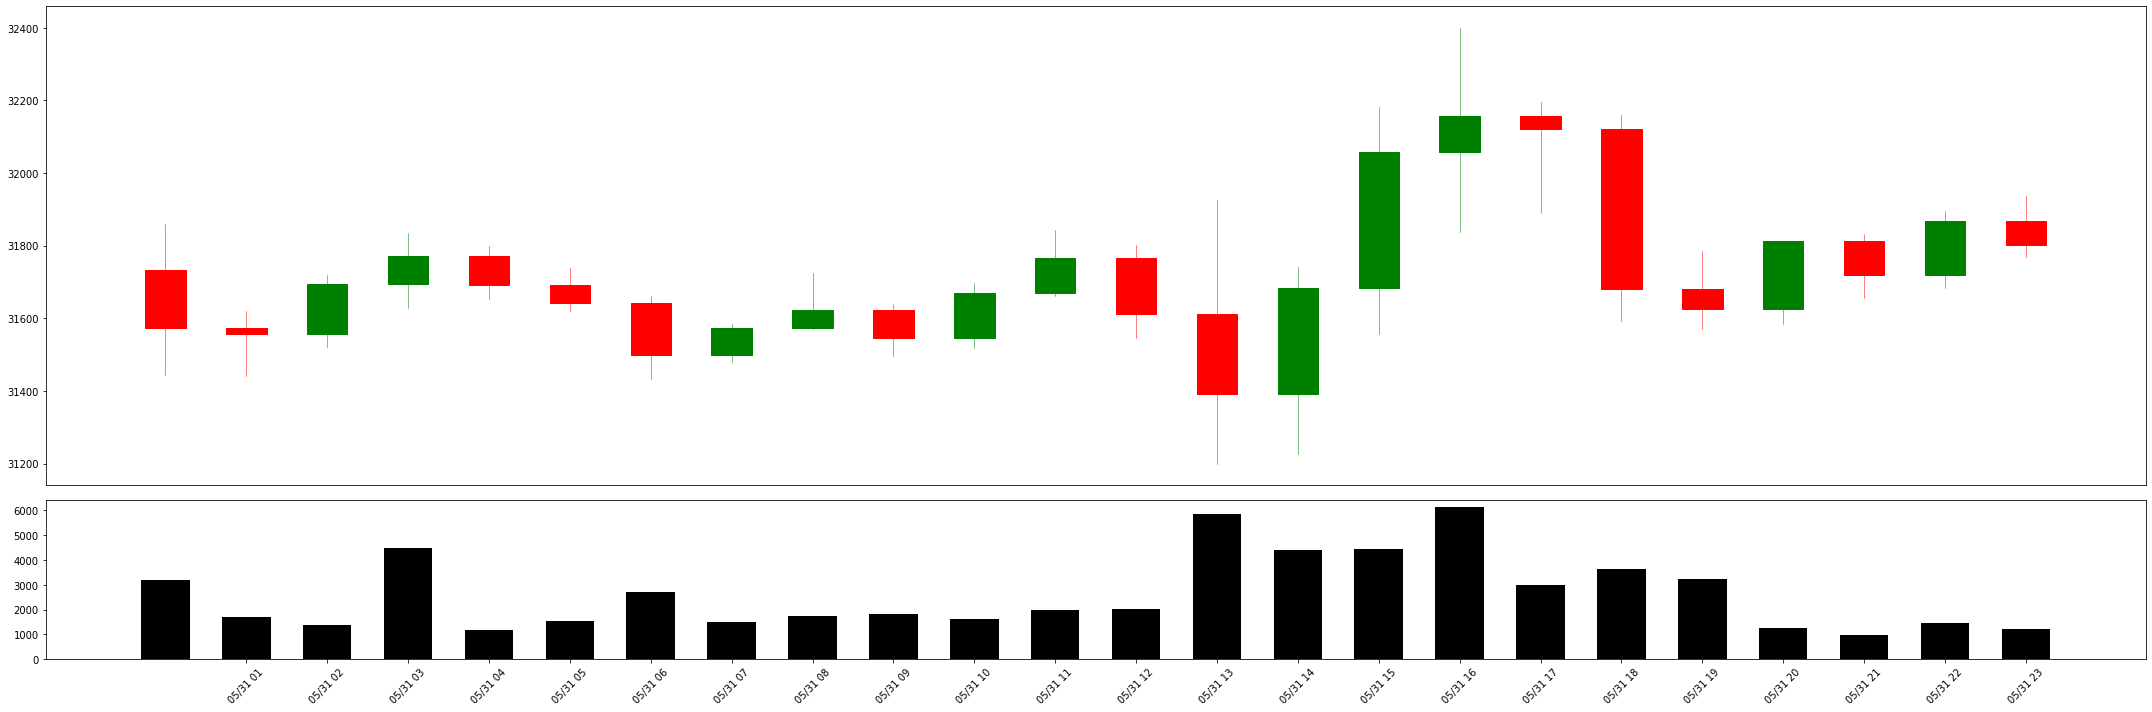

메이커다오, 은행 협업 관련 커뮤니티 제안 통과
더블록에 따르면 달러 연동 스테이블코인 DAI 발행 프로토콜 메이커다오(MKR) 커뮤니티에서 진행한 은행 협업 관련 투표가 통과됐다. 해당 제안은 87.24%의 찬성을 받아 통과됐다. 앞서 메이커다오 커뮤니티는 미국 펜실베니아 소재 헌팅던 밸리 은행(HVB)이 디파이를 활용해 자산을 차입할 수 있도록 하는 내용의 거버넌스 제안에 대한 투표를 진행했다. 이번 제안은 HVB를 위한 1억 DAI 규모 볼트를 만드는 것이 골자다.
뉴스가 올라온 시각 : 2022년 7월 8일 10시 
딥러닝 기반 기사 유사도: 0.8302
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.25%, 악재:0.01%, 중립:99.74%


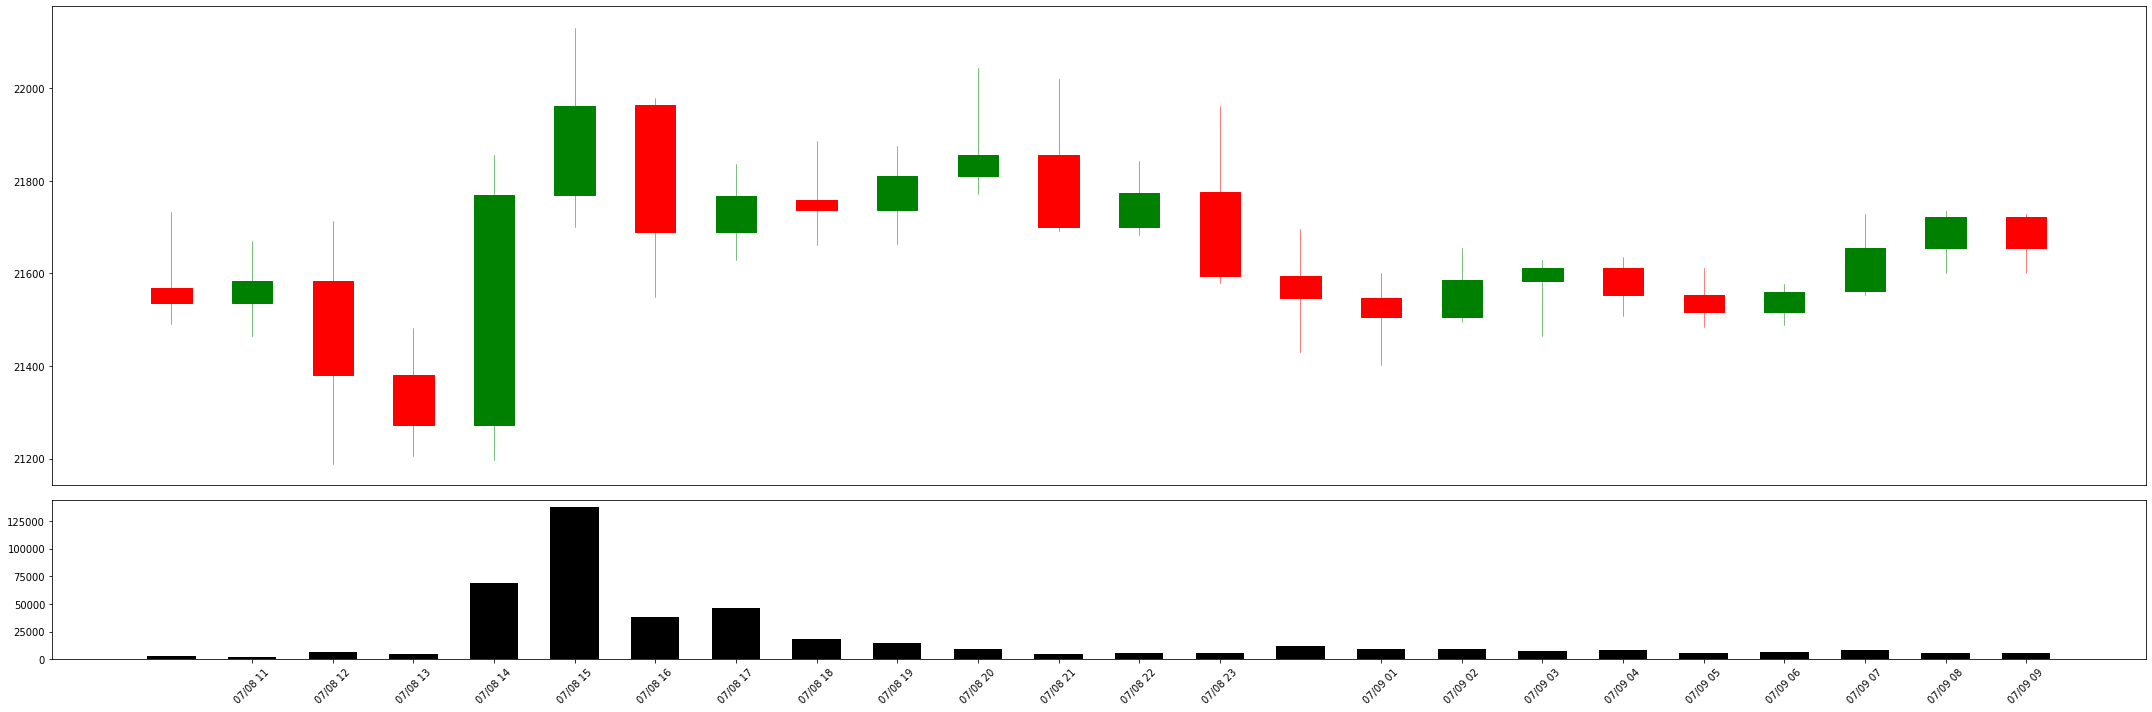

메이커다오 커뮤니티, GNO 담보자산 추가 제안 사실상 통과
블록체인 기반 예측 시장 프로토콜 그노시스(GNO)의 탈중앙화 자율조직인 그노시스다오가 메이커다오(MKR) 커뮤니티에 상정한 GNO 담보자산 추가 제안이 사실상 통과됐다고 더블록이 전했다. 현재까지 찬성률은 77%다. 투표 통과 후엔 GNO에 대한 위험, 기술, 오라클 평가가 진행되며 그후 메이커다오 임원진 및 대표단의 투표를 거쳐 담보자산 추가가 최종 결정된다. 지난달 그노시스다오는 메이커다오에 GNO 담보자산 추가를 제안했으며, 통과 시 첫해 GNO 담보물에 대해 최소 3000만 DAI를 생성하는 게 목표다.
뉴스가 올라온 시각 : 2022년 9월 21일 2시 
딥러닝 기반 기사 유사도: 0.8291
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.37%, 악재:0.02%, 중립:99.61%


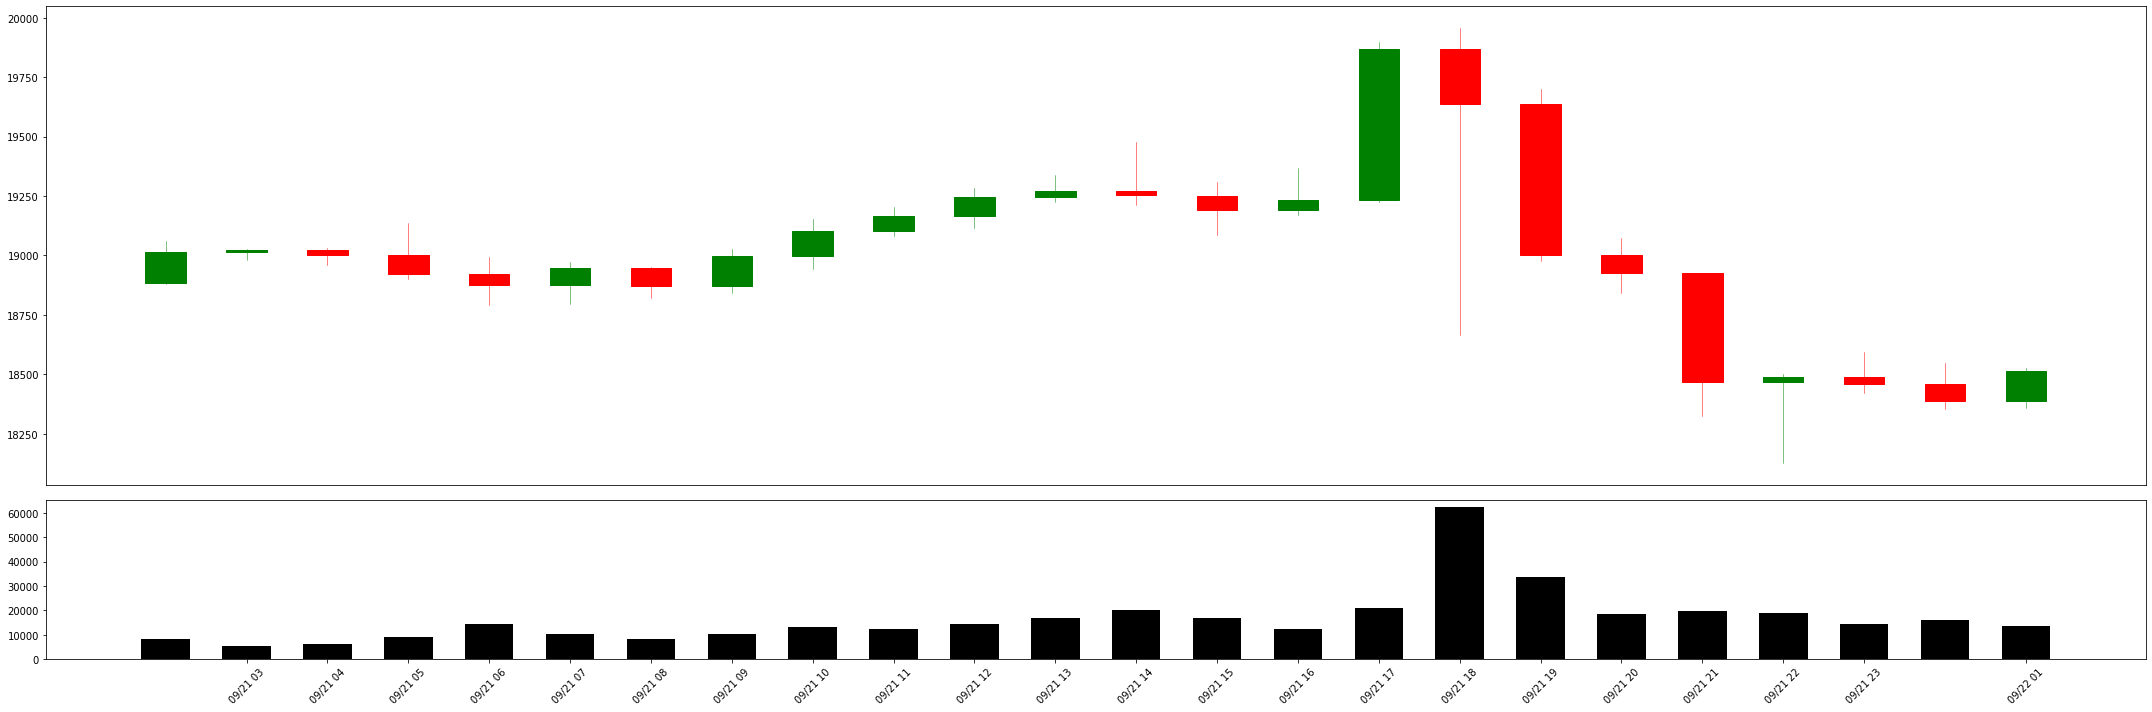

유니스왑, UNI재단 설립 커뮤니티 제안 통과
유니스왑(UNI) 커뮤니티에서 유니스왑 파운데이션 설립 제안 투표가 찬성으로 통과됐다. 해당 제안에 따르면 재단은 유니스왑 프로토콜의 성장 및 지속가능성 지원을 목표로 관련 연구자, 분석가 등을 지원한다. 재단 운영 자금은 7400만 달러이며 이 중 1400만 달러는 재단 팀에, 6000만 달러는 개발자 지원금에 사용될 예정이다. 재단은 이 자금을 유니스왑 DAO 트레저리에 요청했다. 앞서 코인니스는 유니스왑 랩스 멤버가 탈중앙화 암호화폐 거래소 성장을 위해 유니스왑 파운데이션 설립을 거버넌스에 제안했다고 전한 바 있다.
뉴스가 올라온 시각 : 2022년 8월 24일 12시 
딥러닝 기반 기사 유사도: 0.8252
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.88%, 악재:0.03%, 중립:99.09%


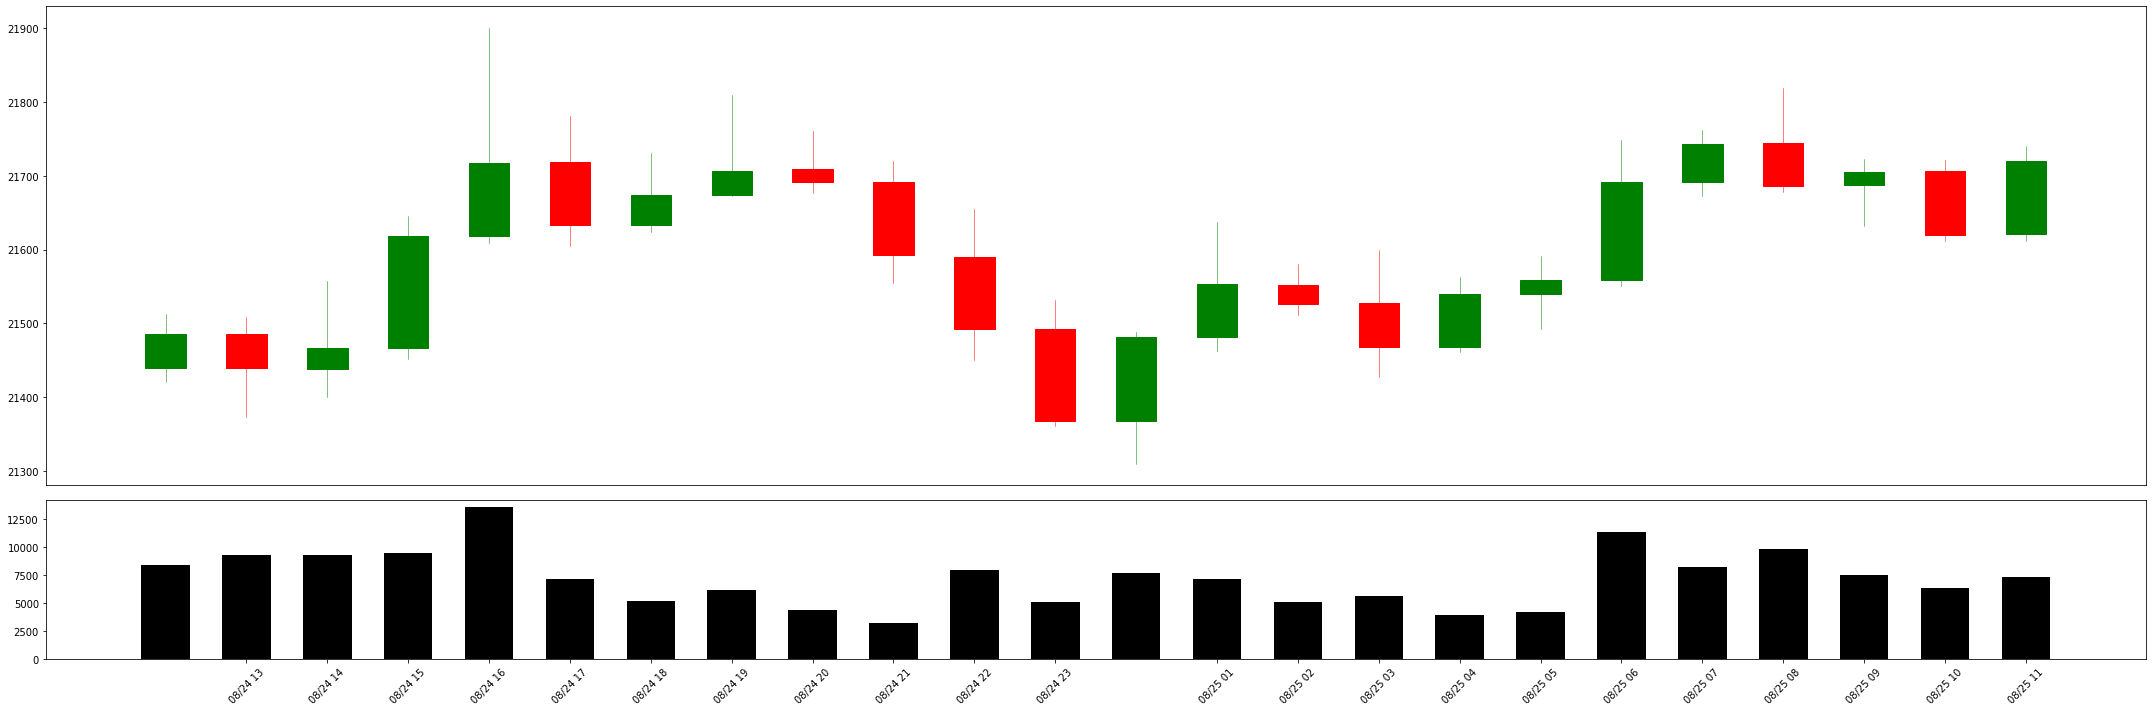

웨이브 USDN, 3/31 이후 첫 1 USDT 페깅 회복
웨이브(WAVES) 기반 알고리즘 스테이블코인 뉴트리노(USDN)가 3월 31일 이후 처음으로 1 USDT 페깅을 회복했다. 쿠코인 USDT 마켓에서 USDN은 오늘 오후 한때 1.0049 USDT에 거래됐다. 현재는 0.9936 USDT에 거래 중이다.
뉴스가 올라온 시각 : 2022년 7월 13일 21시 
딥러닝 기반 기사 유사도: 0.8233
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:4.85%, 악재:0.07%, 중립:95.08%


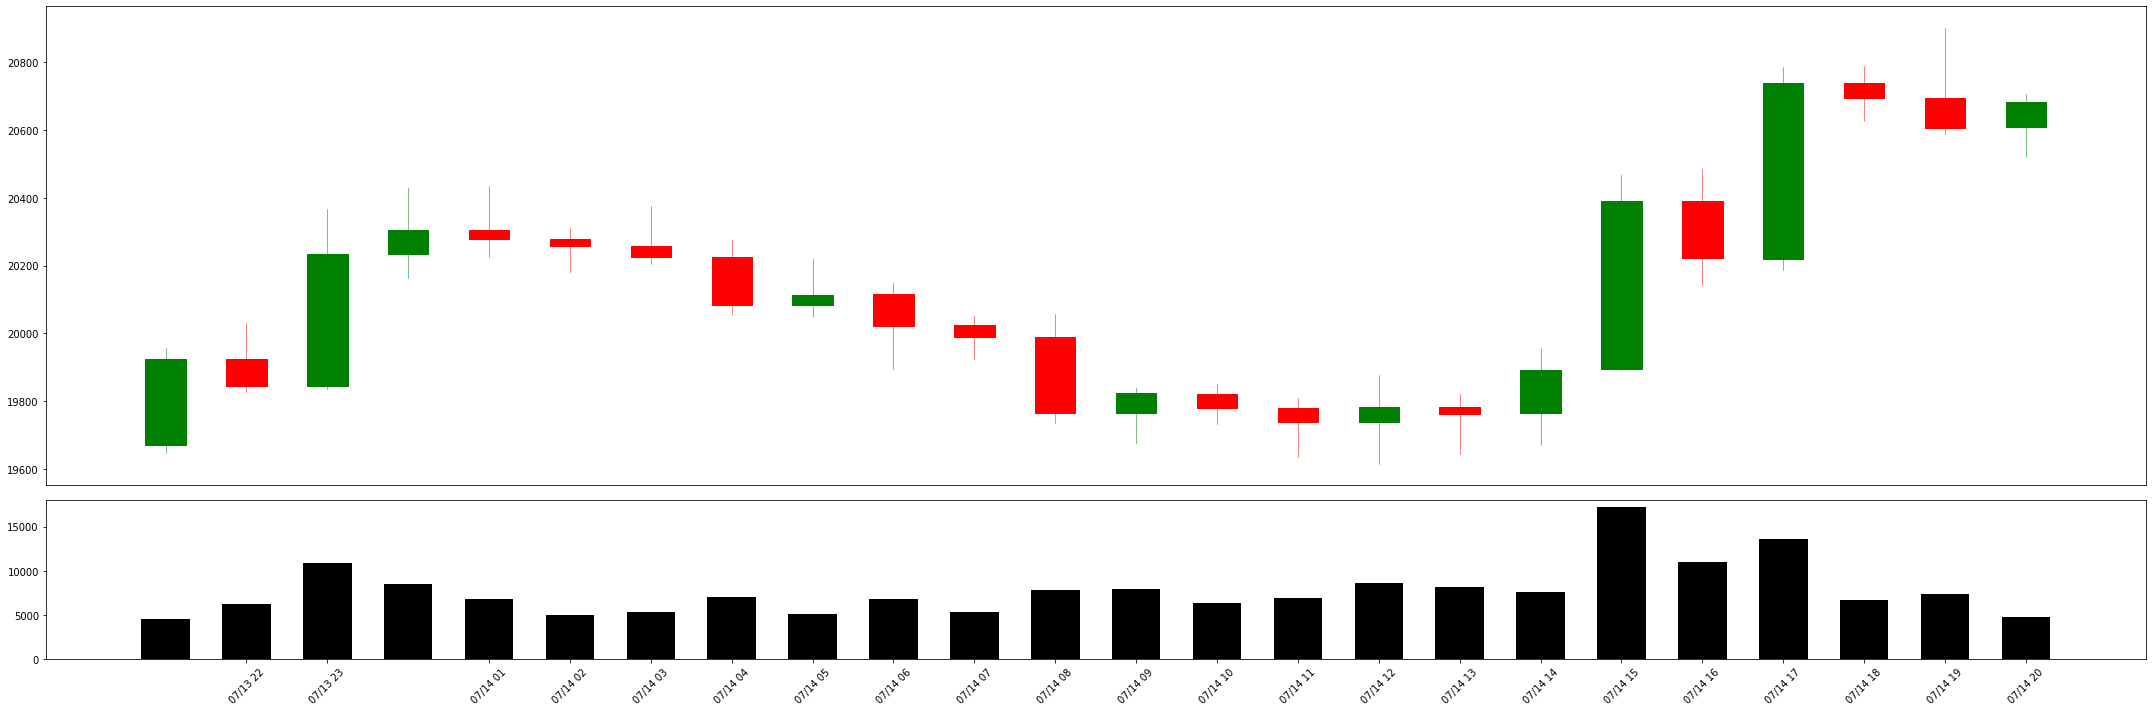

NFT 지수 펀드 'NFTX', 유동성 풀 이전...유니스왑→스시스왑
블록비트에 따르면 NFT 지수 펀드 NFTX의 유동성 풀 이전 제안이 통과됐다. 향후 수주 내 D1/ETH, D2/ETH, NFTX/ETH 유동성 자금풀이 유니스왑에서 스시스왑으로 이전된다. 총 투표 수는 11만 7000 NFTX로, 이 중 찬성표는 99.97%을 기록했다.
뉴스가 올라온 시각 : 2021년 1월 14일 13시 
딥러닝 기반 기사 유사도: 0.8219
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.01%, 악재:0.06%, 중립:98.93%


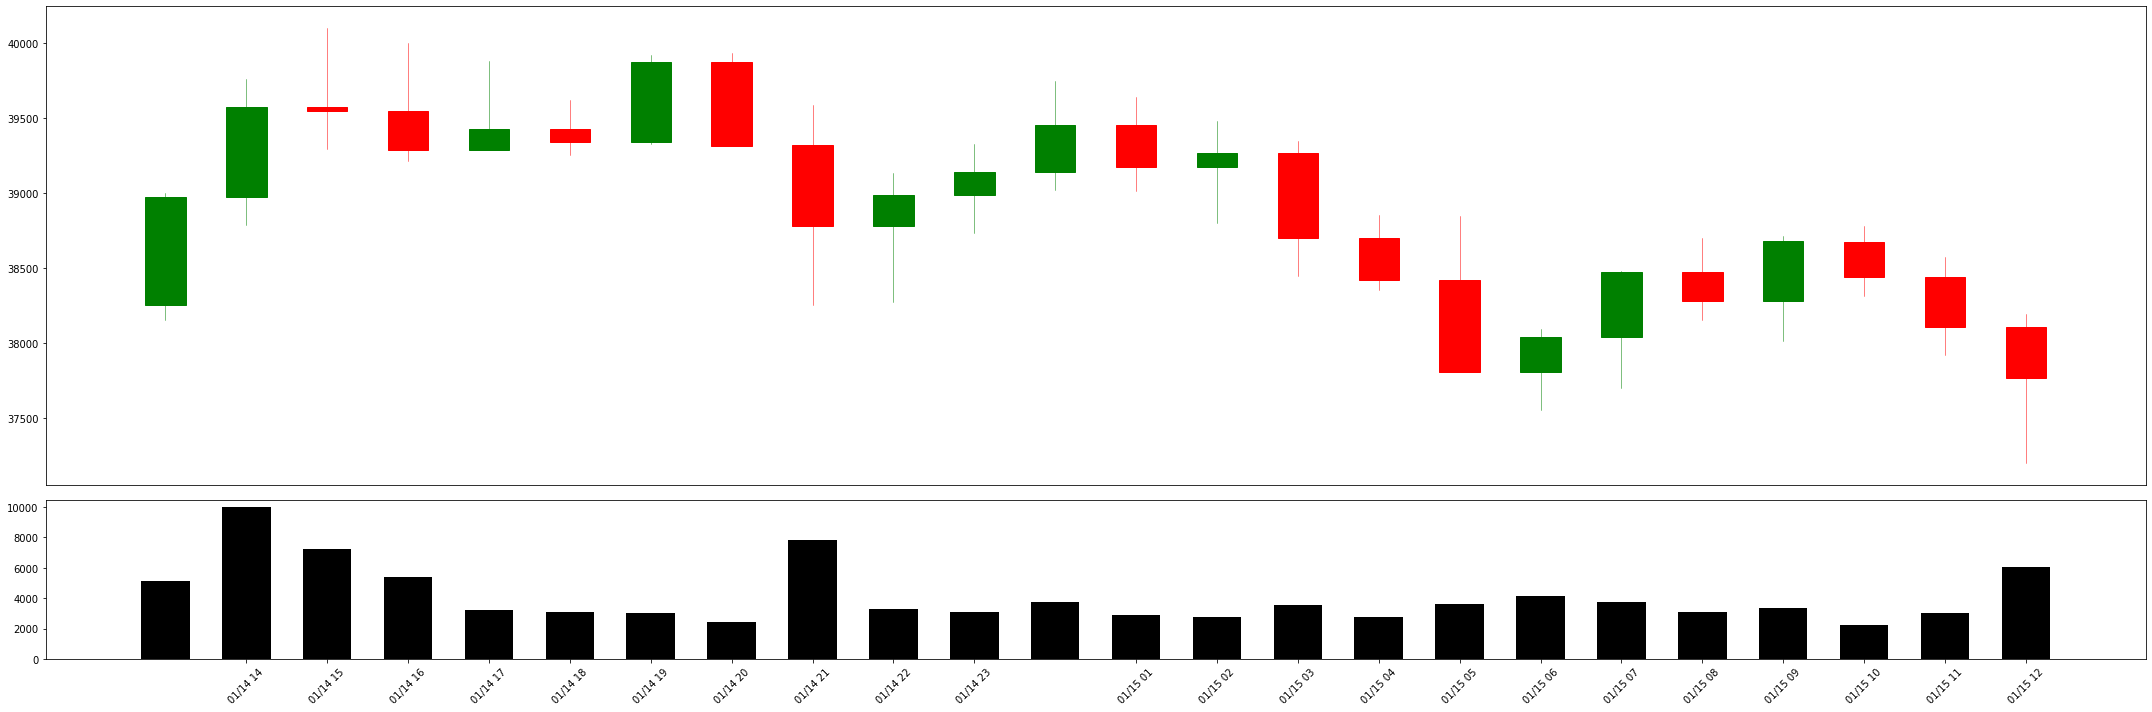

웨이브 설립자 "커브 USDN 풀 파라미터 변경안 통과.. 저렴할 때 사라"
사샤 이바노프 웨이브(WAVES) 설립자가 "커브(Curve) USDN 풀 파라미터(매개변수) 값 변경안이 통과됐다. 저렴하게 살 수 있을 때 USDN을 사라"고 방금 전 말했다. USDN은 웨이브 생태계 스테이블코인으로, 한때 $0.8를 밑돌았으나 현재는 0.93달러 수준을 회복한 상태다. 전날 사샤는 500만 USDN을 매수했으며 앞으로도 $1보다 가치가 낮은 USDN을 추매할 것이라고 말한 바 있다.
뉴스가 올라온 시각 : 2022년 4월 8일 0시 
딥러닝 기반 기사 유사도: 0.8188
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.8%, 악재:0.27%, 중립:97.94%


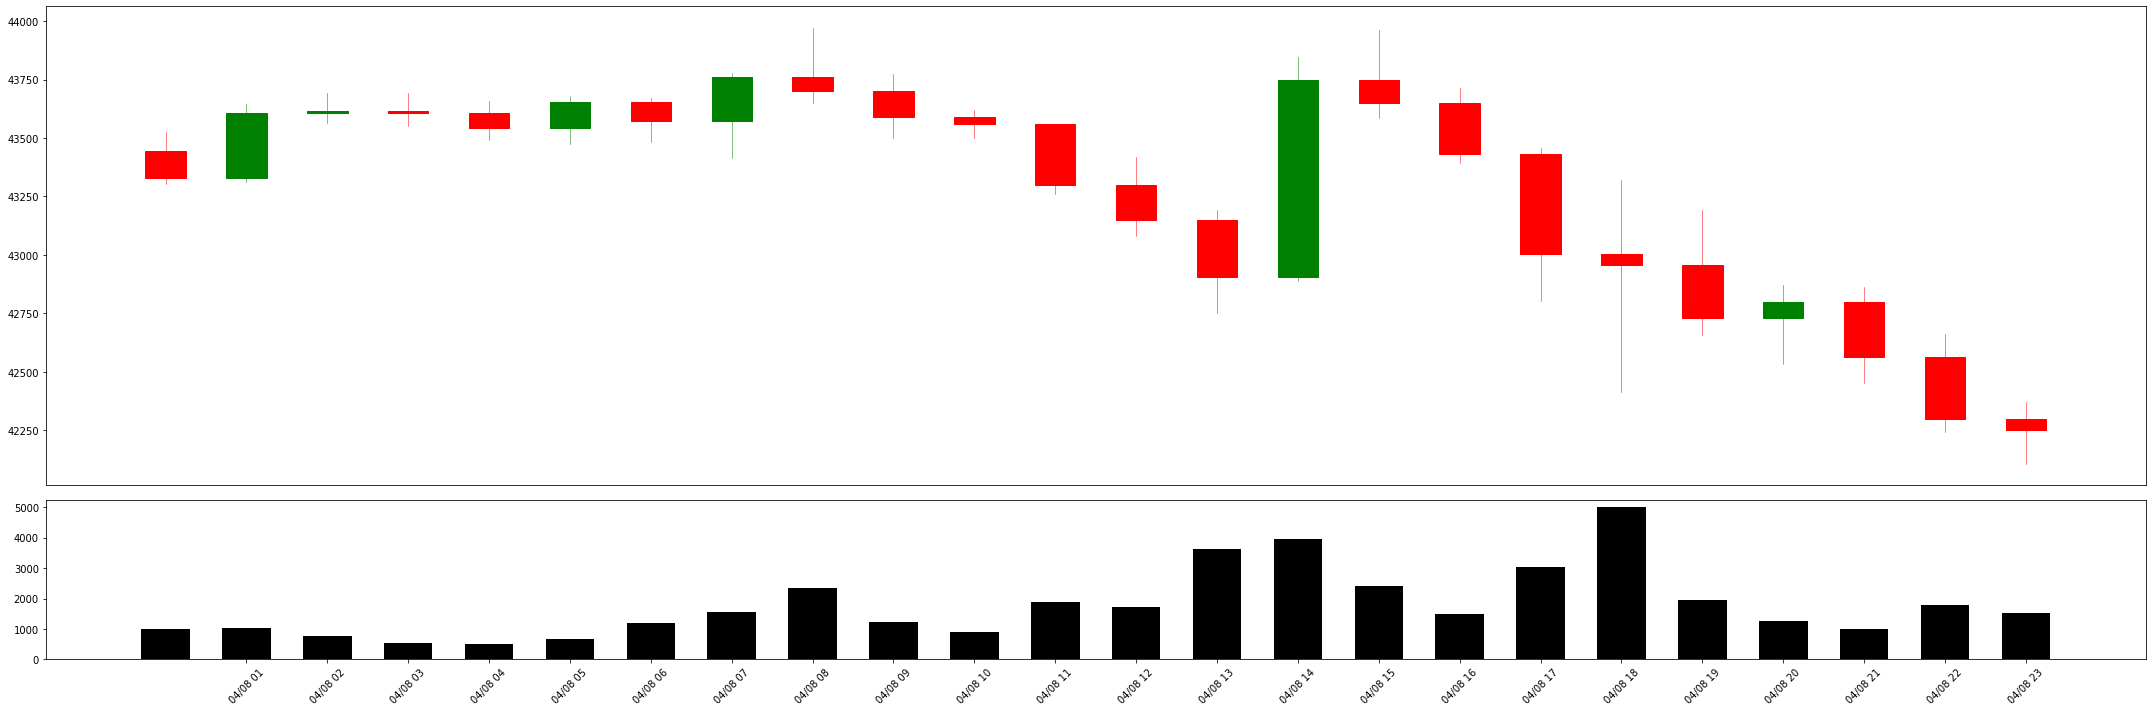

웨이브 설립자 "커브 USDN 풀 파라미터 변경안 통과.. 저렴할 때 사라"
사샤 이바노프 웨이브(WAVES) 설립자가 "커브(Curve) USDN 풀 파라미터(매개변수) 값 변경안이 통과됐다. 저렴하게 살 수 있을 때 USDN을 사라"고 방금 전 말했다. USDN은 웨이브 생태계 스테이블코인으로, 한때 $0.8를 밑돌았으나 현재는 0.93달러 수준을 회복한 상태다. 전날 사샤는 500만 USDN을 매수했으며 앞으로도 $1보다 가치가 낮은 USDN을 추매할 것이라고 말한 바 있다.
뉴스가 올라온 시각 : 2022년 4월 7일 18시 
딥러닝 기반 기사 유사도: 0.8188
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.8%, 악재:0.27%, 중립:97.94%


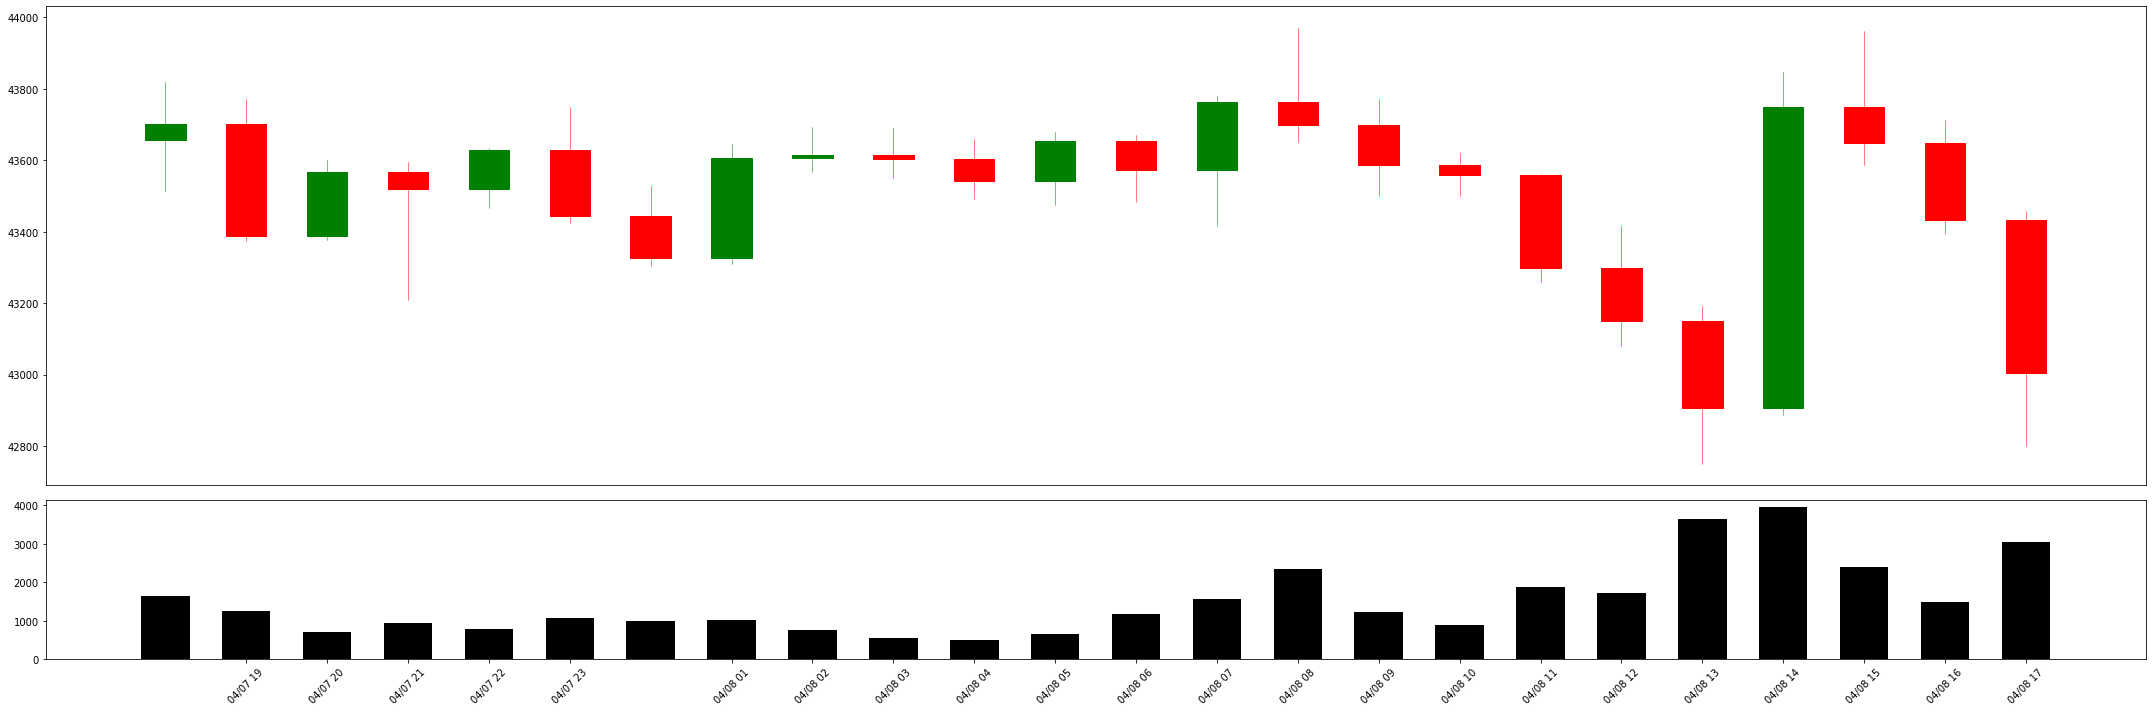

에이프코인 다오, 커뮤니티 마켓 구축 제안 통과
에이프코인(APE) 다오가 커뮤니티 마켓플레이스 구축 제안을 통과시켰다. 이에 따라 구축되는 커뮤니티 마켓플레이스는 온체인 오더북을 도입하고 오픈씨, 룩스레어 등 주요 NFT 마켓의 주문을 통합하는 기능을 갖출 예정이다. 또한 유가랩스의 모든 프로젝트 NFT 거래도 통합한다. APE 결제 시 구매자 및 판매자에 수수료를 부과하지 않는다. 거래 수수료 수입은 커뮤니티 다중서명 월렛에서 관리한다. 한편, 솔라나(SOL) 기반 NFT 마켓 매직에덴이 에이프코인 다오 전용 NFT 마켓플레이스를 구축하자는 제안을 상정했으나 투표 결과 부결된 바 있다.
뉴스가 올라온 시각 : 2022년 9월 22일 17시 
딥러닝 기반 기사 유사도: 0.8166
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.21%, 악재:0.02%, 중립:99.77%


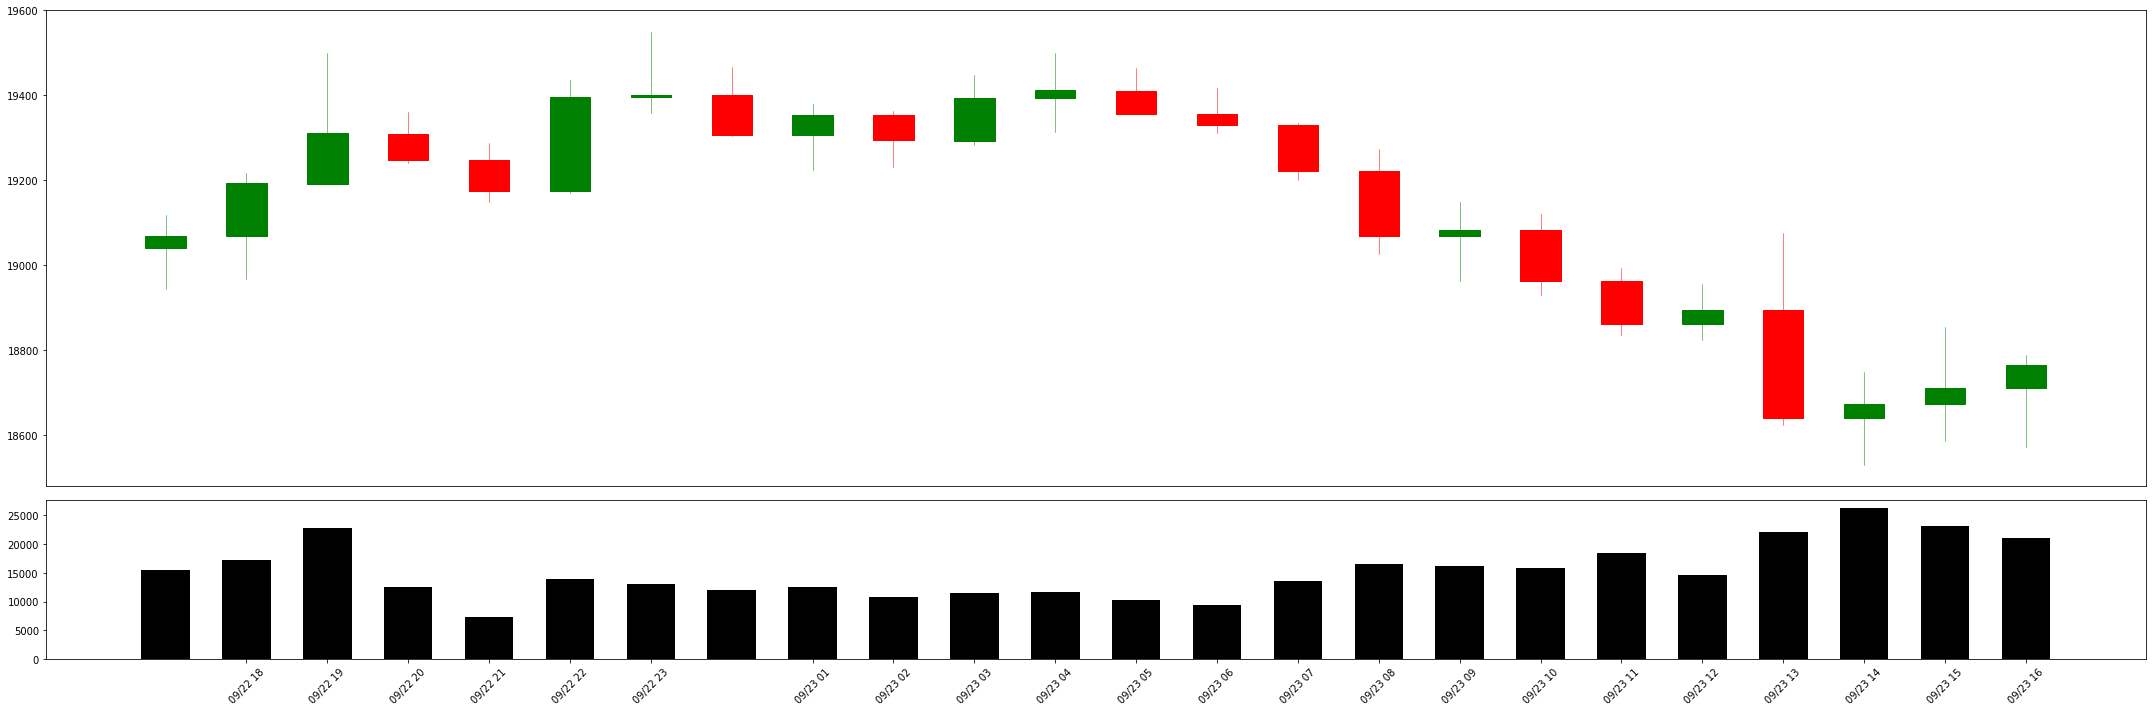

크림파이낸스, yUSD·yvWETH 리스팅
디파이 담보 대출 플랫폼 크림파이낸스가 최근 v2 yVault 토큰 yUSD와 yvWETH가 리스팅 됐다고 전했다. 이밖에 아이언 뱅크(Iron Bank)에서 스테이블코인 mUSD 예치가 가능해졌다. 방코르 내 CREAM 화이트리스트, 20만 BNT 공동투자 제안 투표는 찬성율 95.05%로 마감됐다. 정족률은 61.28%를 기록했다.
뉴스가 올라온 시각 : 2021년 6월 4일 19시 
딥러닝 기반 기사 유사도: 0.8164
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.48%, 악재:0.03%, 중립:99.49%


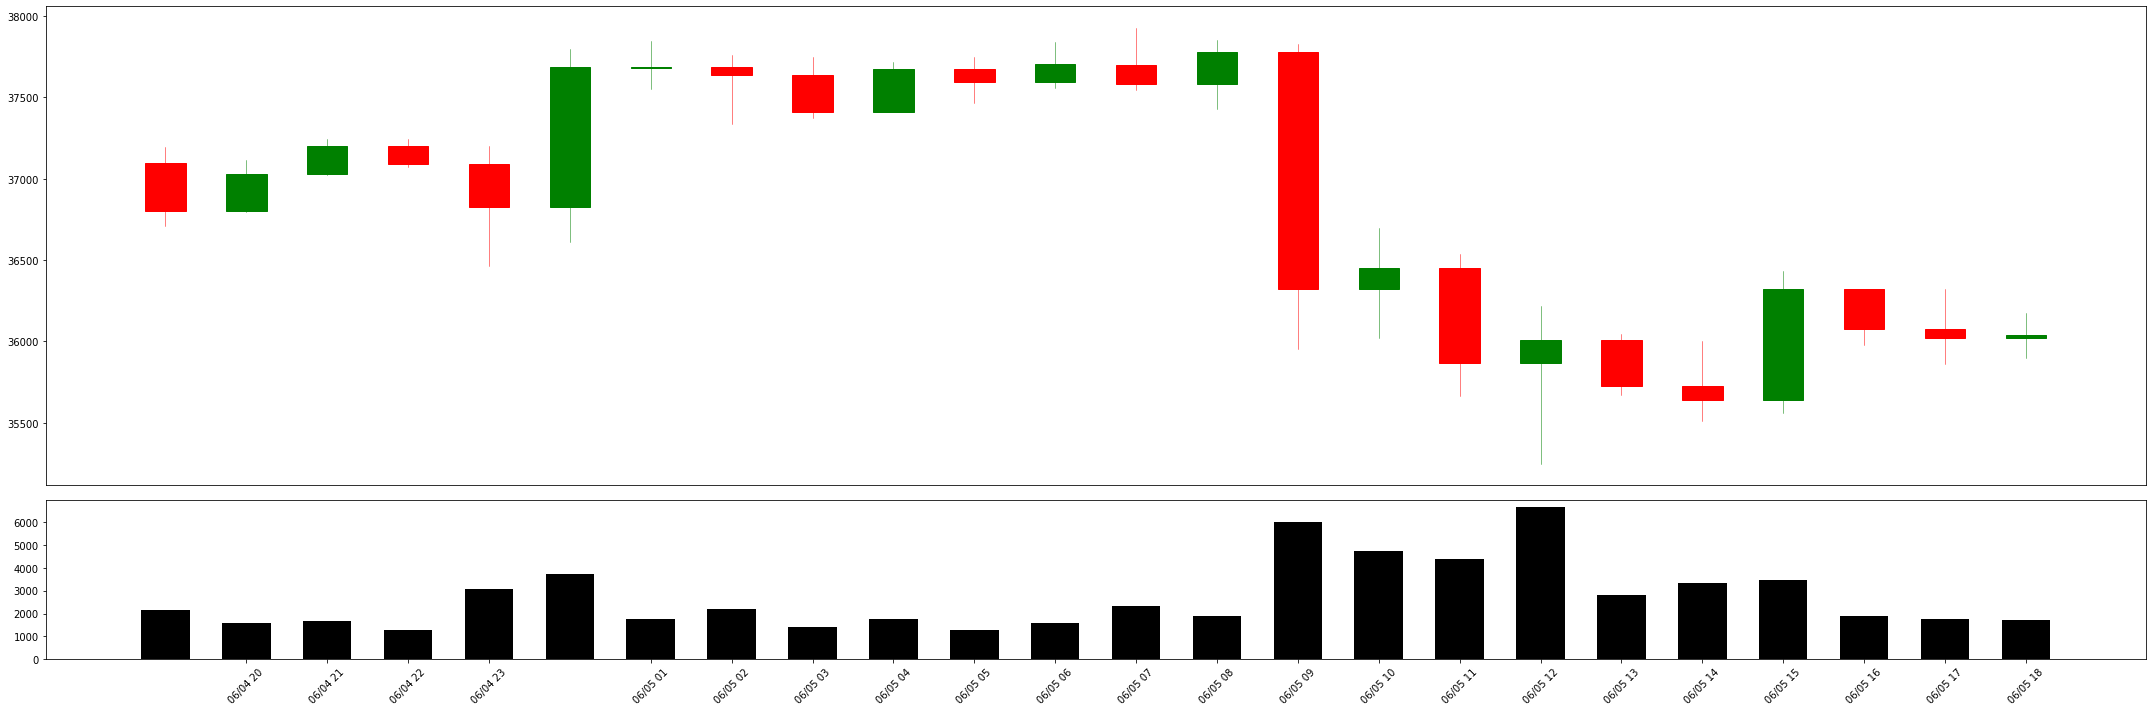

In [15]:
title = "USDN 다중담보 자산 전환 제안 통과" 
content = """웨이브 생태계 스테이블코인 USDN을 다중담보 자산으로 전환하는 제안 투표가 찬성 99%로 오늘 통과됐다. 앞서 코인니스는 웨브가 $WX,$SWOP,$VIRES,$EGG,$WEST를 담보로 해 USDN을 웨이브 생태계 인덱스 자산으로 만들어 USDN 디페깅 이슈를 해결할 플랜을 공개했다고 전한 바 있다."""

get_rank_results(title, content)



# Example 2

뉴스 제목을 입력하세요:  바이낸스 CEO, 29일 1시에 트위터 AMA 진행 예고
뉴스 기사를 입력하세요:  자오창펑 바이낸스 CEO가 한국시간 기준 29일 1시 트위터 스페이스를 통해 AMA를 진행한다고 트윗했다. 자오창펑 CEO는 오늘 트위터를 통해 "2022년 마지막 트위터 스페이스 AMA를 진행한다. 질문을 준비하라"고 말했다.


104826 개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.
============================== query ==============================
바이낸스 CEO, 29일 1시에 트위터 AMA 진행 예고
자오창펑 바이낸스 CEO가 한국시간 기준 29일 1시 트위터 스페이스를 통해 AMA를 진행한다고 트윗했다. 자오창펑 CEO는 오늘 트위터를 통해 "2022년 마지막 트위터 스페이스 AMA를 진행한다. 질문을 준비하라"고 말했다.
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.12%, 악재:0.05%, 중립:99.83%





============================== candidates ==============================
포튜브, 오늘 18시 AMA 진행
디파이 렌딩 플랫폼 포튜브(FOR)가 트위터를 통해 오늘 18시(한국시간) 래빗파이낸스(RabbitFinance)와 함께 공식 텔레그램 채널에서 AMA를 진행한다고 밝혔다. 텔레그램 채널: t.me/ForTubeFi
뉴스가 올라온 시각 : 2021년 6월 16일 12시 
딥러닝 기반 기사 유사도: 0.8665
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.1%, 악재:0.03%, 중립:99.87%


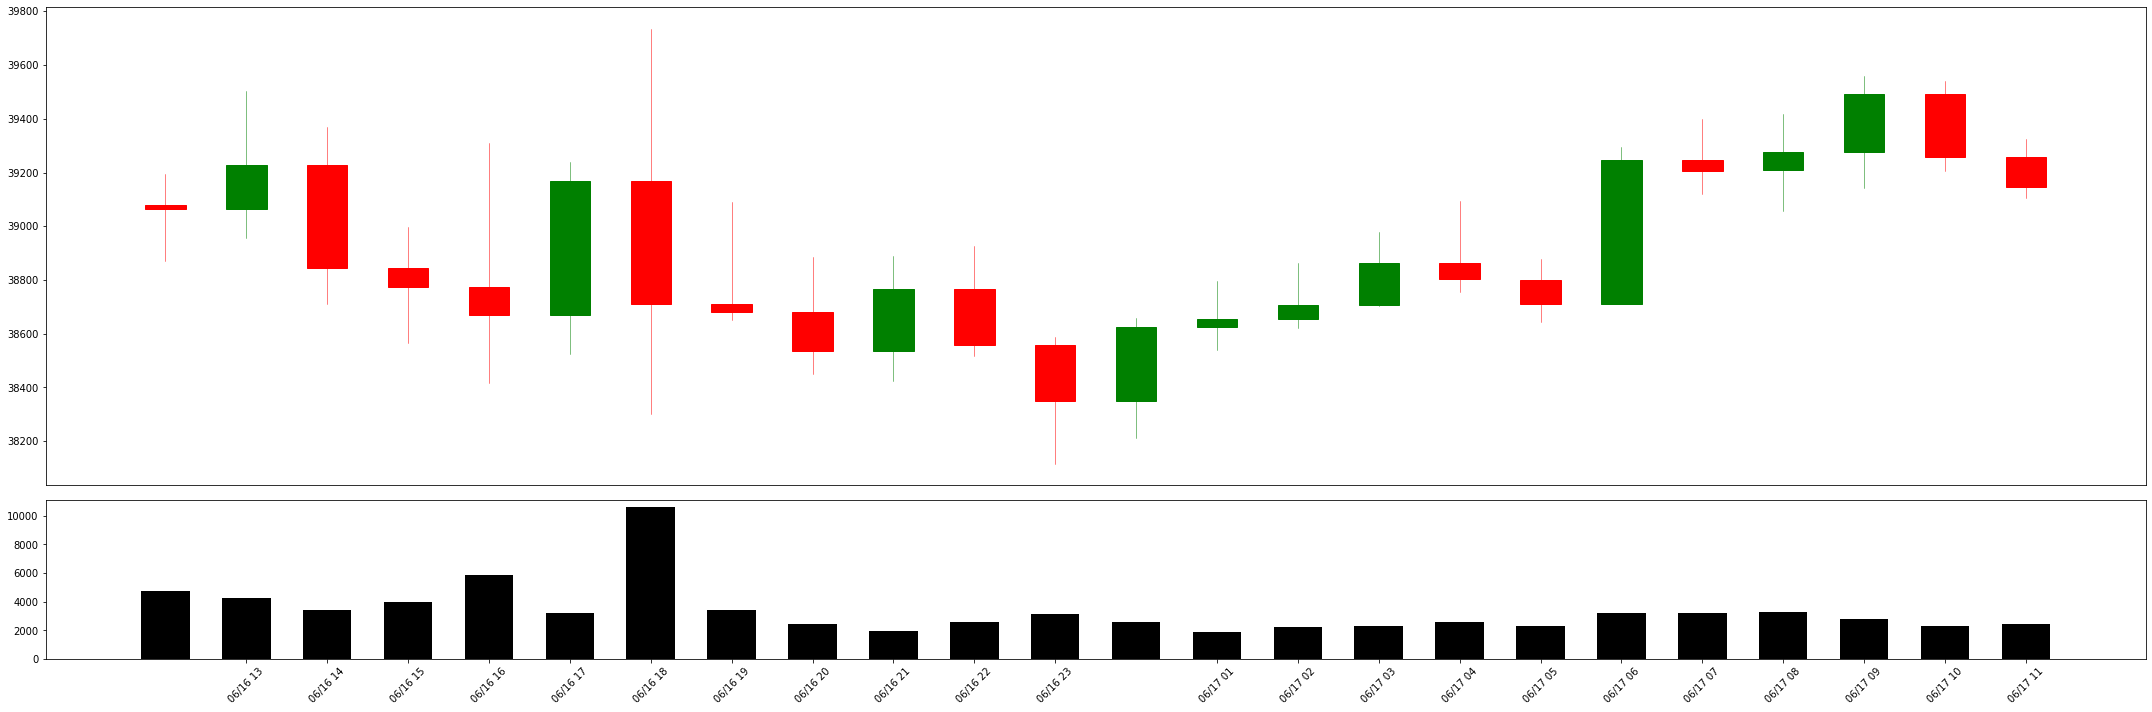

바이낸스, 22일 19시 칠리즈 AMA 진행
바이낸스(https://www.binance.com/kr)가 텔레그램 바이낸스 한국어 그룹 채팅방에서 22일 저녁 7시 칠리즈 AMA를 진행한다고 밝혔다. 총 600달러 상당 칠리즈 토큰을 분배하는 퀴즈 섹션도 준비돼 있다. 앞서 바이낸스 런치풀에 유벤투스(JUV), 파리 생제르맹(PSG) 팬토큰이 추가된 바 있다. BNB, BUSD, CHZ 토큰을 스테이킹할 시 JUV, PSG을 파밍할 수 있다. 21일 15시에는 BTC, BUSD, USDT 마켓에 JUV와 PSG가 상장될 예정이다.
뉴스가 올라온 시각 : 2020년 12월 21일 9시 
딥러닝 기반 기사 유사도: 0.8582
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.07%, 악재:0.02%, 중립:99.9%


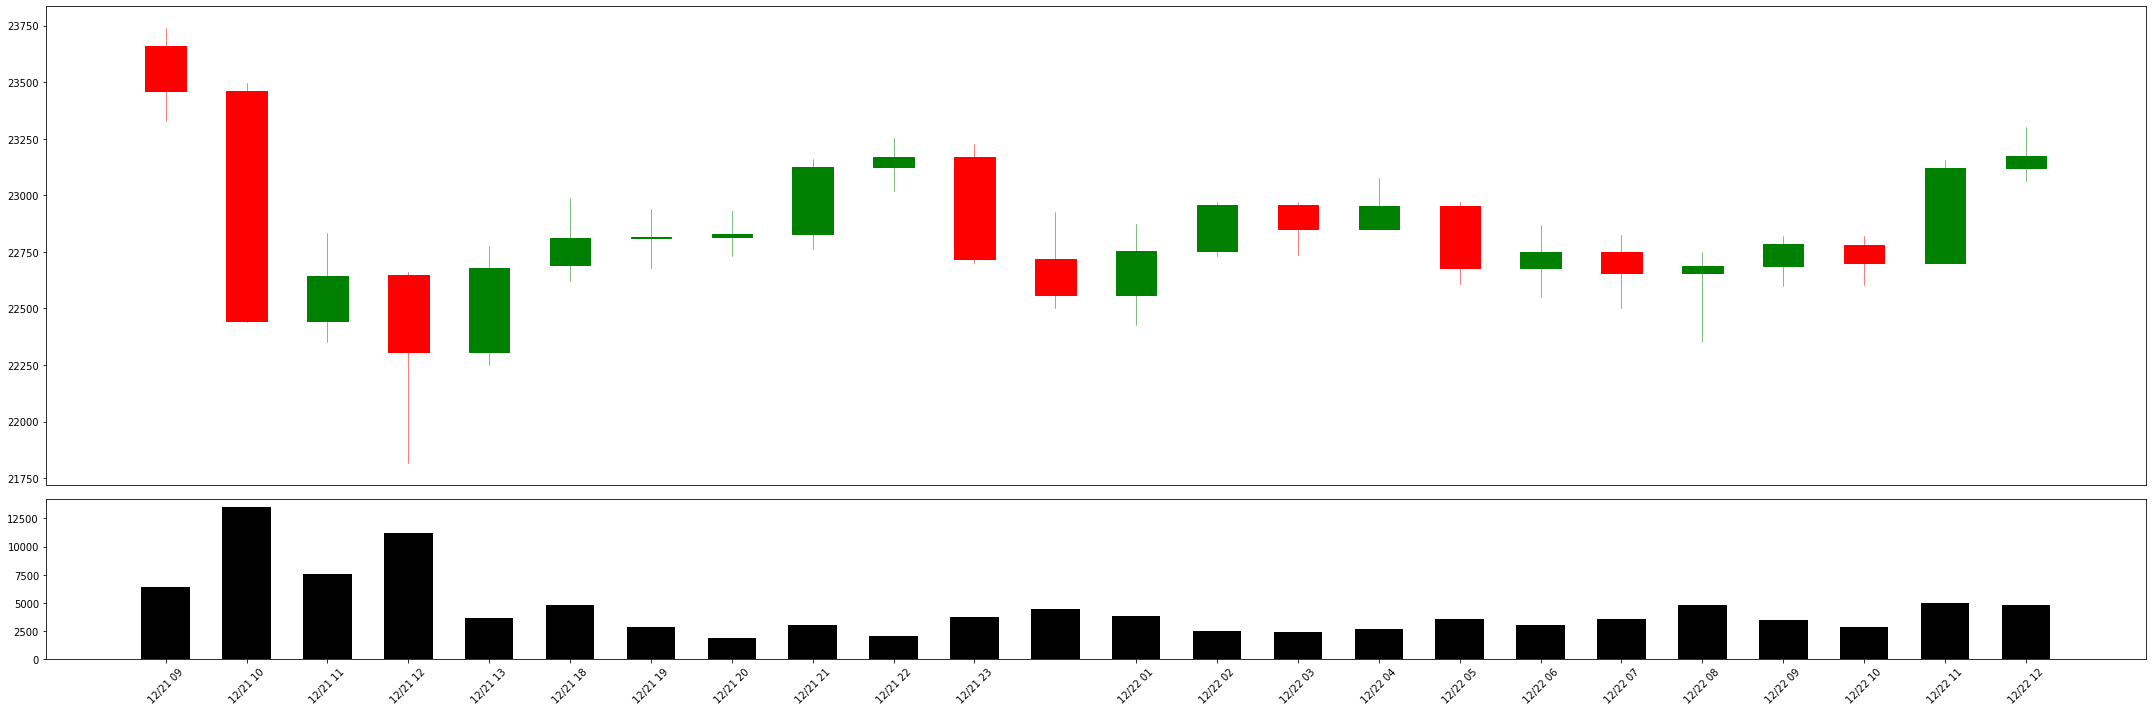

후오비 글로벌, 3일 21시 USDT 마켓서 TALK 거래 개시
후오비 글로벌이 3일 21시(한국시간) 멀티체인(Multi-chain) NFT Wallet 톡큰(TALK)을 USDT 마켓에 상장한다고 공지했다. 입금은 오픈된 상태며, 4일 17시(한국기준) 출금이 오픈된다. Talken은 자산을 연결하는 브릿지를 구축하고 NFT 사용자에게 OpenSea, Rarible 및 NBA TopShot 등 NFT 플랫폼에 대한 원스탑 액세스를 제공한다. 동시에, 월렛 서비스를 통해 NFT 민팅, 옥션, 수집 및 거래를 지원한다.
뉴스가 올라온 시각 : 2021년 9월 3일 20시 
딥러닝 기반 기사 유사도: 0.8536
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.09%, 악재:0.01%, 중립:99.9%


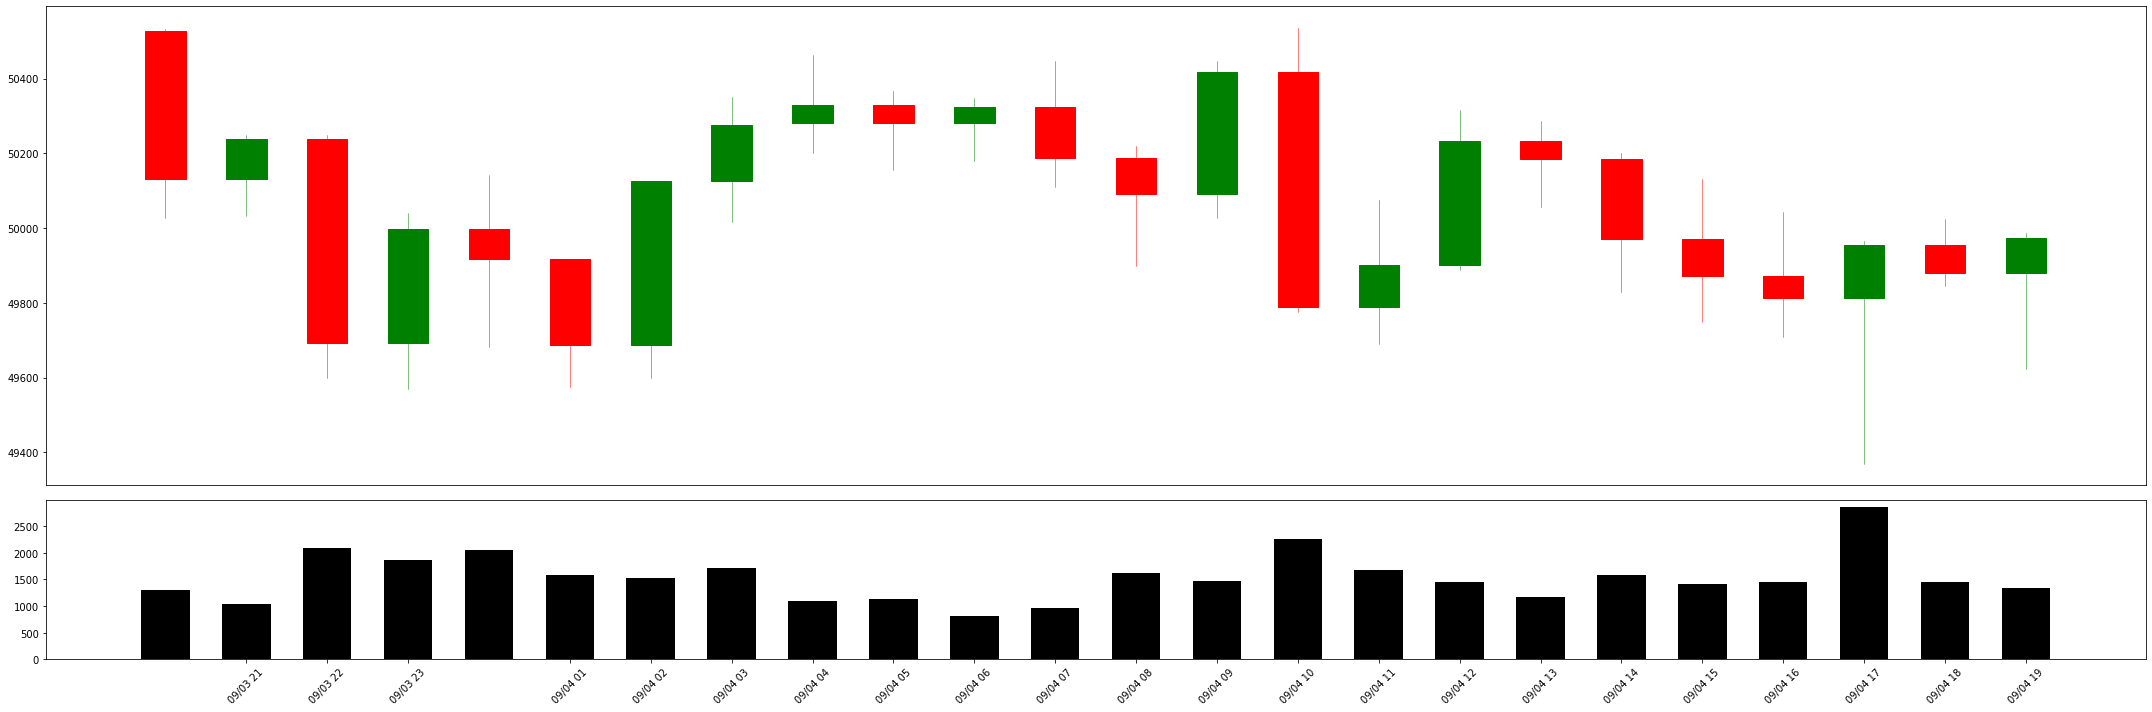

메타디움, 오늘 오후 7시 AMA 진행
메타디움이 오늘 오후 7시 AMA를 진행한다고 밝혔다. 영상송출은 메타디움 유튜브 채널, 실시간 질문은 텔레그램에서 진행될 예정이다. 메타디움 텔레그램: https://t.me/metadiumofficialkor
뉴스가 올라온 시각 : 2021년 5월 6일 14시 
딥러닝 기반 기사 유사도: 0.8533
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.04%, 악재:0.03%, 중립:99.93%


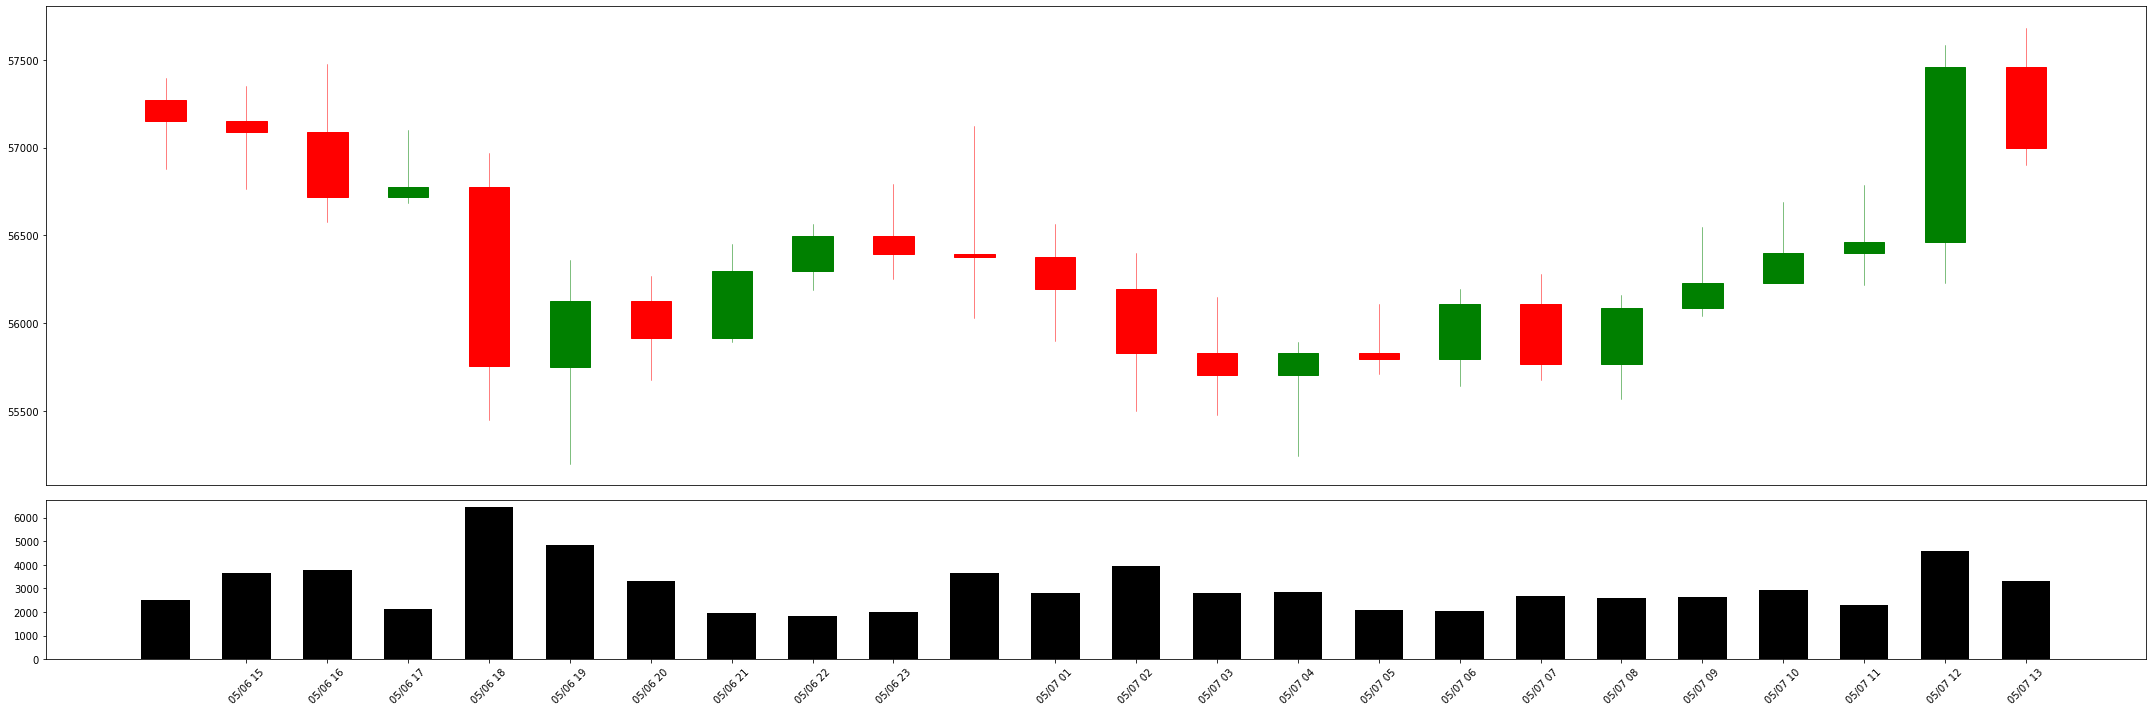

쿠코인, 9일 18시 USDT·ETH 마켓에 BOSON 상장
싱가포르 기반 암호화폐 거래소 쿠코인이 공식 트위터 계정을 통해 한국시간 기준 9일 18시 보손프로토콜(BOSON)을 USDT·ETH 마켓에 상장할 예정이라고 공지했다. BOSON은 현재 지노시스 옥션(Gnosis Auction) 거래소에서 토큰 세일을 진행 중이다. BOSON 토큰 세일은 4월 9일 오후 5시에 종료되며, 이후 당일 오후 6시부터 쿠코인에서 거래 가능하다.
뉴스가 올라온 시각 : 2021년 4월 9일 16시 
딥러닝 기반 기사 유사도: 0.8524
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.11%, 악재:0.02%, 중립:99.87%


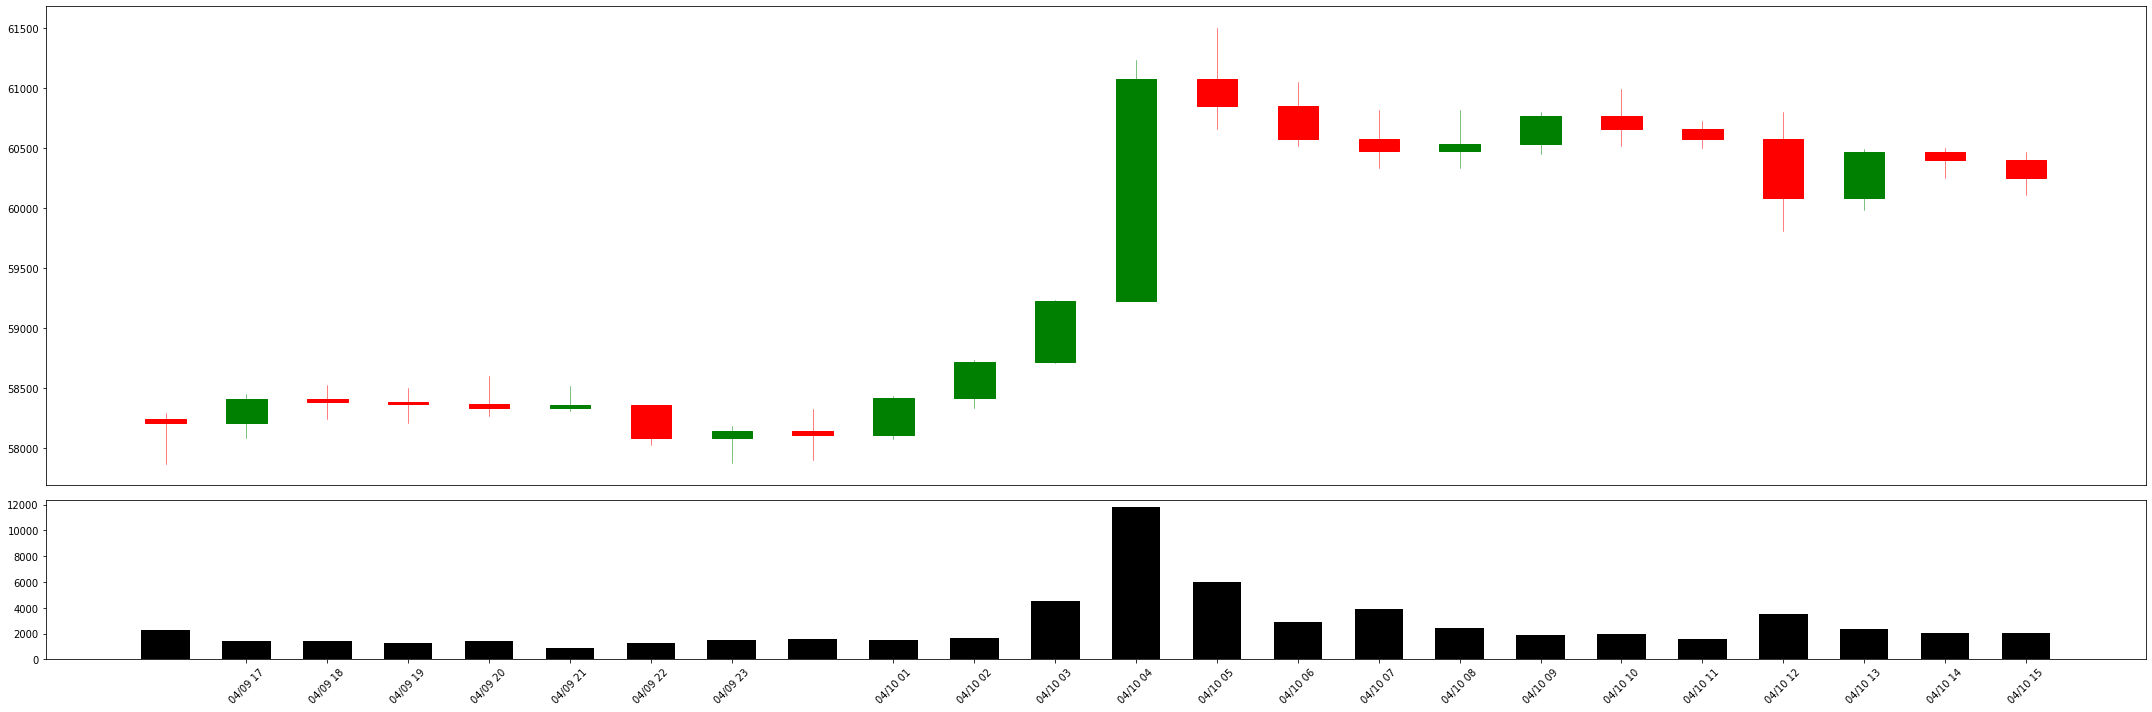

바이낸스 CEO "한동안 트위터 쉴 것"
자오창펑 바이낸스 CEO가 방금 전 "한동안 트위터를 쉴 것"이라고 말했다.
뉴스가 올라온 시각 : 2022년 4월 1일 11시 
딥러닝 기반 기사 유사도: 0.8504
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:2.51%, 악재:0.22%, 중립:97.27%


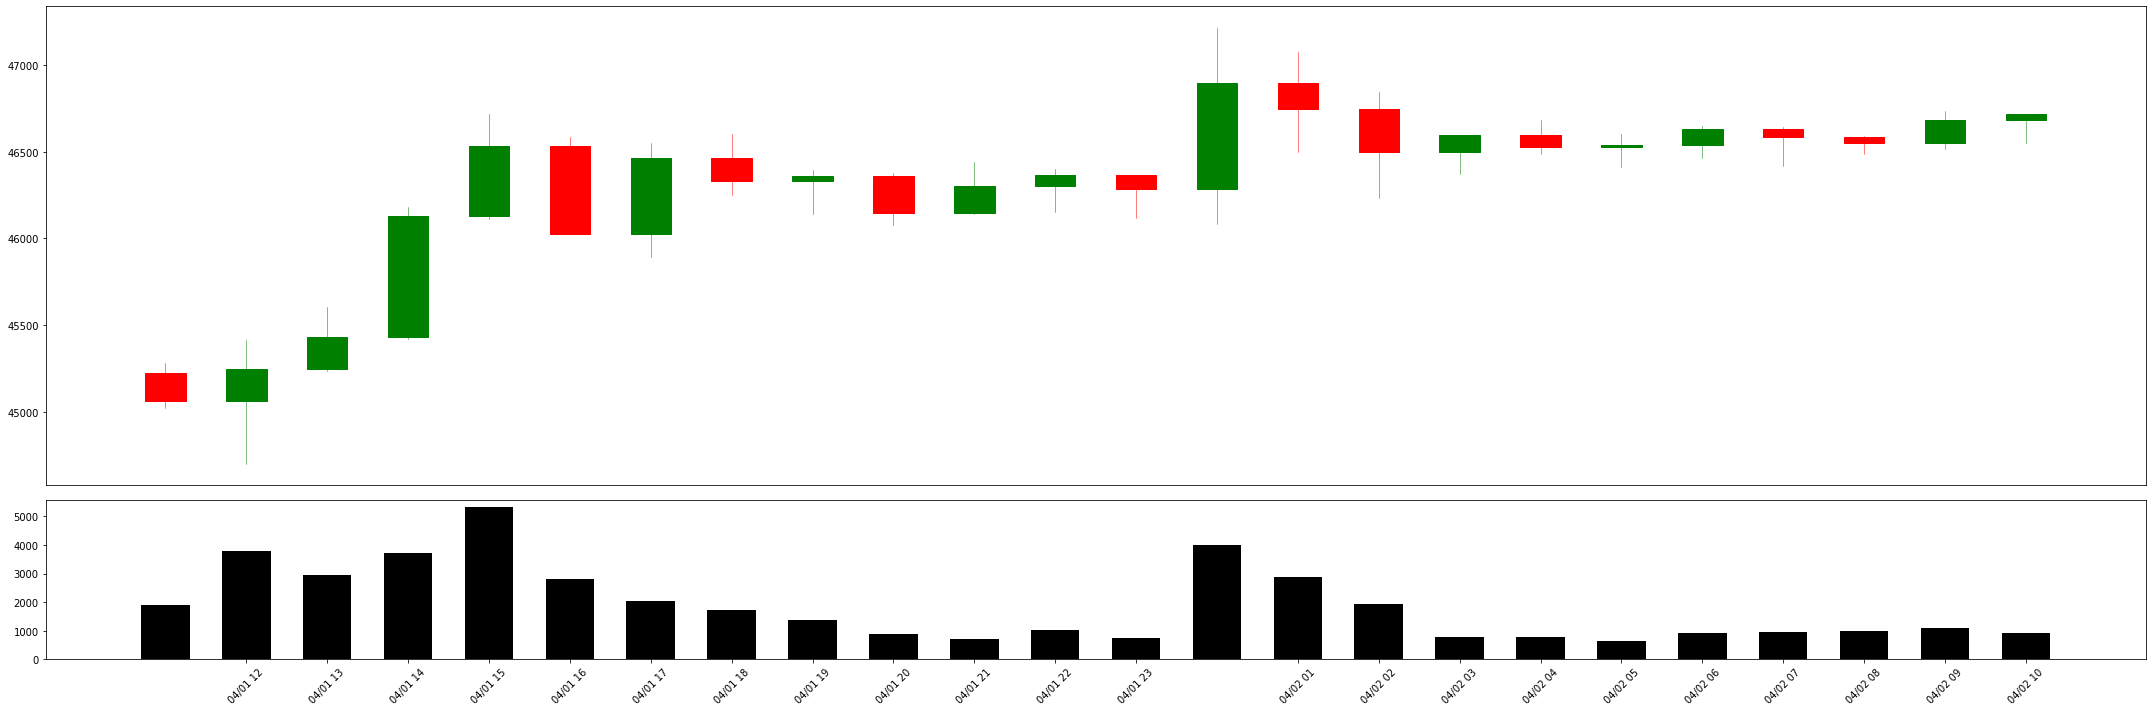

바이낸스, 21시 ALPINE 상장
바이낸스가 알파인 F1 팀 팬 토큰 런치패드를 완료, 2월 21일 21시 이노베이션존 BTC, EUR, TRY, USDT 마켓에 ALPINE을 상장한다고 공지했다. 앞서 코인니스는 바이낸스가 BWT 알파인 F1(포뮬러1) 팀과 파트너십을 체결했다고 전한 바 있다.
뉴스가 올라온 시각 : 2022년 2월 21일 19시 
딥러닝 기반 기사 유사도: 0.8503
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.12%, 악재:0.01%, 중립:99.87%


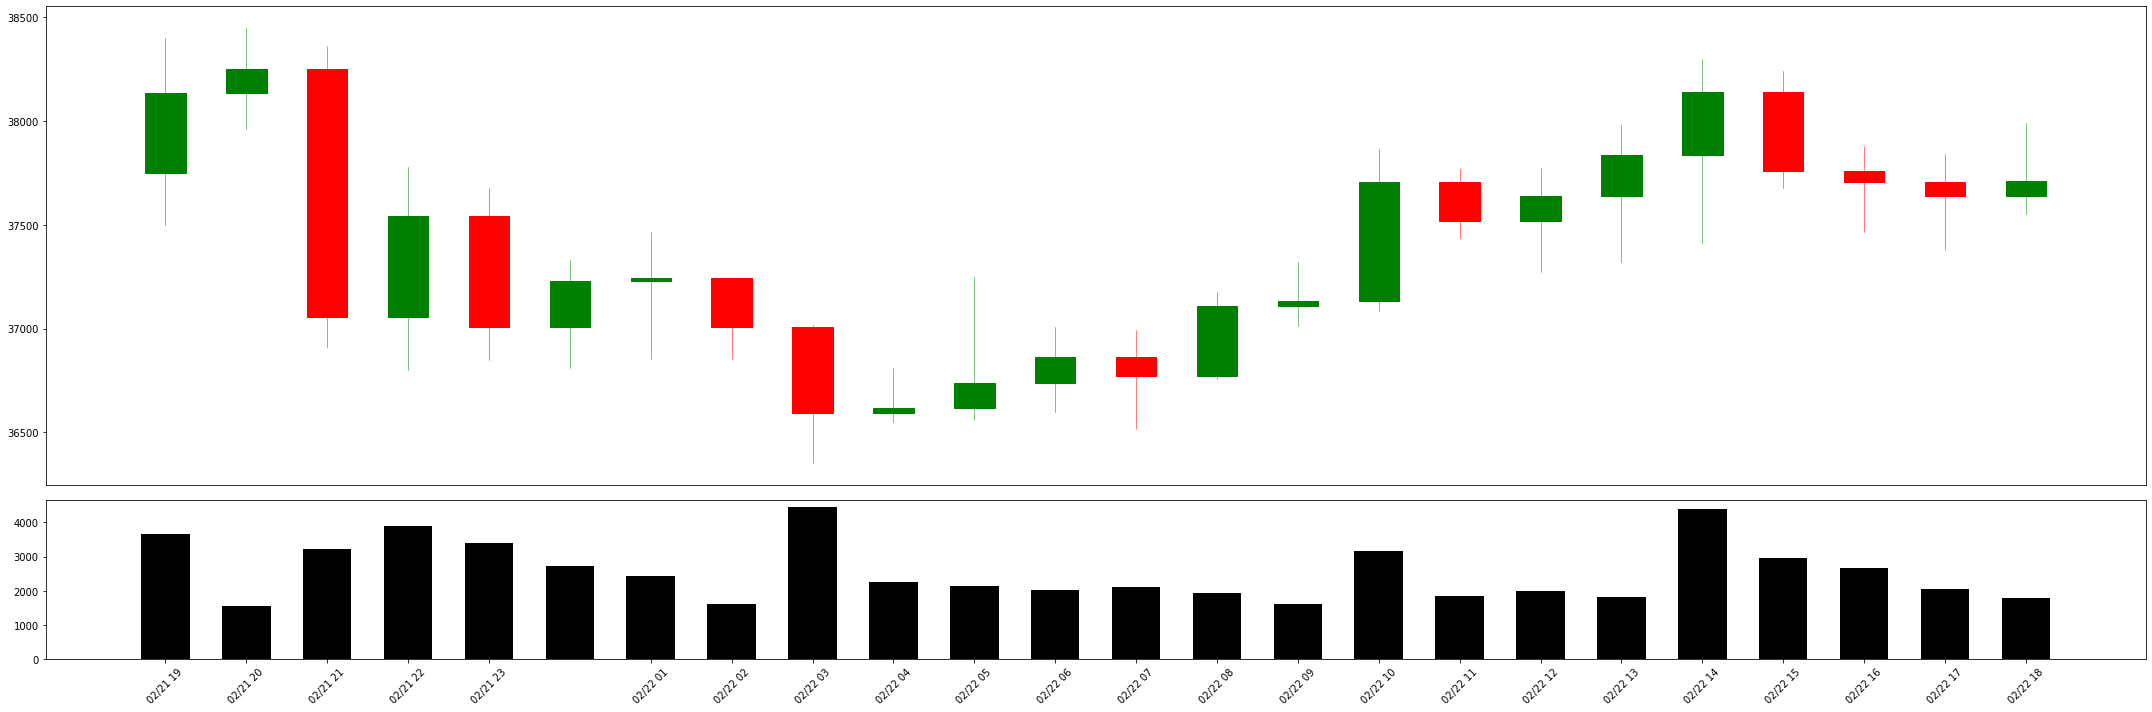

바이낸스, 21시 ALPINE 상장
바이낸스가 알파인 F1 팀 팬 토큰 런치패드를 완료, 2월 21일 21시 이노베이션존 BTC, EUR, TRY, USDT 마켓에 ALPINE을 상장한다고 공지했다. 앞서 코인니스는 바이낸스가 BWT 알파인 F1(포뮬러1) 팀과 파트너십을 체결했다고 전한 바 있다.
뉴스가 올라온 시각 : 2022년 2월 21일 10시 
딥러닝 기반 기사 유사도: 0.8503
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.12%, 악재:0.01%, 중립:99.87%


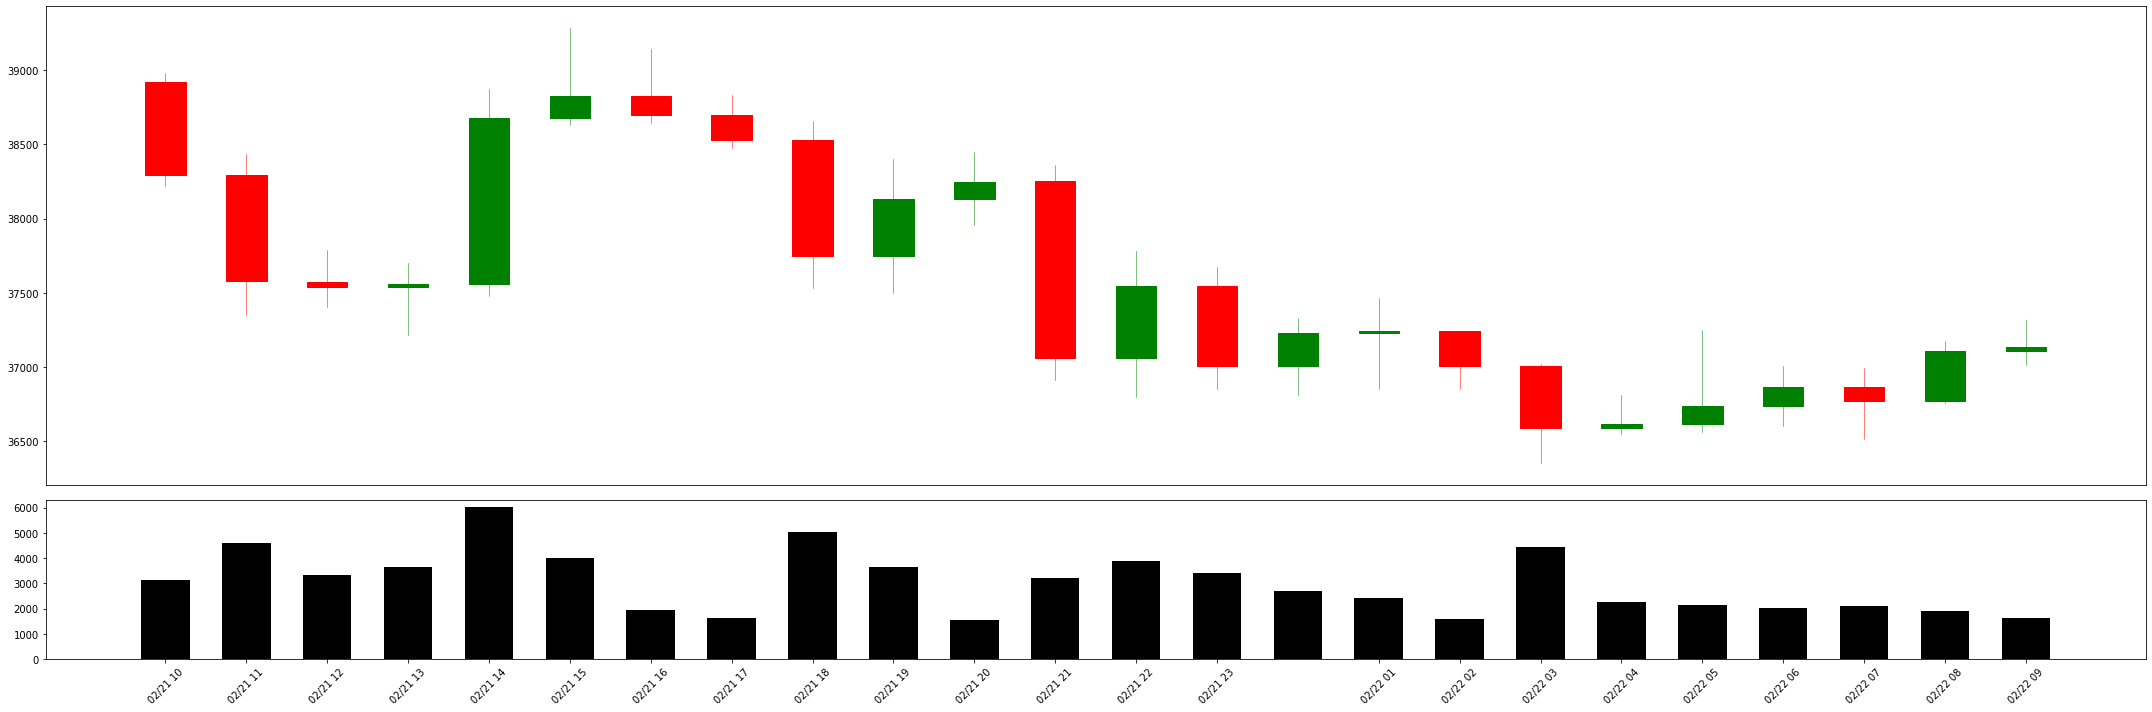

바이낸스, 오늘 19시 MOB·NEXO 상장
바이낸스가 29일 19시(한국시간) 모바일코인(MOB), 넥소(NEXO)를 USDT, BUSD, BTC 마켓에 상장한다고 공지했다. 입금은 오픈된 상태다.
뉴스가 올라온 시각 : 2022년 4월 29일 19시 
딥러닝 기반 기사 유사도: 0.8489
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.11%, 악재:0.03%, 중립:99.87%


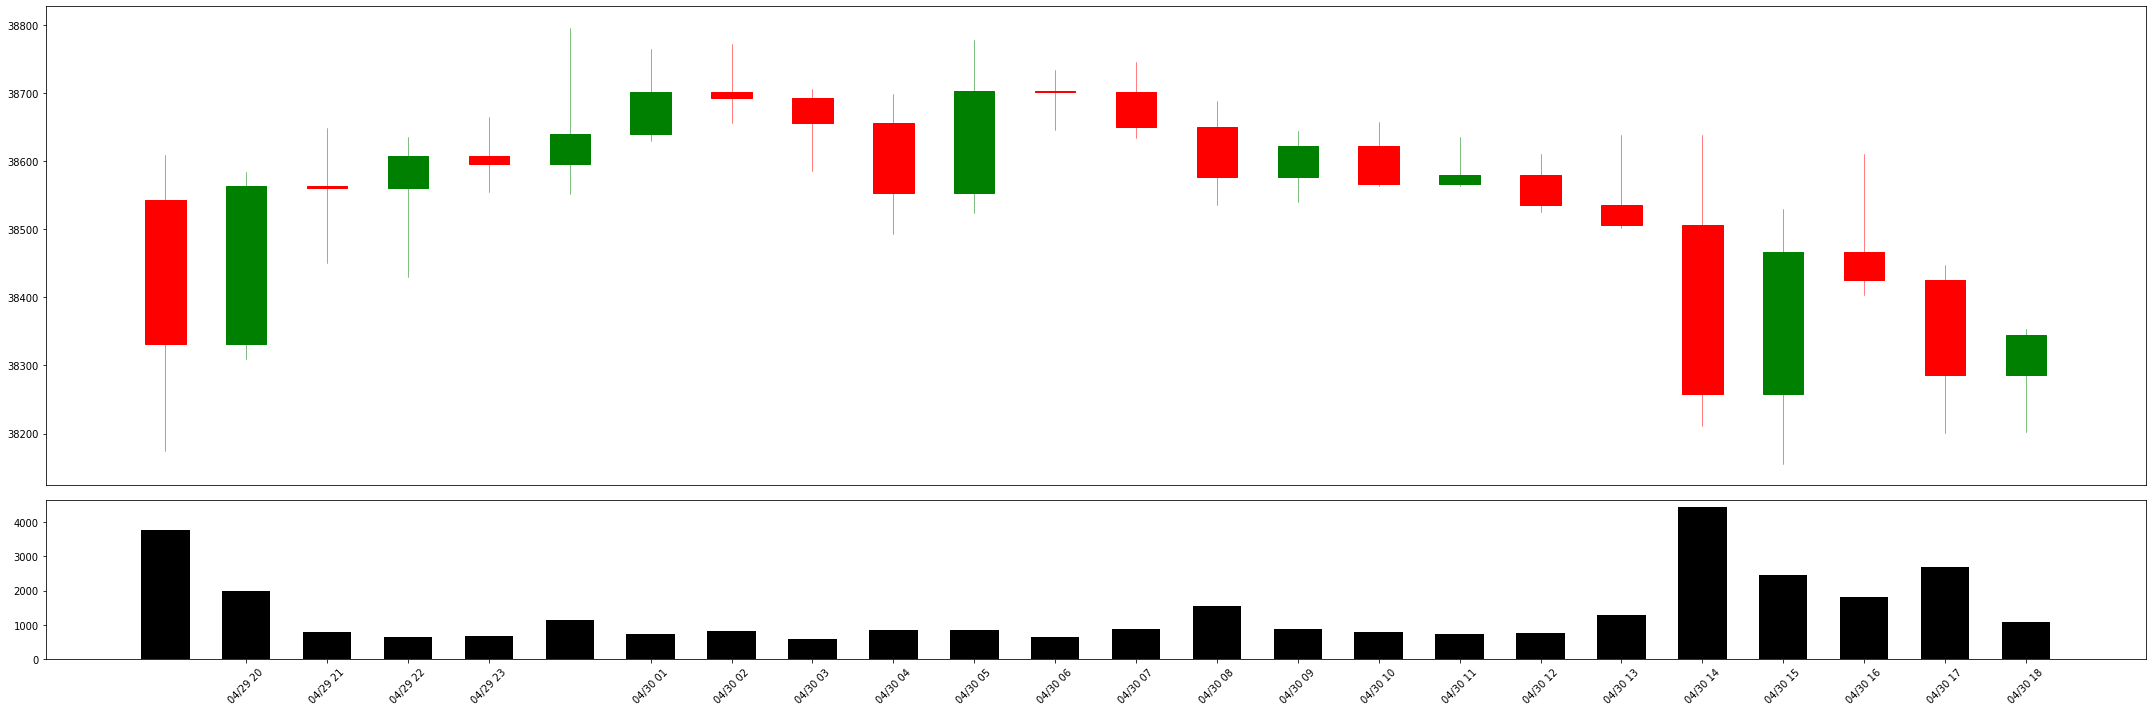

후오비 글로벌, 오늘 21시 USDT 마켓에 CELO 상장
후오비 글로벌이 방금 전 공식 사이트를 통해 한국시간 기준 5일 21시 USDT 마켓에 CELO를 상장할 예정이라고 공지했다. 앞서 오늘 오후 후오비 글로벌은 파이오니어존에 CELO를 상장하며, 입금 물량이 마켓 거래 수요를 충족하면 USDT 마켓에 상장될 것이라고 공지한 바 있다. 코인마켓캡 기준 CELO는 현재 8.0% 오른 5.76 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 1월 5일 18시 
딥러닝 기반 기사 유사도: 0.848
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.17%, 악재:0.02%, 중립:99.82%


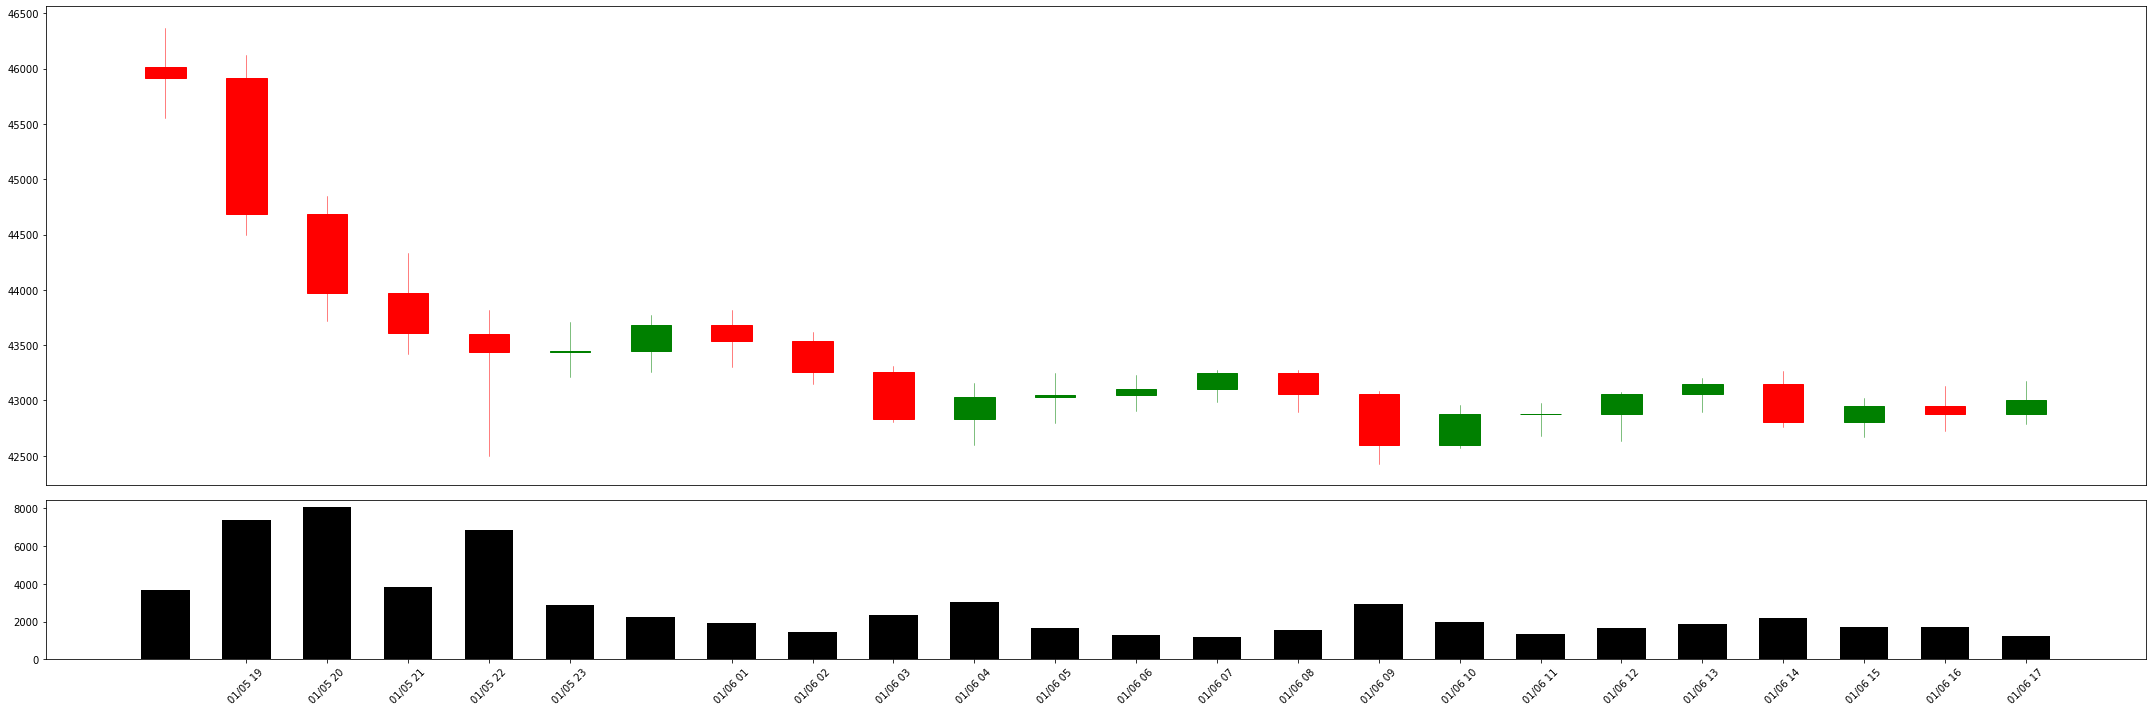

In [20]:
title = str(input("뉴스 제목을 입력하세요: "))
content = str(input("뉴스 기사를 입력하세요: ")) 

get_rank_results(title, content) 

# Example 3

뉴스 제목을 입력하세요:  국회입법조사처 "공직자 재산공개 범위에 가상자산 포함해야"
뉴스 기사를 입력하세요:  경향신문에 따르면 국회입법조사처가 27일 '가상자산과 관련한 공직 부패의 우려와 개선과제' 보고서를 통해 "주식이나 부동산처럼 가상자산도 공직자 재산등록·공개 제도 대상에 포함하고, 이에 대한 이해충돌 방지 규정도 법률로 규정해야 한다"고 주장했다. 조사처는 “최근 가상자산에 대한 접근성과 활용 빈도가 증가함에 따라 공직자에게 가상자산과 관련한 이해충돌 상황이 발생할 수 있다는 우려가 있다. 이에 따라 이해충돌 방지 규정이 공직자 전체에 대해 일반적으로 적용될 수 있도록 하는 방안을 검토할 필요가 있다. 특히 공직자 재산등록·공개 제도의 대상이 되는 재산의 범위에 주식과 부동산처럼 가상통화도 포함해 가상통화를 통한 재산 은닉 혹은 부정한 재산 증식을 방지할 필요가 있다"고 강조했다.


104826 개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.
============================== query ==============================
국회입법조사처 "공직자 재산공개 범위에 가상자산 포함해야"
경향신문에 따르면 국회입법조사처가 27일 '가상자산과 관련한 공직 부패의 우려와 개선과제' 보고서를 통해 "주식이나 부동산처럼 가상자산도 공직자 재산등록·공개 제도 대상에 포함하고, 이에 대한 이해충돌 방지 규정도 법률로 규정해야 한다"고 주장했다. 조사처는 “최근 가상자산에 대한 접근성과 활용 빈도가 증가함에 따라 공직자에게 가상자산과 관련한 이해충돌 상황이 발생할 수 있다는 우려가 있다. 이에 따라 이해충돌 방지 규정이 공직자 전체에 대해 일반적으로 적용될 수 있도록 하는 방안을 검토할 필요가 있다. 특히 공직자 재산등록·공개 제도의 대상이 되는 재산의 범위에 주식과 부동산처럼 가상통화도 포함해 가상통화를 통한 재산 은닉 혹은 부정한 재산 증식을 방지할 필요가 있다"고 강조했다.
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.38%, 악재:1.26%, 중립:97.37%





============================== candidates ==============================
국회입법조사처 "가상화폐 법제·컨트롤타워 조속히 구축해야"
세계일보에 따르면, 가상자산의 법적 지위를 분명히 하고 체계적인 부처 간 조율을 위해 컨트롤타워를 구축해야 한다는 지적이 나왔다. 11일 국회입법조사처는 '가상자산 관련 투기 억제 및 범죄 피해자 보호 방안' 보고서를 통해 "정부가 지난해 3월 개정한 특금법은 자금세탁 방지에 초점을 두고 있으며, 가상자산 이용자 보호 등 거래 안정화와 활성화에 대한 부분이 미비하다. 관련 부처인 금융위는 가상자산을 인정하기 어렵다고 보면서 투자자 보호 관점에서 개입 여부를 고민하

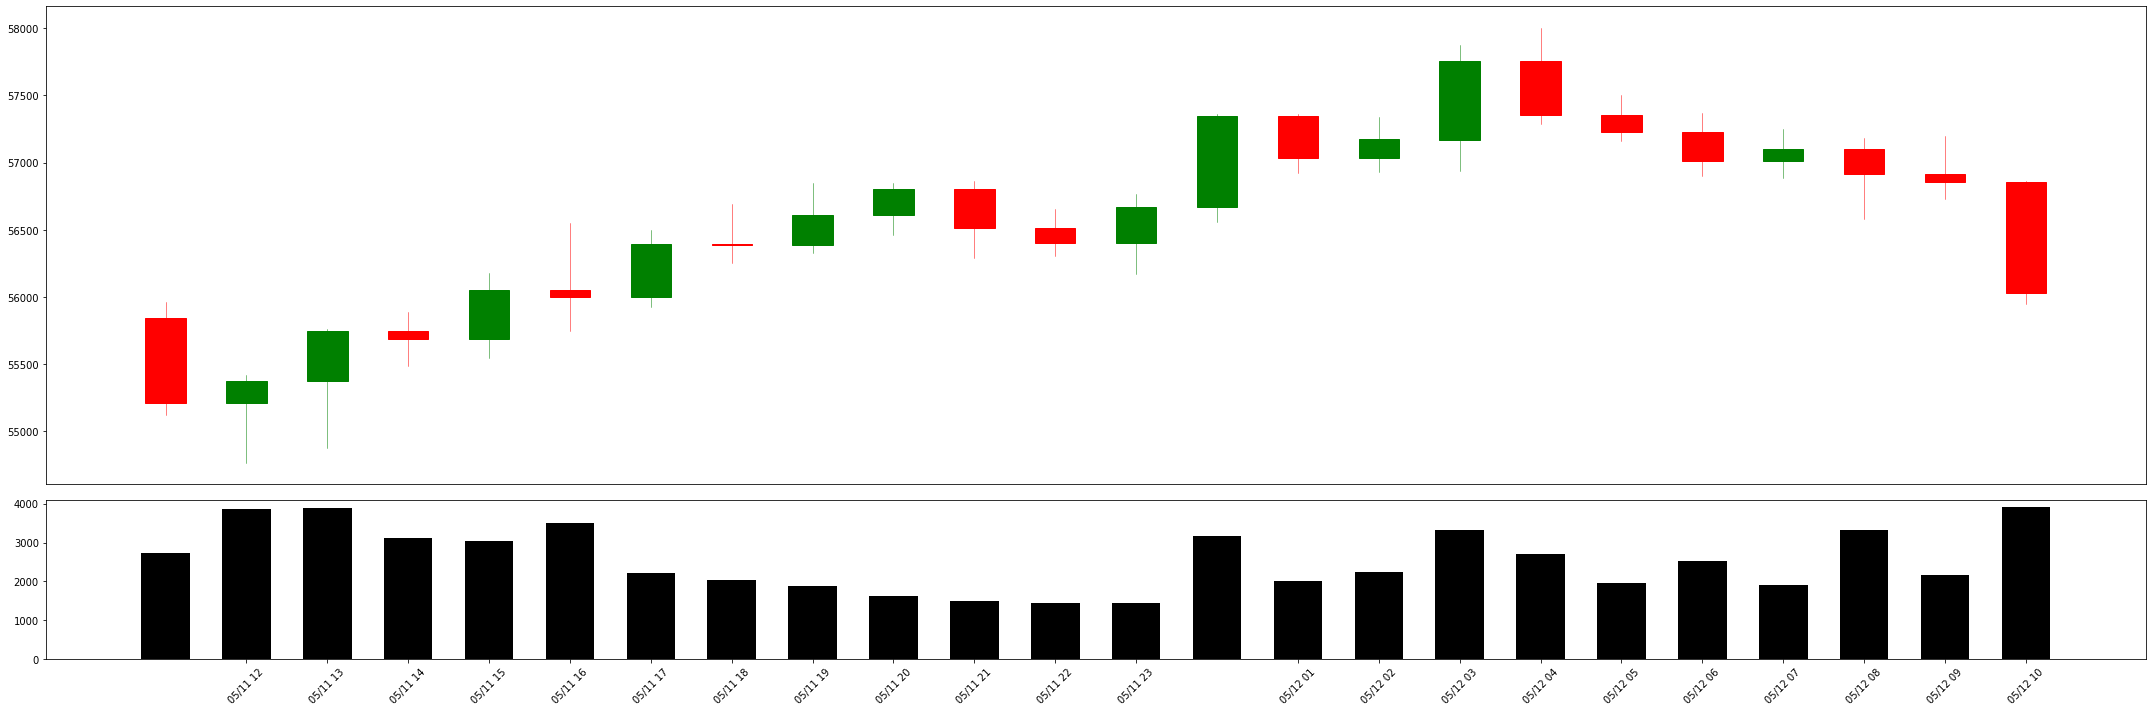

더불어민주당 이용우 의원 "가상자산 정의 및 이용자 보호 장치 필요"
지디넷코리아에 따르면, 더불어민주당 이용우 의원이 가상자산(암호화폐) 정의와 가상자산 거래소 이용자를 위한 최소한의 보호 장치가 필요하다고 지적, '가상자산업법' 제정안을 대표 발의했다. 7일 이용우 의원은 "가상자산 거래는 엄연한 현상으로 존재하기에 가치 논쟁을 넘어 이용자 보호를 위한 명확한 제도적 장치가 필요하다"며 법안 제정 배경을 밝혔다.
뉴스가 올라온 시각 : 2021년 5월 7일 9시 
딥러닝 기반 기사 유사도: 0.8063
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.26%, 악재:0.32%, 중립:98.42%


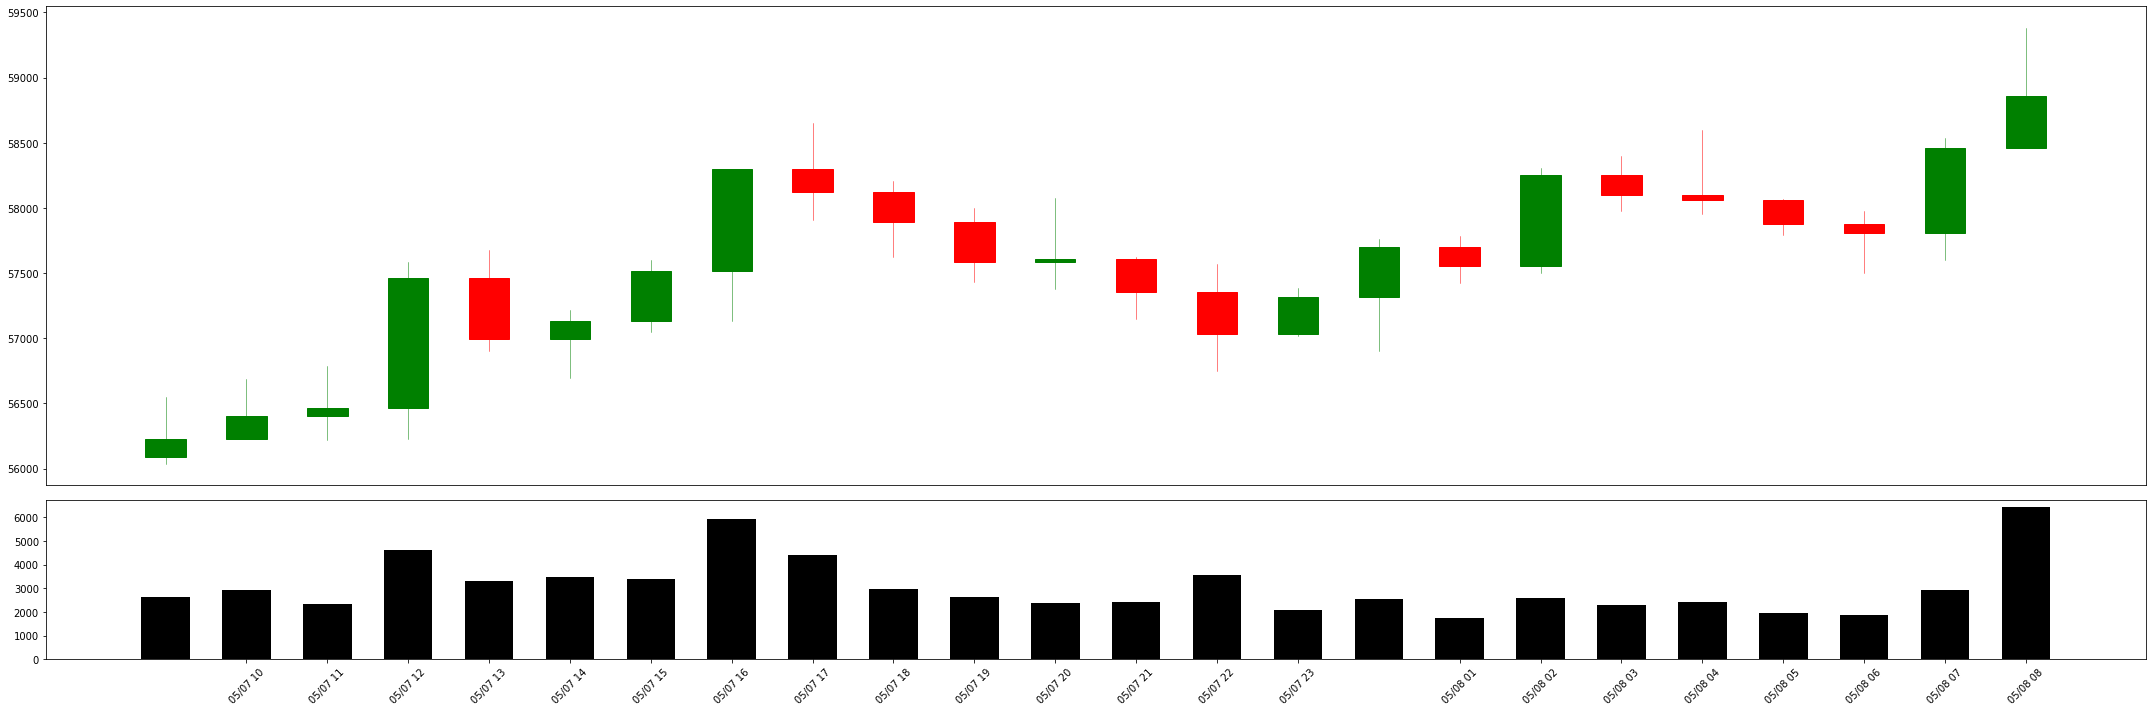

국회 “코인, 공직자도 신고하고 상장·폐지 가이드라인 만들라”
이데일리에 따르면 공직자의 직무 이해충돌 가능성이 있어 가상화폐도 일반 재산처럼 보유현황을 신고토록 의무화해야 한다는 국회 제언이 나왔다. 국회는 아울러 가상자산의 거래소 상장·폐지의 투명성을 높이려면 금융위원회가 가이드라인을 마련해야 한다고 주문했다. 국회입법조사처는 3일 국정감사 이슈분석 보고서에서 가상화폐와 관련한 다양한 지적들을 쏟아냈다. 입조처는 “현행 공직윤리 체계는 각종 이해충돌 방지 제도로 공직자의 재산적 이해충돌을 방지하고 있지만 가상자산 관련 제도는 미흡하다”며 “가상자산 보유현황 신고, 관련 직무로부터의 제척·기피·회피 등 다양한 측면에서 검토해야 한다”고 밝혔다. 가상자산 상장·폐지 과정에 금융당국의 개입 필요성도 언급했다. 입조처는 “부실 가상자산의 정리 과정은 가상자산 시장의 자정작용으로 볼 측면이 있지만 거래소가 투명한 절차와 기준 없이 상장폐지하면 발행업체와 투자자들이 손해를 볼 수 있다”며 “거래소의 상장 및 상장폐지 과정의 투명성 제고를 위해 금융위가 구체적인 가이드라인 마련을 검토해야 한다”고 강조했다.
뉴스가 올라온 시각 : 2021년 8월 3일 11시 
딥러닝 기반 기사 유사도: 0.7995
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.35%, 악재:11.32%, 중립:87.33%


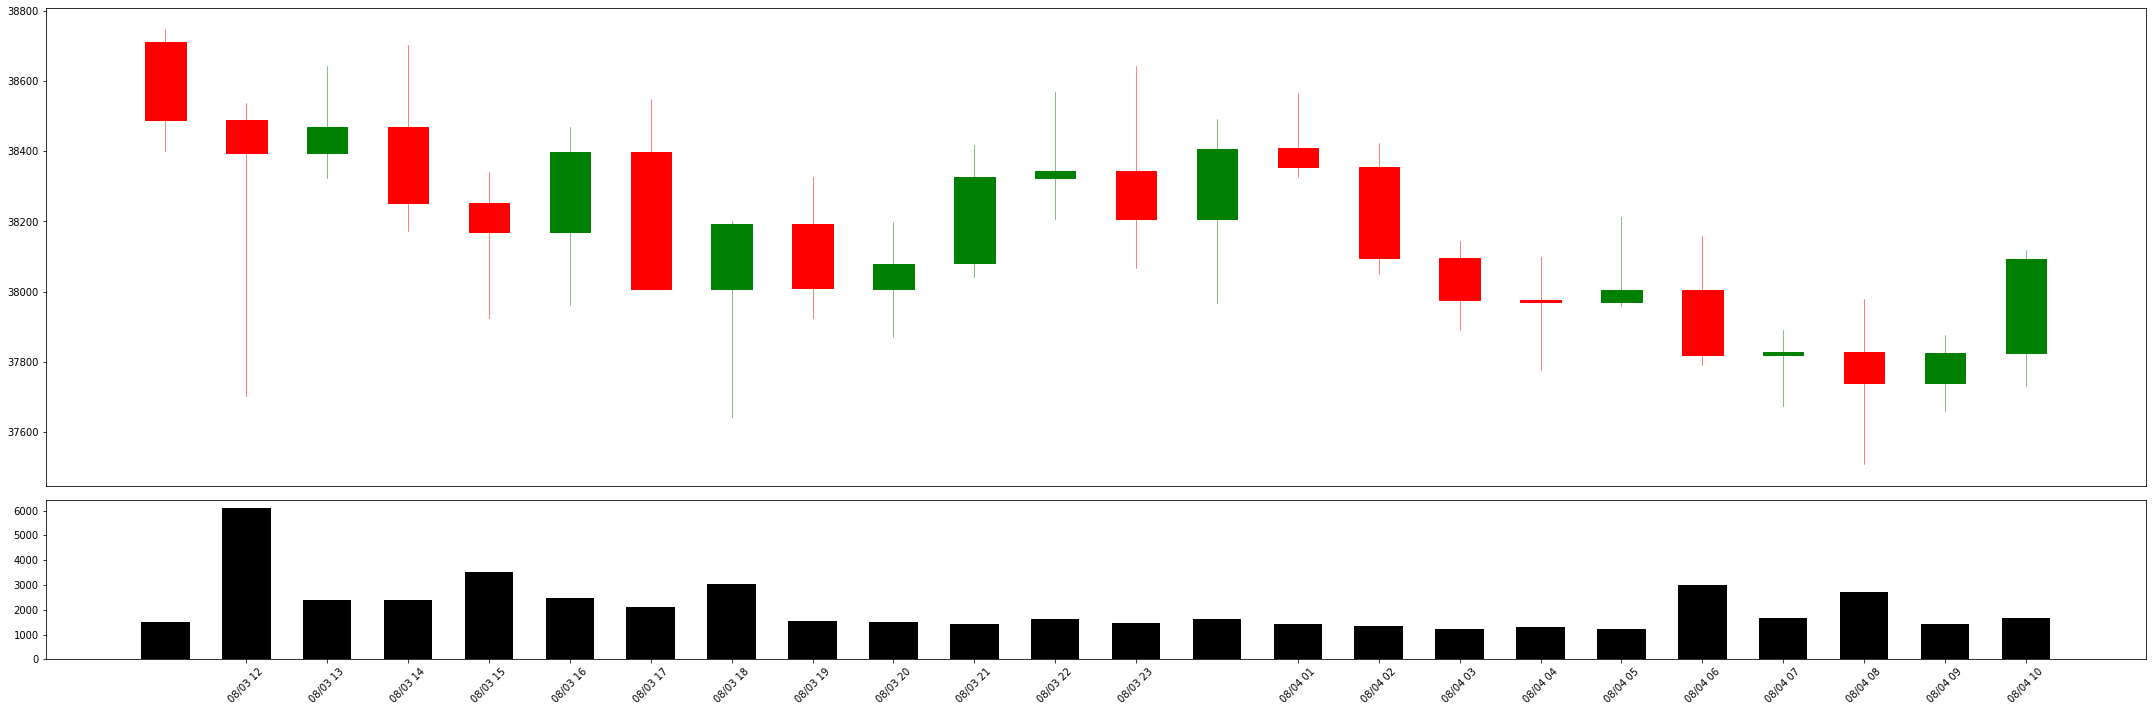

국내 보고서 "코인 백서 따르도록 발행자·취급 업소에 책임 물어야"
연합뉴스에 따르면 가상자산의 사업 정보 등을 담은 백서의 형식을 규정하고, 발행자 등이 백서를 따르도록 제도를 정비해야 한다는 제언이 나왔다. 이순호 한국금융연구원 연구위원은 30일 '가상자산 규제 감독 방향' 보고서에서 이렇게 밝혔다. 이 연구위원은 우선 "가상자산 지상의 진실성, 투명성 등을 높이려면 허위 사실 유포 등의 수법으로 시세를 조종하는 등 불법행위는 철저히 단속하고 사업자의 자격 요건을 강화해야 한다"고 강조했다. 그는 "시장 참여자가 가상자산의 가치를 정확하게 평가하도록 가상자산을 발행할 때 발간하는 백서를 투명하게 공개하도록 해야 한다"며 "백서에 들어가야 할 필수 내용과 형식을 구체적으로 규정해야 한다"고 말했다. 그러면서 "사업 진행이 백서에 나온 대로 진행되지 않으면 그 책임을 발행자와 취급 업소에 물을 수 있도록 제도적 정비가 필요하다"며 "이런 규제 강화는 코인의 수를 줄이겠지만, 다단계나 허위 취급 업소를 통한 사기를 막을 수 있다는 점에서 기본적인 제도"라고 덧붙였다.
뉴스가 올라온 시각 : 2021년 5월 31일 9시 
딥러닝 기반 기사 유사도: 0.7877
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.25%, 악재:0.55%, 중립:99.2%


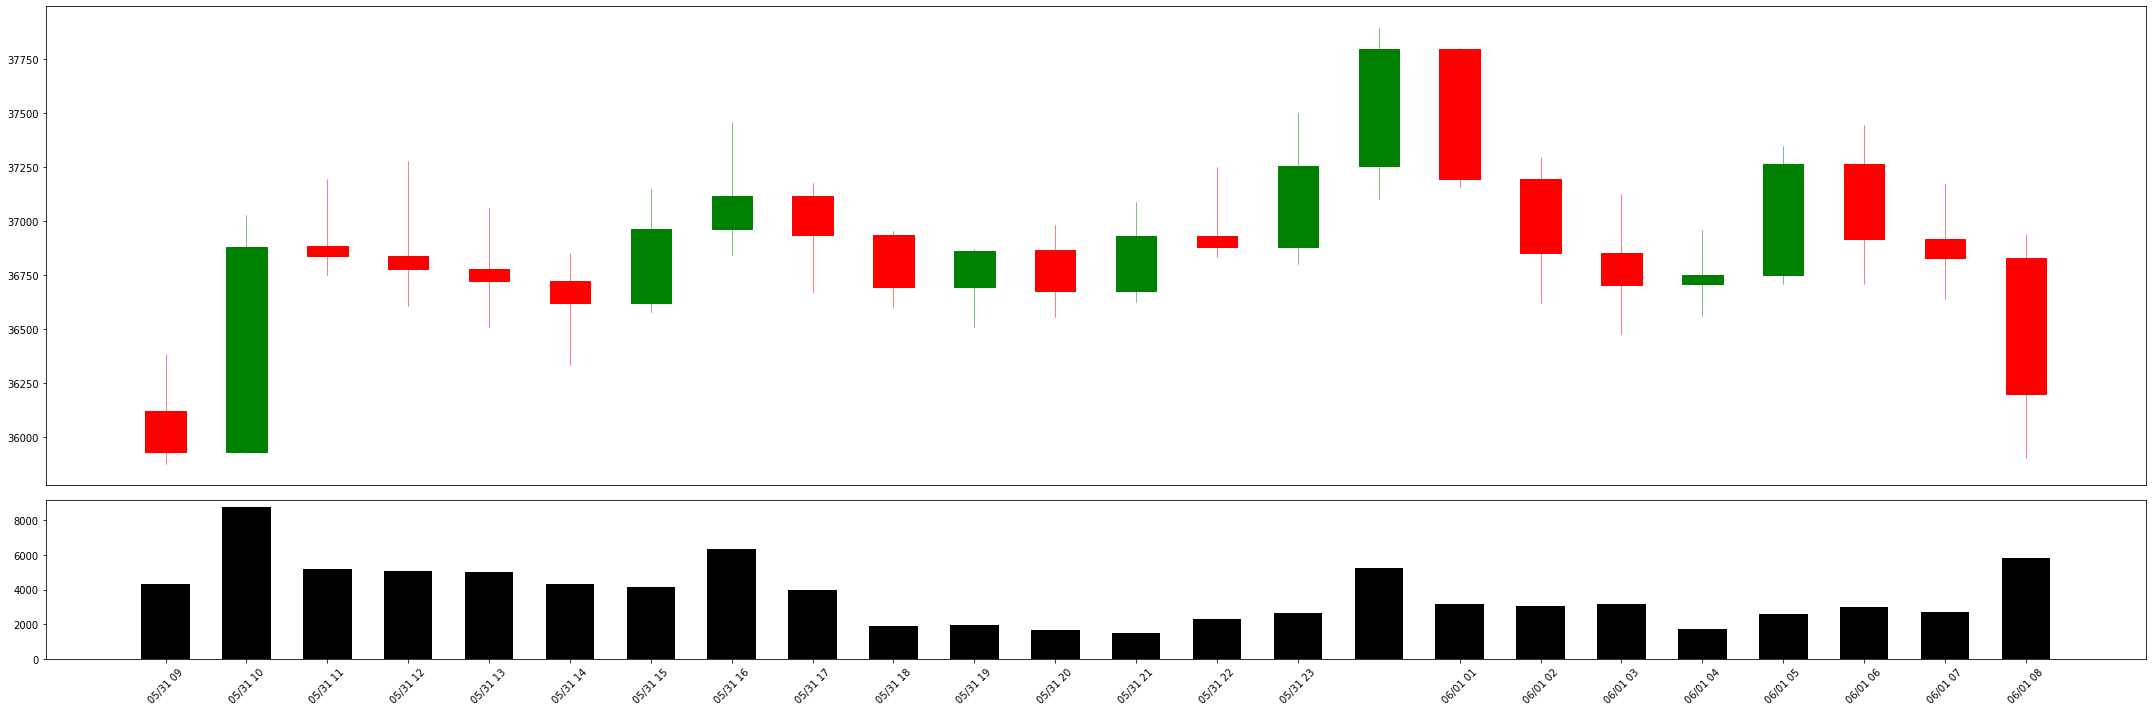

與 김병욱, '가상자산법' 발의…"시세조정 등 불공정행위 시 처벌"
뉴시스에 따르면 김병욱 더불어민주당 의원은 18일 암호화폐(가상자산)을 제도권 내로 편입해 불공정 거래 시 처벌하는 등 이용자 보호를 할 수 있게 하는 내용의 '가상자산법'을 발의했다. 제정안은 가상자산업을 제도권 내로 편입하는 게 골자다. 법안에 따르면 가상자산거래업, 가상자산보관관리업을 할 경우 등록해야 하고, 이를 제외한 가상자산업을 하려면 금융위원회에 신고 절차를 거쳐야 한다. 또 통정매매, 가장매매, 시세조종 등 가상자산 불공정 거래 행위를 금지하기 위해 거래소에서 불공정 거래 행위에 대해 상시 모니터링을 하도록 규정했다. 가상자산사업 행위준칙을 마련해 과장 또는 허위 광고를 금지하고, 이용자들의 알 권리도 보장하도록 했다. 금융위원회 등 금융당국의 감독 또는 업무검사를 통해 위법한 행위가 적발될 경우 등록취소 등을 할 수 있게 하는 내용도 담겼다. 김 의원은 기자회견 후 취재진과 만나 "자칫 모든 권한을 금융위에 주면 금융위는 지금까지 가져온 보수적인 스탠스, 안전 위주로 업무를 처리할 수밖에 없다"며 "그래서 가상자산 거래업자가 금융위 승인이 아닌 금융위 등록을 하게 했다"고 설명했다. 내년 1월부터 부과 예정인 가상자산 양도차익 과세 방침에 대해서는 "당 입장이 정해진 건 아니지만 개인적 생각은 과세는 동의하지만 시점은 주식시장에 대한 과세 시점인 2023년부터 해도 큰 문제가 없지 않겠느냐는 것"이라며 "그동안 가상자산업과 투자자를 보호하는 관련 법과 제도를 준비한 후 투자자들에게 과세하겠다고 하는 게 설득력이 있지 않느냐"고 말했다.
뉴스가 올라온 시각 : 2021년 5월 18일 11시 
딥러닝 기반 기사 유사도: 0.7836
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.87%, 악재:0.67%, 중립:98.46%


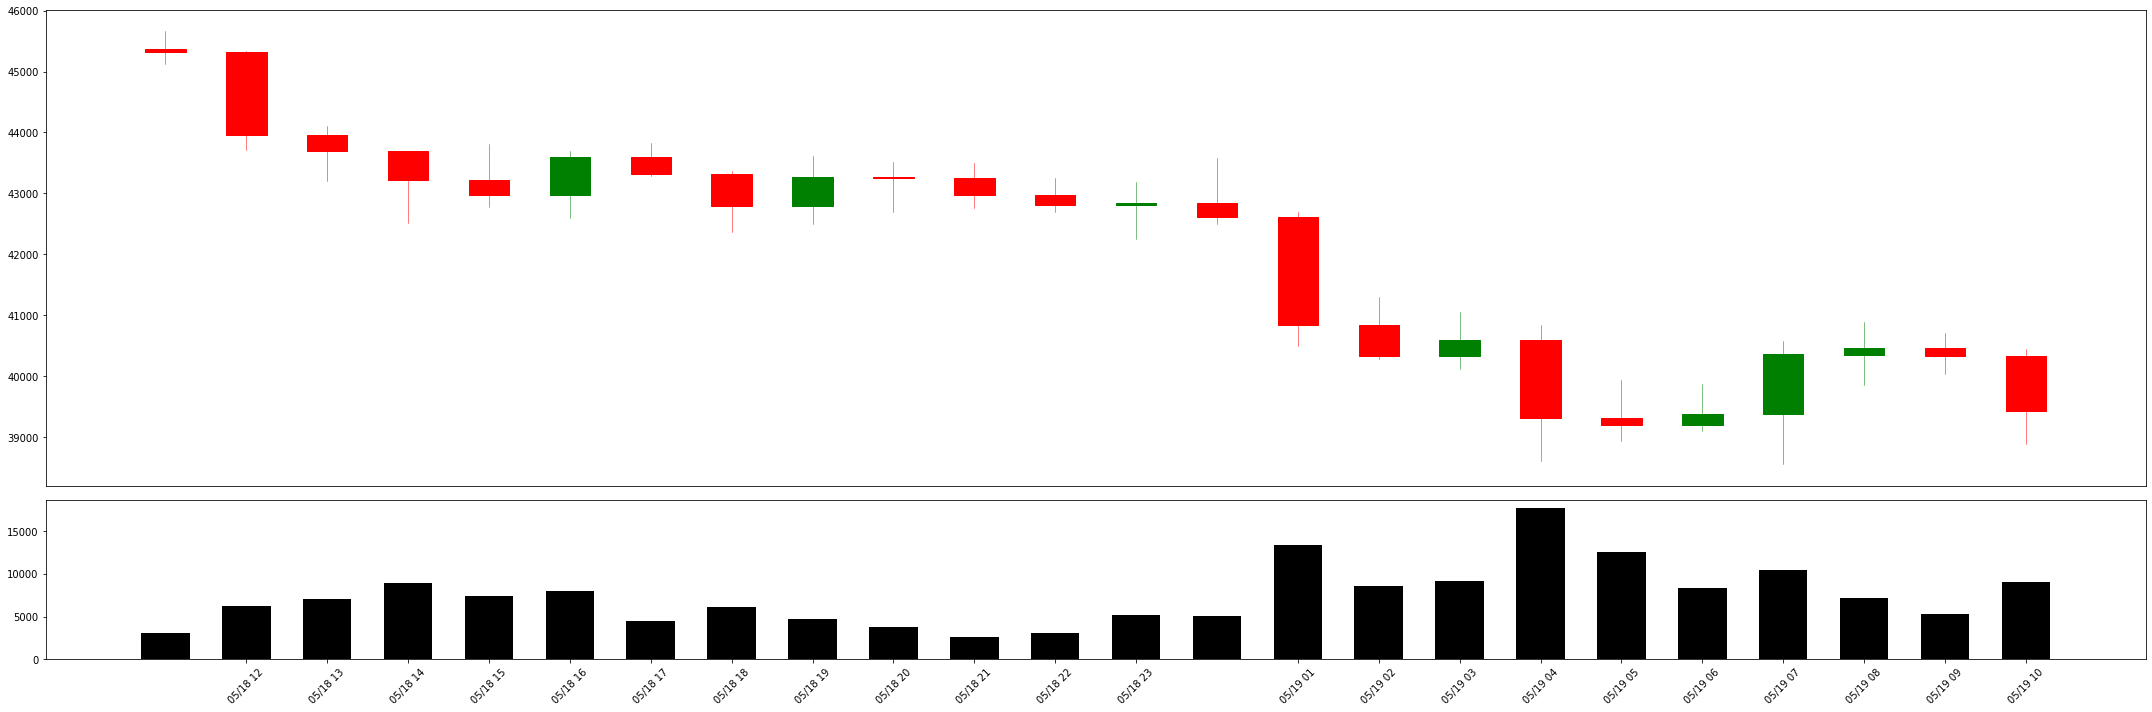

국회입법조사처 "금융위가 가상화폐 불공정 가이드라인 만들라"
매일경제에 따르면 국회입법조사처는 가상화폐 거래소 약관에 대해 공정거래위원회 보다 주무부처인 금융위원회가 가이드라인 제정 등에 나서야 한다고 제안했다. 국회입법조사처는 보고서에서 "거래소 관리·감독의 주무부처인 금융위가 가상자산의 성격을 명확하게 정립하고 구체적인 가이드라인을 조속히 마련해야 할 것"이며 "현재 국회에 제출된 법률안들을 바탕으로 가상화폐 사업자 의무에 대한 법적 기준이 조속히 마련돼야 한다"고 주장했다.
뉴스가 올라온 시각 : 2021년 8월 13일 15시 
딥러닝 기반 기사 유사도: 0.7743
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.42%, 악재:1.5%, 중립:98.08%


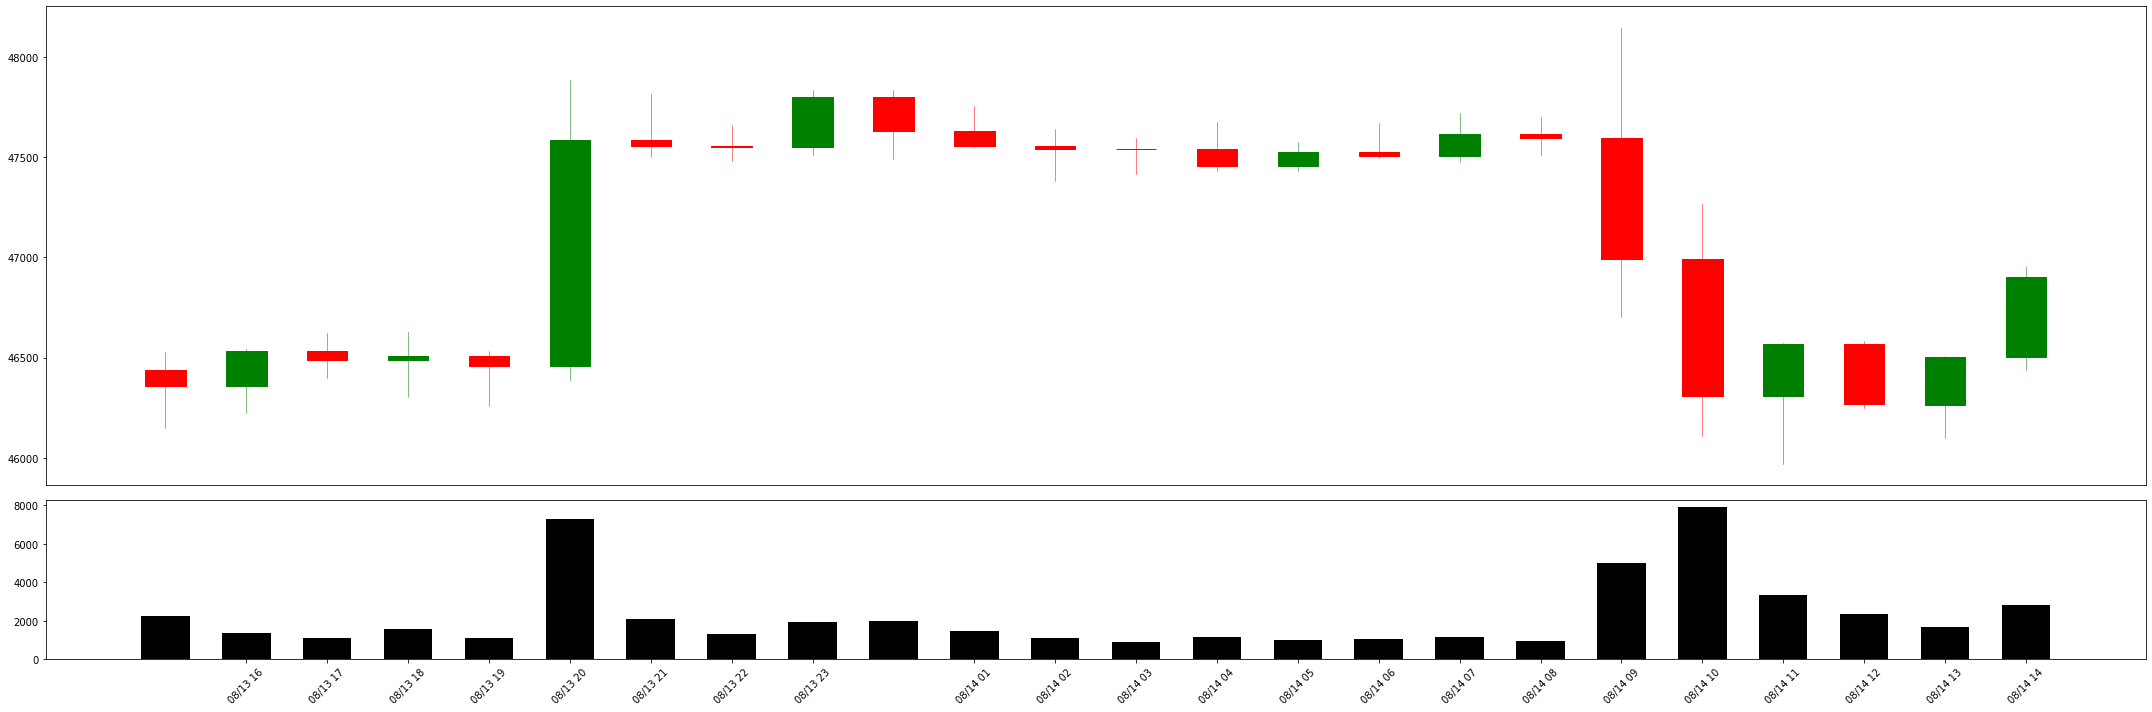

금감원 "가상자산 회계·감사 가이드라인 마련 검토"
데일리안에 따르면 금융감독원이 가산자상 시장 투자자를 보호하기 위해 회계와 감사 가이드라인 마련을 논의하겠다고 27일 밝혔다. 금감원은 오는 28일 한국회계기준원, 한국공인회계사 등과 함께 가상자산 관련 회계감독 이슈를 논의하기 위한 첫 전문가 간담회를 개최하고 이 같은 방안을 논의한다고 설명했다.
첫 회의에서는 가상자산 회계처리 현황과 투자자 보호를 위한 주석공시 강화 필요과제를 주제로 ▲가상자산의 발행 및 (사전)매각 ▲보유 현황 ▲고객위탁 가상자산 관련 정보를 주석공시할지 논의할 계획이다.
뉴스가 올라온 시각 : 2022년 7월 27일 18시 
딥러닝 기반 기사 유사도: 0.7664
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.75%, 악재:0.44%, 중립:98.82%


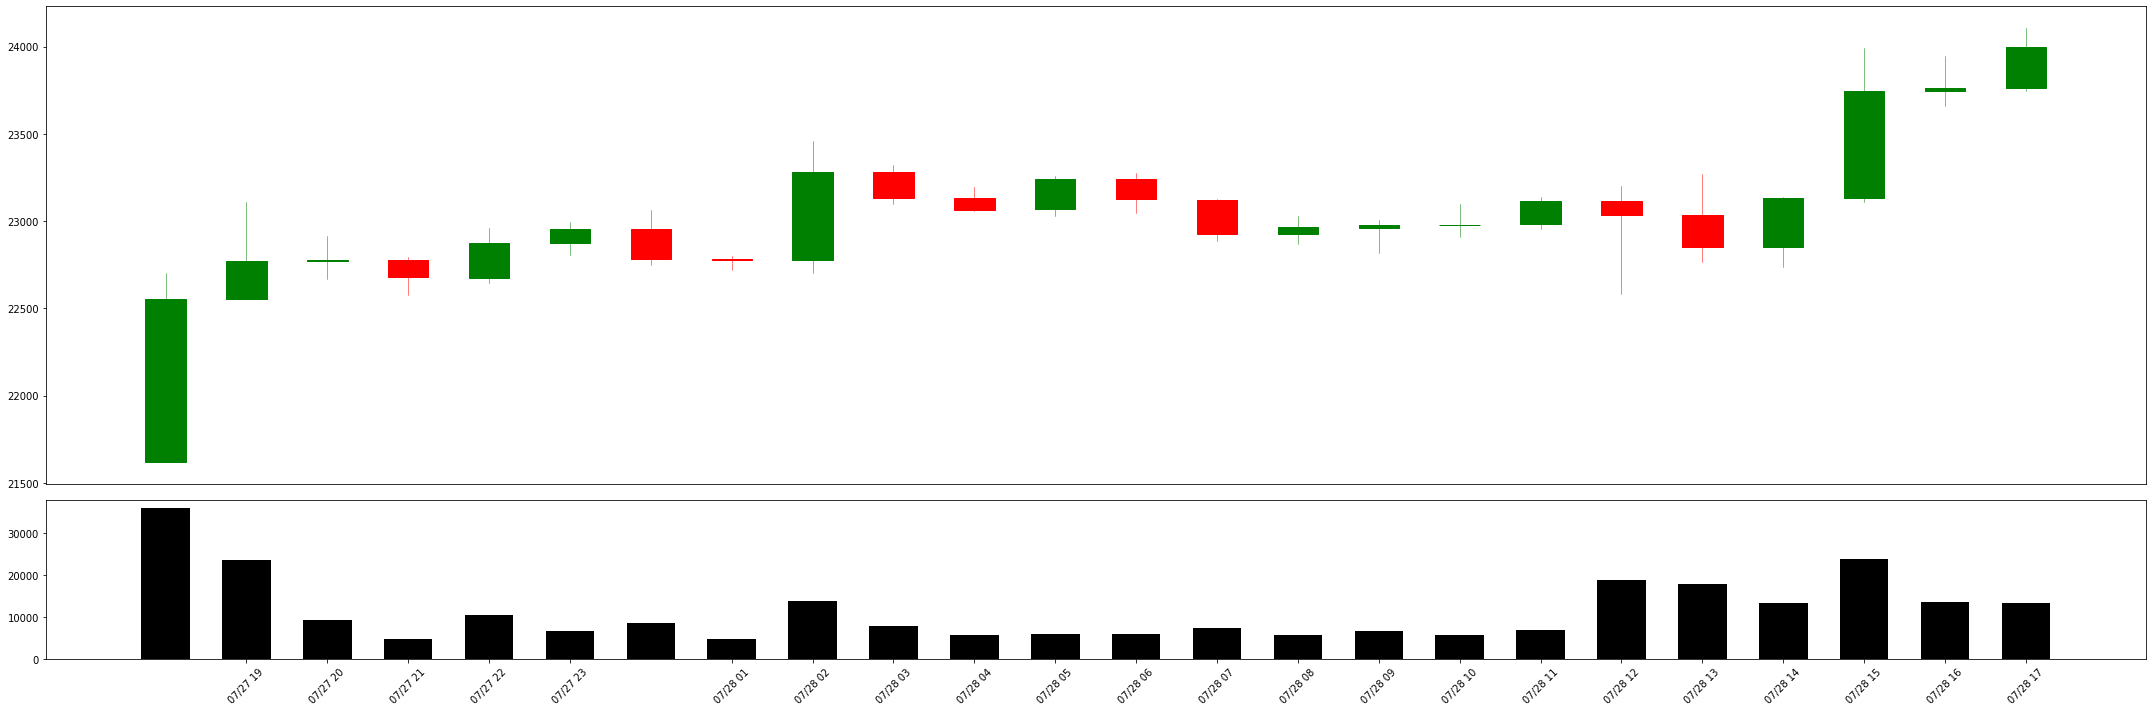

가상자산 관리·감독 금융위...블록체인 육성은 과기부 주관
동아일보에 따르면, 정부가 28일 가상자산(암호화폐) 거래의 투명성을 제고하기 위한 사업자 관리·감독 및 제도 개선을 금융위원회 주관으로 추진한다. 블록체인 기술발전·산업육성은 과학기술정보통신부가 주관한다. 국무총리실은 이날 오후 정부서울청사에서 구윤철 국무조정실장 주재로 관계부처 차관회의를 개최하고 이 같은 내용의 ‘가상자산 거래 관리방안’을 발표했다. 이날 회의에는 기재부·과기정통부·법무부 차관, 방통위·공정위·금융위·개인정보위 부위원장, 경찰청·국세청·관세청 차장 등이 참석했으며, 최근 가상자산 거래 참여자가 급증함에 따라 거래 투명성을 제고할 필요가 있다고 입을 모았다.
뉴스가 올라온 시각 : 2021년 5월 28일 15시 
딥러닝 기반 기사 유사도: 0.7598
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:1.24%, 악재:0.66%, 중립:98.09%


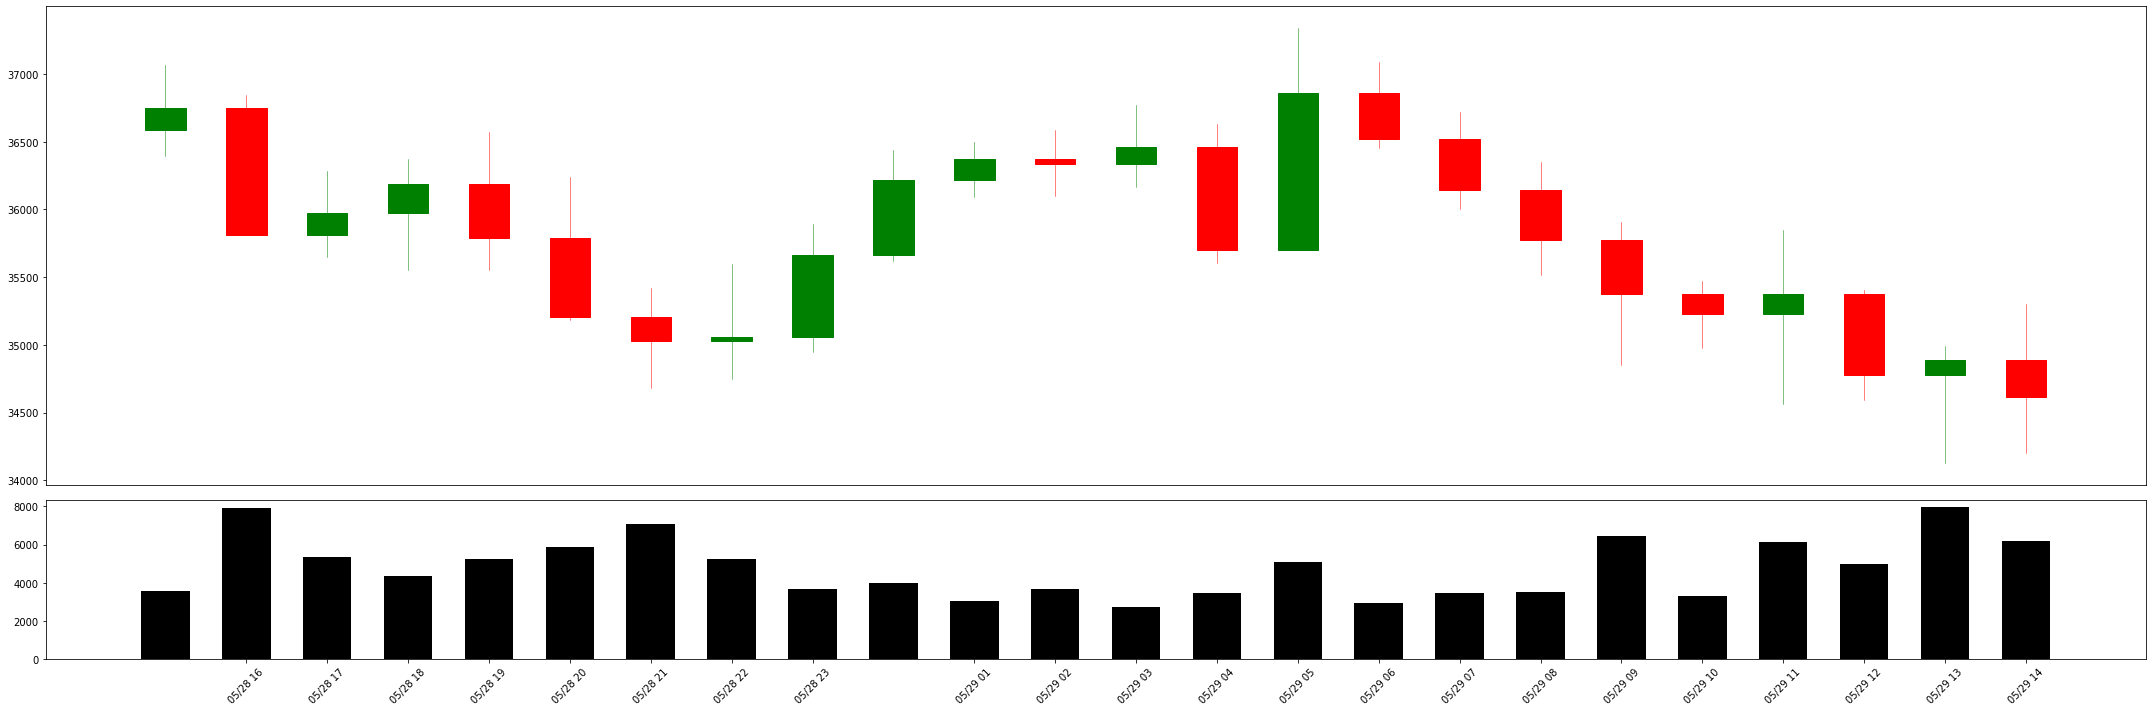

與 신영대 “공직자 비트코인 재산 공개 추진”
중앙일보에 따르면 더불어민주당 신영대 의원이 공직자 재산등록 대상에 가상자산을 포함하는 공직자윤리법 개정안을 25일 발의할 예정이다. 공직자윤리법 내 등록대상재산 항목에 “1000만원 이상의 가상자산”을 추가하는 방식이다. 신 의원은 “최근 비트코인 등 암호화폐의 가치가 급등했고, 재산의 상당 비중을 차지하는 사람도 있다”면서 “가상자산은 자금의 이동 흐름을 추적하기 어려워서 부작용이 우려된다”고 말했다. 25일 특정금융정보법 개정안이 시행되면서 가상자산은 “경제적 가치를 지닌 것으로서 전자적으로 거래 또는 이전될 수 있는 전자적 증표”로 규정된다. 국세청은 지난 15일 가상자산으로 재산 39억원을 숨기고 종합소득세 27억원을 체납해온 의사 A씨를 적발하는 등, 가상화폐 거래소에 재산을 은닉한 2400명을 찾아낸 바 있다.
뉴스가 올라온 시각 : 2021년 3월 25일 9시 
딥러닝 기반 기사 유사도: 0.7569
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:7.96%, 악재:4.6%, 중립:87.43%


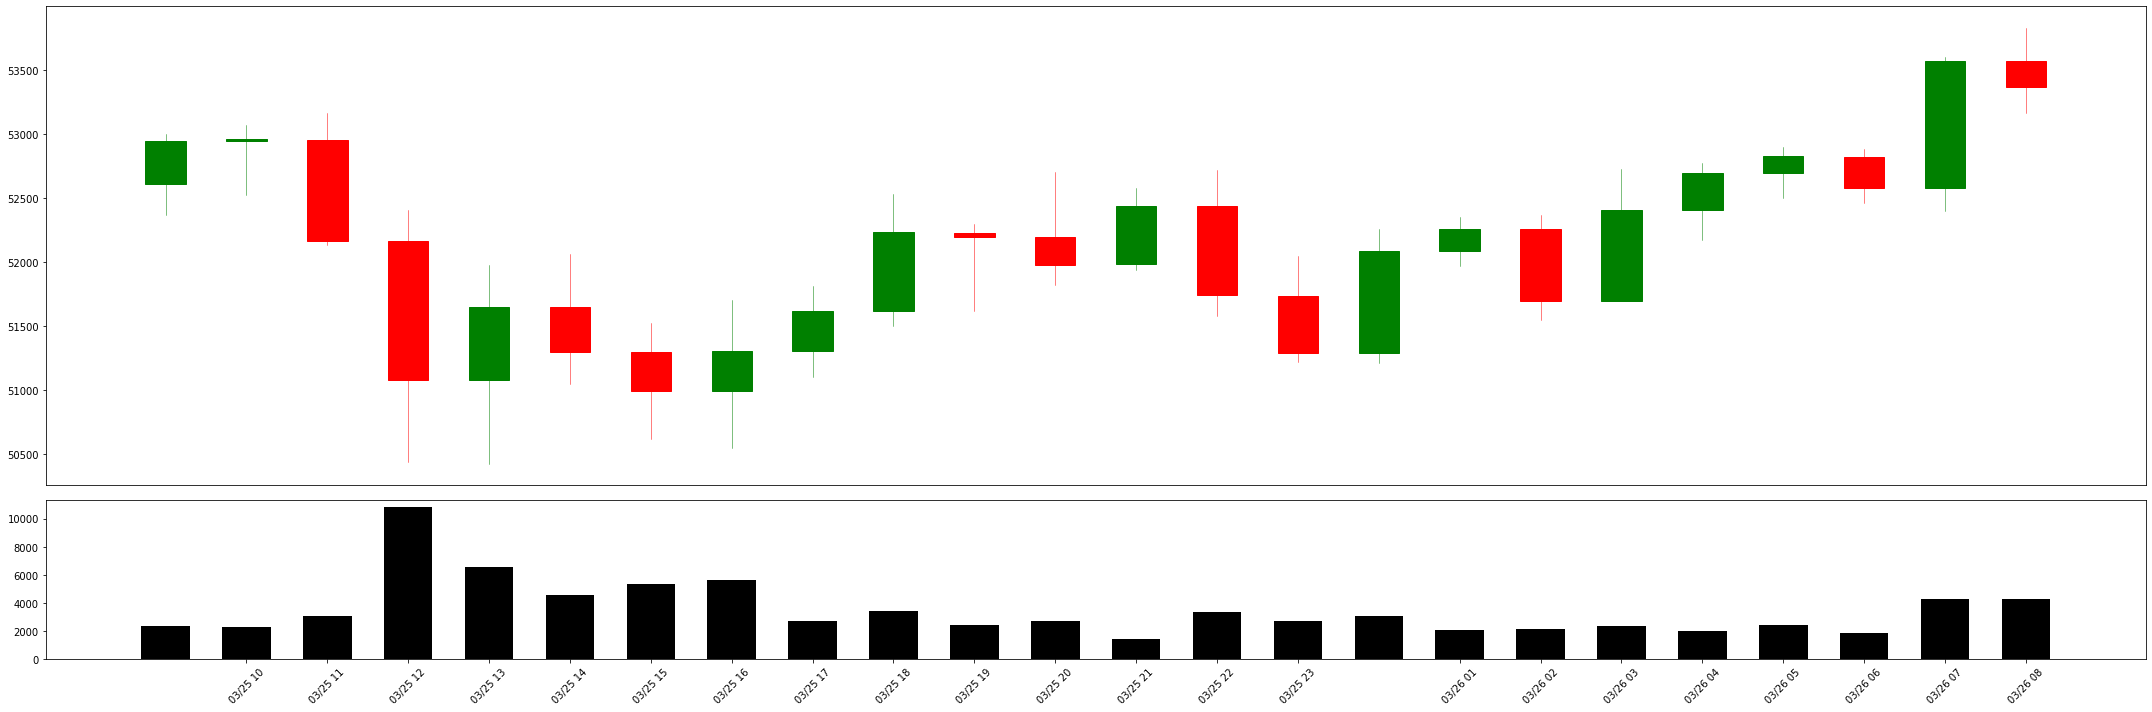

금융위 "코인 거래소, 내부통제 마련 의무 충실히 이행했는지 점검할 것"
뉴스1에 따르면, 8일 금융위원회가 '가상자산거래소들의 이해관계 상충 행위에 대한 추후 감독계획'을 묻는 국회 정무위원회 소속 김성주 더불어민주당 의원실의 서면 질의에 "현행 특정금융정보법(특금법)은 제한적 범위에서 가상자산사업자의 이해상충 문제를 규율하기 위한 규정을 두고 있다"며 "해당 법의 입법 목적이 자금세탁방지이기 때문에, 사업자의 이해상충 문제를 직접 금지하지 못하고 내부통제 마련 의무 부과 등을 통해 간접 규율한다"고 답했다. 이어 "향후 검사 시 사업자가 내부통제기준 마련 의무 등을 충실히 이행했는지 면밀히 점검하겠다"고 밝혔다. 특금법 시행령에 따르면 가상자산 거래소는 사업자 본인 및 특수관계인이 발행한 가상자산 거래를 제한하는 기준을 마련해야 한다. 가상자산 거래소 임직원이 해당 거래소에서 매매하는 행위도 제한된다.
뉴스가 올라온 시각 : 2022년 9월 8일 16시 
딥러닝 기반 기사 유사도: 0.7491
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:0.22%, 악재:0.42%, 중립:99.36%


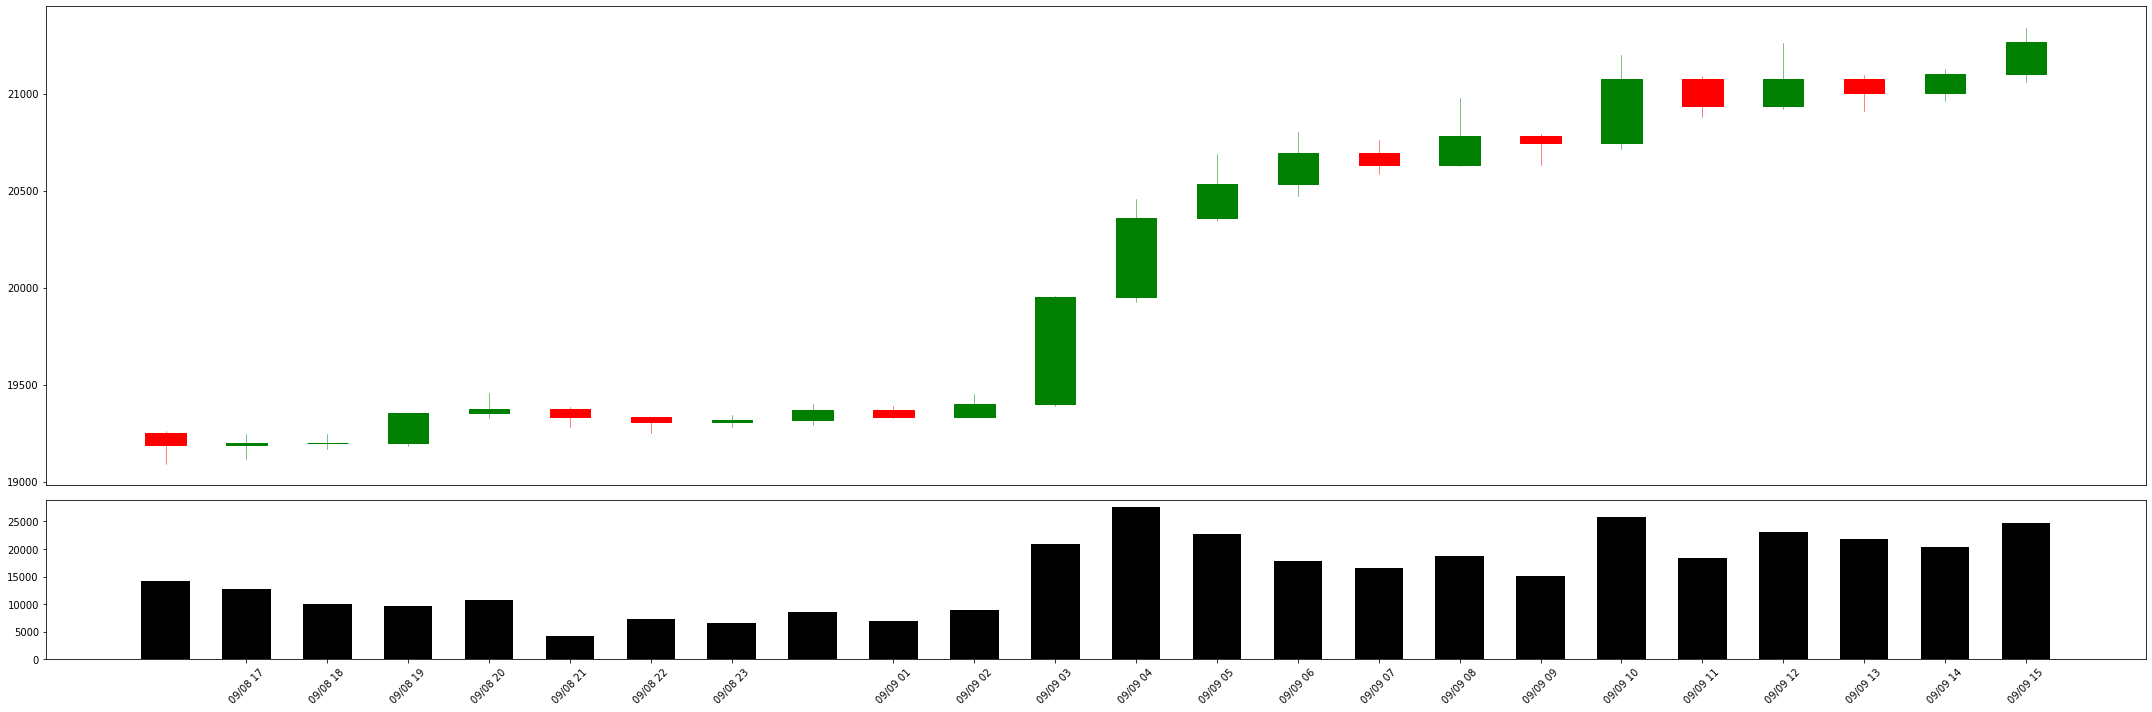

In [21]:
title = str(input("뉴스 제목을 입력하세요: "))
content = str(input("뉴스 기사를 입력하세요: ")) 

get_rank_results(title, content) 

# Example 4

뉴스 제목을 입력하세요:  [코인니스 오리지널] 코인으로 부동산 거래하는 시대가 오고 있다
뉴스 기사를 입력하세요:  앞으로는 옥석이 될 만한 가상화폐 사업을 찾는 것이 점점 더 중요해질 것이다. 글쓴이는 앞으로 금융자산 또는 실물 자산을 토큰화 시키는 STO(증권형 토큰) 사업이 가장 큰 가상화폐 시장에 핵심 사업으로 자리 잡을 것이라고 생각한다. 오늘은 STO 중에서도 한국인이 가장 사랑하고 열광하는 실물 자산인 부동산을 토큰화 시켜 거래하는 신규 가상화폐 사업에 대해서 소개하고 현재 해당 산업이 우리에게 어느 정도 다가왔는지 전달하고자 한다.


104826 개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.
============================== query ==============================
[코인니스 오리지널] 코인으로 부동산 거래하는 시대가 오고 있다
앞으로는 옥석이 될 만한 가상화폐 사업을 찾는 것이 점점 더 중요해질 것이다. 글쓴이는 앞으로 금융자산 또는 실물 자산을 토큰화 시키는 STO(증권형 토큰) 사업이 가장 큰 가상화폐 시장에 핵심 사업으로 자리 잡을 것이라고 생각한다. 오늘은 STO 중에서도 한국인이 가장 사랑하고 열광하는 실물 자산인 부동산을 토큰화 시켜 거래하는 신규 가상화폐 사업에 대해서 소개하고 현재 해당 산업이 우리에게 어느 정도 다가왔는지 전달하고자 한다.
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:33.39%, 악재:0.33%, 중립:66.27%





============================== candidates ==============================
[NFT, 아트, 작가, 만나다②] 한규훈 작가 “NFT는 새로운 수단이 될 것”
대체불가토큰(NFT) 시장의 폭발적인 성장을 이끌어온 것은 예술, 미술품 등 아트 시장이다. 높은 가치와 희소성이 보장된 예술·미술품은 NFT로 제작하기에 안성맞춤이었고, 수십, 수백 년 동안 이어진 아트 시장의 고착화된 유통 구조는 변화가 필요한 시점이었다. 서로의 필요에 의해 NFT와 아트는 만났고, 비상했다. 이것들은 엄청난 시너지를 발휘하며 무섭게 성장했다.
무엇인가 무섭게 성장하면 곧 따라오는 말은 ‘거품(버블)’이다. 아트 NFT도 마찬가지다. 지난 2021년 무서운 성장세를 보였던 만큼 아트 NFT에 대한 본질에 대한 의문이 나오고 있다. 우리는 지금까지 이에 대해 블록체인이라는 기술적인 측면과 ‘암호화폐처럼’ 가치가 오를 것이라는 투자의 시선으로 아트 NFT를 바라봤다.

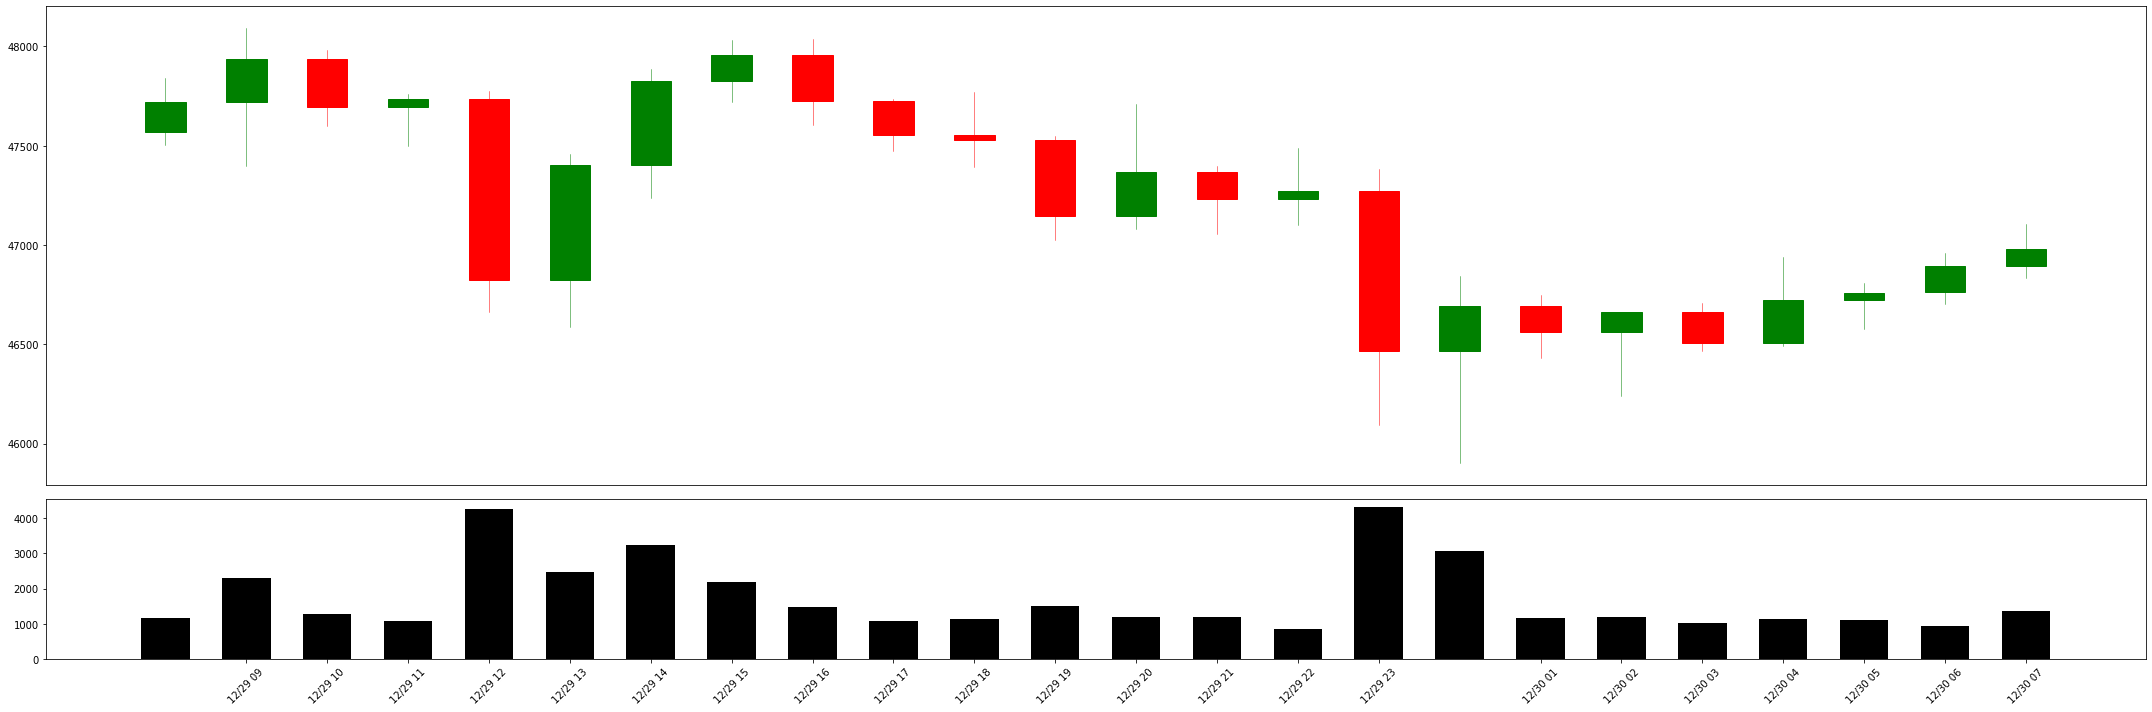

[인터뷰] 샘 리 코인스트리트 CEO "토큰화 자산, 새로운 투자 지평 열 것"
"토큰화 자산은 전 세계에 공정한 투자 기회를 제공하고 기업의 자금 조달 문제를 해결할 수 있습니다"
차세대 탈중앙화 투자은행 코인스트리트파트너스(Coinstreet Partners)의 설립자 겸 CEO 샘 리(Sam Lee)는 20년 이상의 경력을 가진 기업가로, 블록체인, 암호화폐, 인공지능, 사물인터넷 등 다양한 분야에서 성공적으로 벤처사업을 이끌어왔다.
지난 11월 열린 세계 최초 토큰화 자산 및 디지털 증권 부문 국제 시상식 'TADS(Tokenized Assets & Digitalized Securities) 어워드'의 조직 위원장으로 활약하기도 했다.
이와 관련해 본지 토큰포스트와 자매지 이코노타임즈, 국내 블록체인 미디어 솔루션 기업 퍼블리시(PUBLISH)는 TADS의 글로벌 앰배서더이자 미디어 파트너로 협력하고 있다.
통합된 차세대 탈중앙 투자 은행을 구축하며, 새로운 토큰 경제 기반 비즈니스 생태계를 조성하고 있는 샘 리 코인스트리트 대표를 블록체인 전문미디어 토큰포스트가 만났다.

토큰포스트 주요 기사를 뉴스레터를 통해 만나보세요 (구독하기)

 
Q1. 코인스트리트에 대한 소개 부탁드립니다.

코인스트리트는 전 세계 투자자에게 공정한 기회를 제공하고 기업의 자금 조달 문제를 해결하겠다는 비전을 가지고 설립됐습니다.
일반 자금 조달 시장에서는 대형 펀드, 금융 기관, 기업들이 자금 조달과 투자 기회 측면에서 많은 혜택을 갖게 됩니다. 이같은 불균형 문제를 핀테크와 디지털 자산이 완화할 수 있습니다.
코인스트리트는 이러한 변화를 위한 지원자, 조력자, 촉진자로 자리하고 있습니다.
 
Q. 어떤 계기로 자산 토큰화 및 디지털 증권 시장에 참여하게 되셨나요?
90년대에는 인터넷이 세상을 혁신했습니다. 누구나 손쉽게 디지털 통신, 정보, 미디어, 엔터테인먼트, 교육, 소셜미디어에 접근할 수 있게 됐죠.
이제 인터넷보다 더 강력한 모멘텀을 가진 또 다른 혁신이 시작됐습

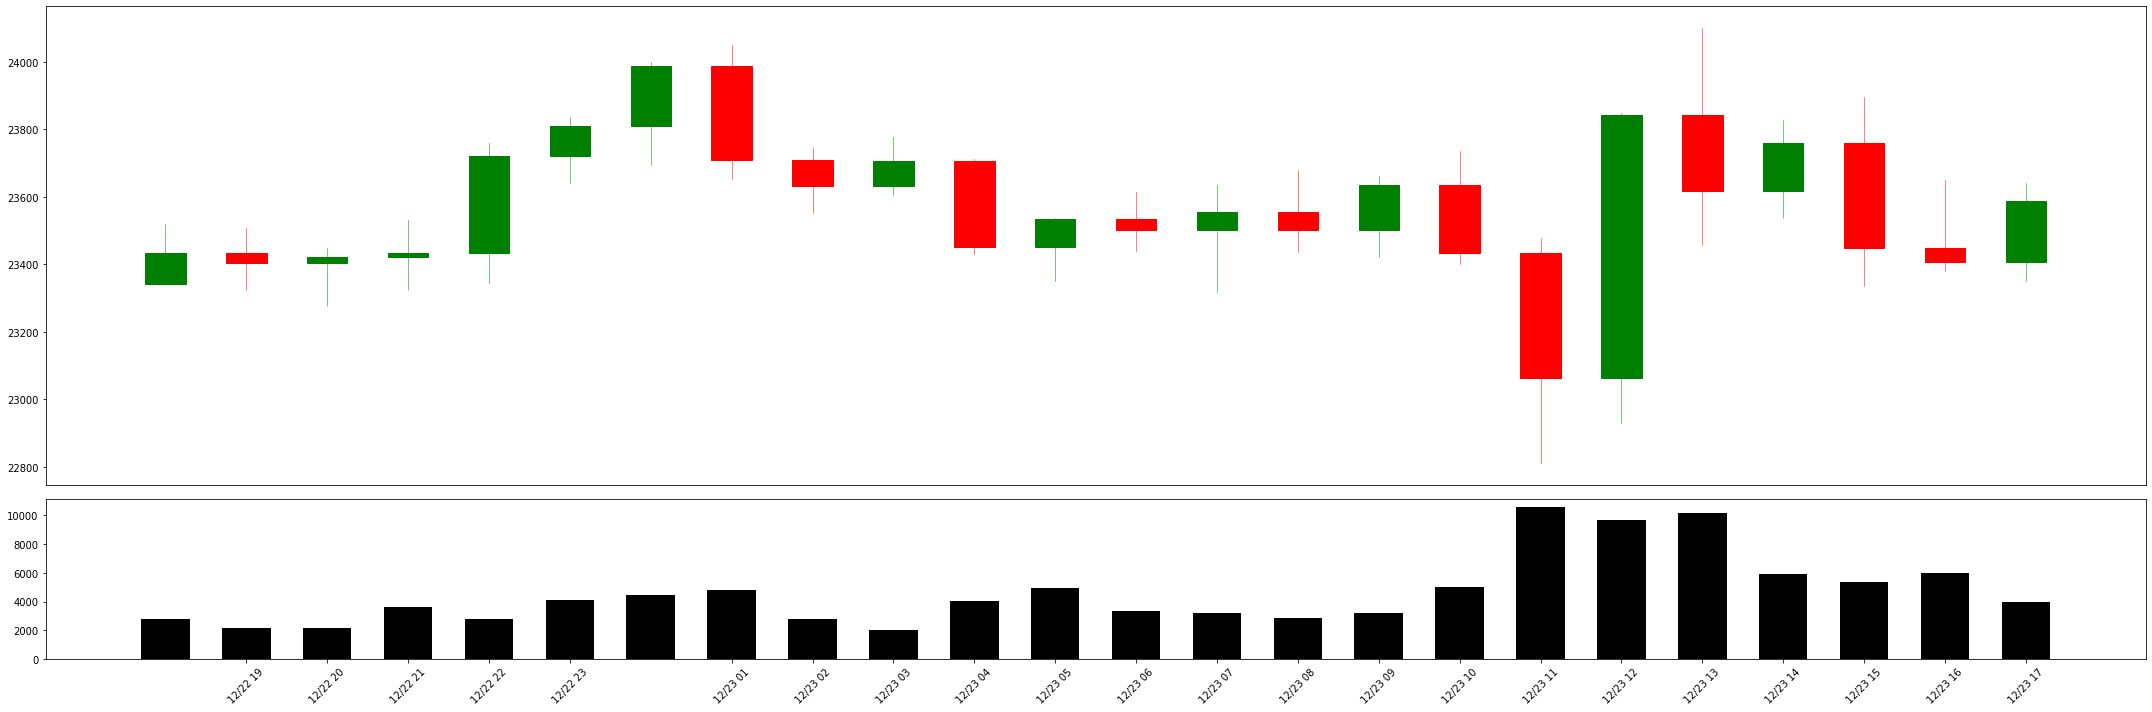

[토큰포스트 인터뷰] 스캐넷체인 CEO 데이비드 함 "증강현실의 실용화, 불가능했던 경험이 가능해진다"
"아이패션과의 파트너십은 스캐넷체인 서비스의 실생활 도입을 의미합니다. AR, 스캔‧검색 기능을 쇼핑과 접목해, 오프라인 상점에서 새로운 경험을 제공할 뿐더러 스캔을 한 후 바로 온라인에서 구매할 수 있습니다. 이전까지 불가능했던 경험들이 가능해지고, 새로운 가치와 패러다임을 제시하게 됩니다."
스캐넷체인(Scanetchain)의 CEO 데이비드 함(David Ham)의 발언이다.
스캐넷체인은 NEM 블록체인 기반으로 개발된 상용화 AR(증강현실) Dapp(Decentralized application)으로 업계의 주목을 받고 있다. 지난 9월 스위스 스마트폰 개발업체인 시린랩스(Sirin Labs)와 상호간 라이선스 계약 체결을 공식 발표하는 등 사업 확장에 박차를 가하고 있으며, 10월 15일에는 'BTCC코리아(대표 이재범)'와 포괄적인 업무제휴 협약을 체결한 바 있다.
스캐넷체인의 데이비드 함을 블록체인 전문미디어 토큰포스트가 만났다. 인터뷰 전체 내용은 영상을 통해 확인할 수 있다.
 
Q. BTCC코리아와의 파트너십에 대해 설명 부탁드립니다.
BTCC가 한국 론칭을 앞두고 있습니다. 출시 과정에서 스캐넷체인이 인지도 부분에서 많은 도움을 제공할 예정입니다. 우리 입장에서는 업계 초기 개척자 중 하나인 BTCC와 일할 기회임과 동시에, 스캐넷체인의 서비스를 더 많은 이들에게 알릴 수 있을 것으로 기대합니다.
Q. BTCC코리아 출시에 도움을 주는 만큼, 해당 거래소에 SWC 토큰이 상장될 가능성도 있나요?
오늘 확실한 답변을 드릴 수는 없습니다. BTCC와의 협약이 여러 방면에서 큰 힘이 되는 것은 맞습니다. 그러한 이유에서 BTCC 거래소 상장에 대한 전조라고 생각할 수도 있겠네요. BTCC코리아와 스캐넷체인 관련 소식은 추후 공지하도록 하겠습니다.
Q. 스캐넷체인의 SWC 토큰 세일은 어땠나요?
아주 성공적으로 마무리됐습니다. 시장이 주춤하고 있

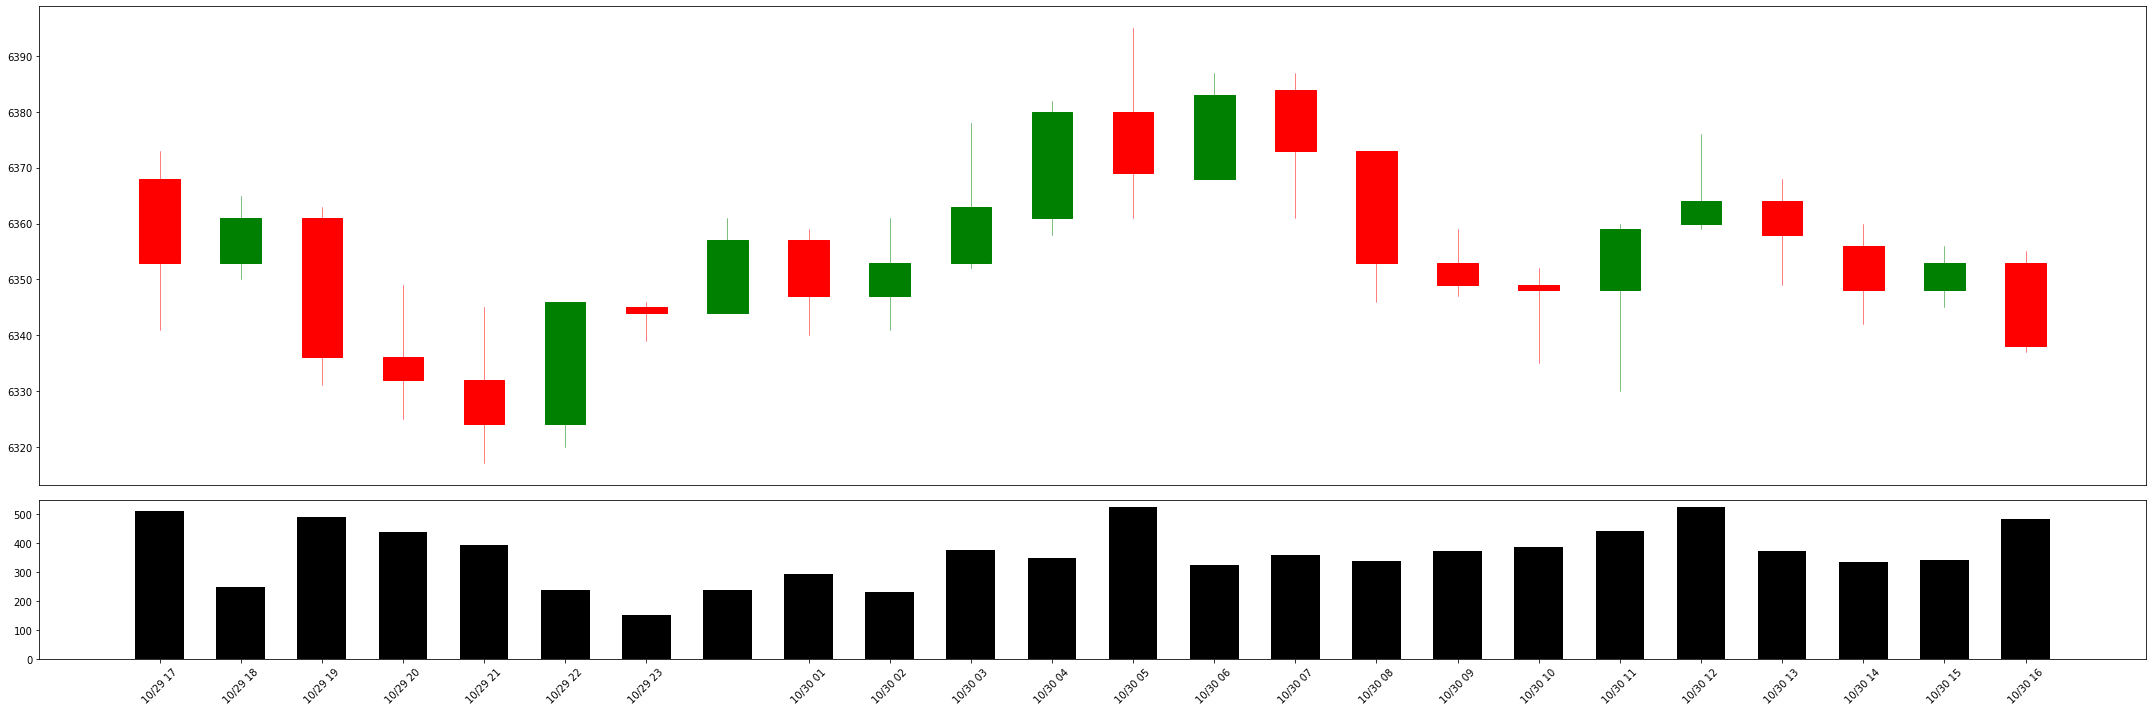

[토큰포스트 인터뷰] 드림체인 회장 피에트로 도란 “드림체인 로고, 전 세계 부동산 정보를 가졌다는 뜻”
"드림체인은 혁명이 아닙니다. 아무도 이해 못하는 새로운 개념을 시장에 소개하고 싶지 않습니다. 부동산 시장은 독점이라고 불려도 무방할 단일 구조로, 40년 동안 유지돼왔어요. 이 시장을 2G 핸드폰이라고 한다면 블록체인 기술과 토큰의 도입으로 5G로 끌어올릴 수 있죠. 이것이 우리가 추구하는 변화입니다."
드림체인(DREAM Chain)의 피에트로 도란(Pietro A Doran) 회장의 발언이다.
드림(DREAM)은 탈중앙 부동산 앱 메타플랫폼(Decentralized real estate application metaplatfrom)의 약자로, 유서 깊은 부동산 시장에 최첨단 기술인 블록체인을 결합하는 것을 목표로 한다. 블록체인에 기반해 부동산 커뮤니티를 연결함으로써 정보와 자본을 교환‧이동하는 세계 최대 탈중앙 부동산 플랫폼을 꿈꾸고 있다.
드림체인의 피에트로 도란 회장을 블록체인 전문미디어 토큰포스트가 만났다. 인터뷰 전체 내용은 영상을 통해 확인할 수 있다.
 
Q. 예전 인터뷰 당시 블록체인 산업에 회의적인 입장이었는데, 지금도 유효한가요?
다소 오해가 있는데, 지금껏 제안 받은 프로젝트들의 블록체인 도입 방식에 회의적이었습니다. 대부분의 ICO 백서들이 실질적 요소보다 개념적 요소를 중심으로, ‘추후’ 도입을 전제로 구상한 모델들이어서 회의적이라는 느낌이 전해졌을 겁니다.
Q. 부동산 업계의 많은 프로젝트들이 추구하는 '소유권 분산화'가 실현 가능할까요?
부동산 소유권 분산화라는 개념을 굳건히 믿고 있지만, 타이밍이 중요합니다. 저는 35년 간 부동산 업계에 종사했고, 투자자이자 개발자였습니다. 부동산의 금융증권화는 새롭게 등장한 개념은 아니지만, 토큰화를 적용한다는 점이 새로운 부분이죠.
자산의 토큰화는 파생품의 파생품을 생성하는 것이라고 생각하면 됩니다. 현재까지 도입되지 못한 이유는 이를 뒷받침할 법적 규제안이 존재하지 않았기 때문입니

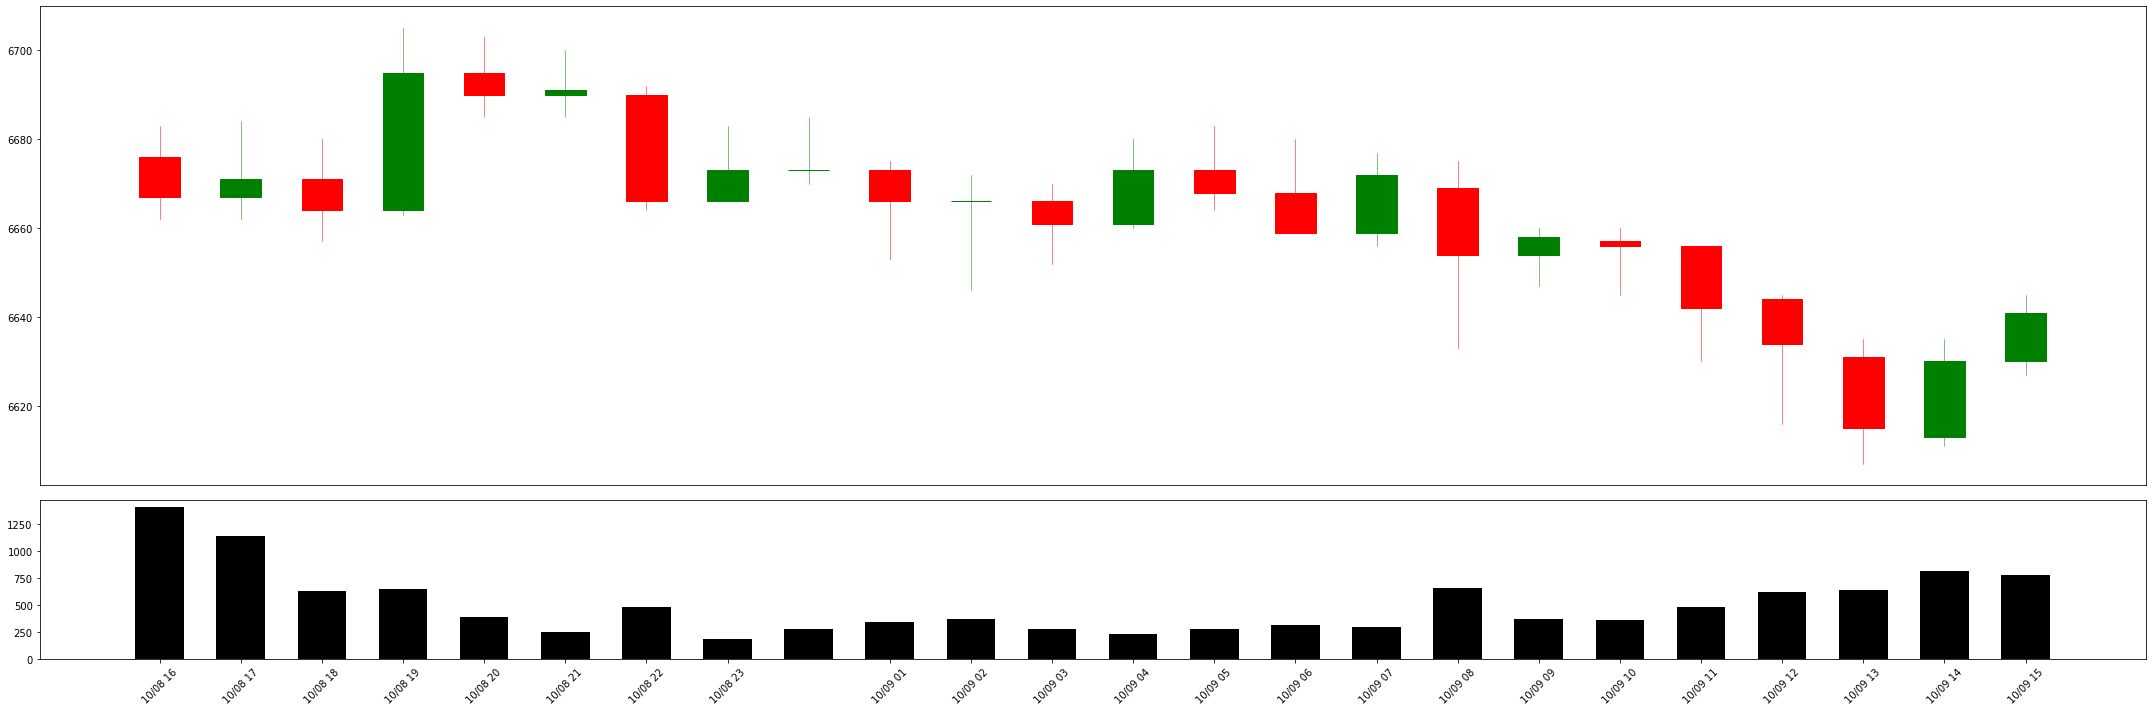

그레이스케일 CEO "메타버스·암호화페 융합 계속된다"
비즈니스인사이더에 따르면, 세계 최대 암호화폐 자산운용사 그레이스케일의 최고경영자 마이클 소넨샤인(Michael Sonnenshein)이 미디어와의 인터뷰에서 "가상현실, 게임, 암호화폐 사이에 지속적인 융합이 이루어지고 있다"면서 "그레이스케일 디센트럴랜드 트러스트가 메타버스 투자 기회를 제공할 것"이라고 말했다. 그레이스케일 디센트럴랜드 트러스트는 메타버스 플랫폼 디센트럴랜드(MANA)에 대한 노출을 제공한다. 소넨샤인은 투자자들이 메타버스에 노출되는 가장 순수한 방법은 해당 애플리케이션의 네이티브 토큰을 보유하는 것이라면서, 디센트럴랜드, 블록토피아, 스타아틀라스 등을 예로 들었다.
뉴스가 올라온 시각 : 2021년 11월 16일 21시 
딥러닝 기반 기사 유사도: 0.7455
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:34.31%, 악재:0.09%, 중립:65.6%


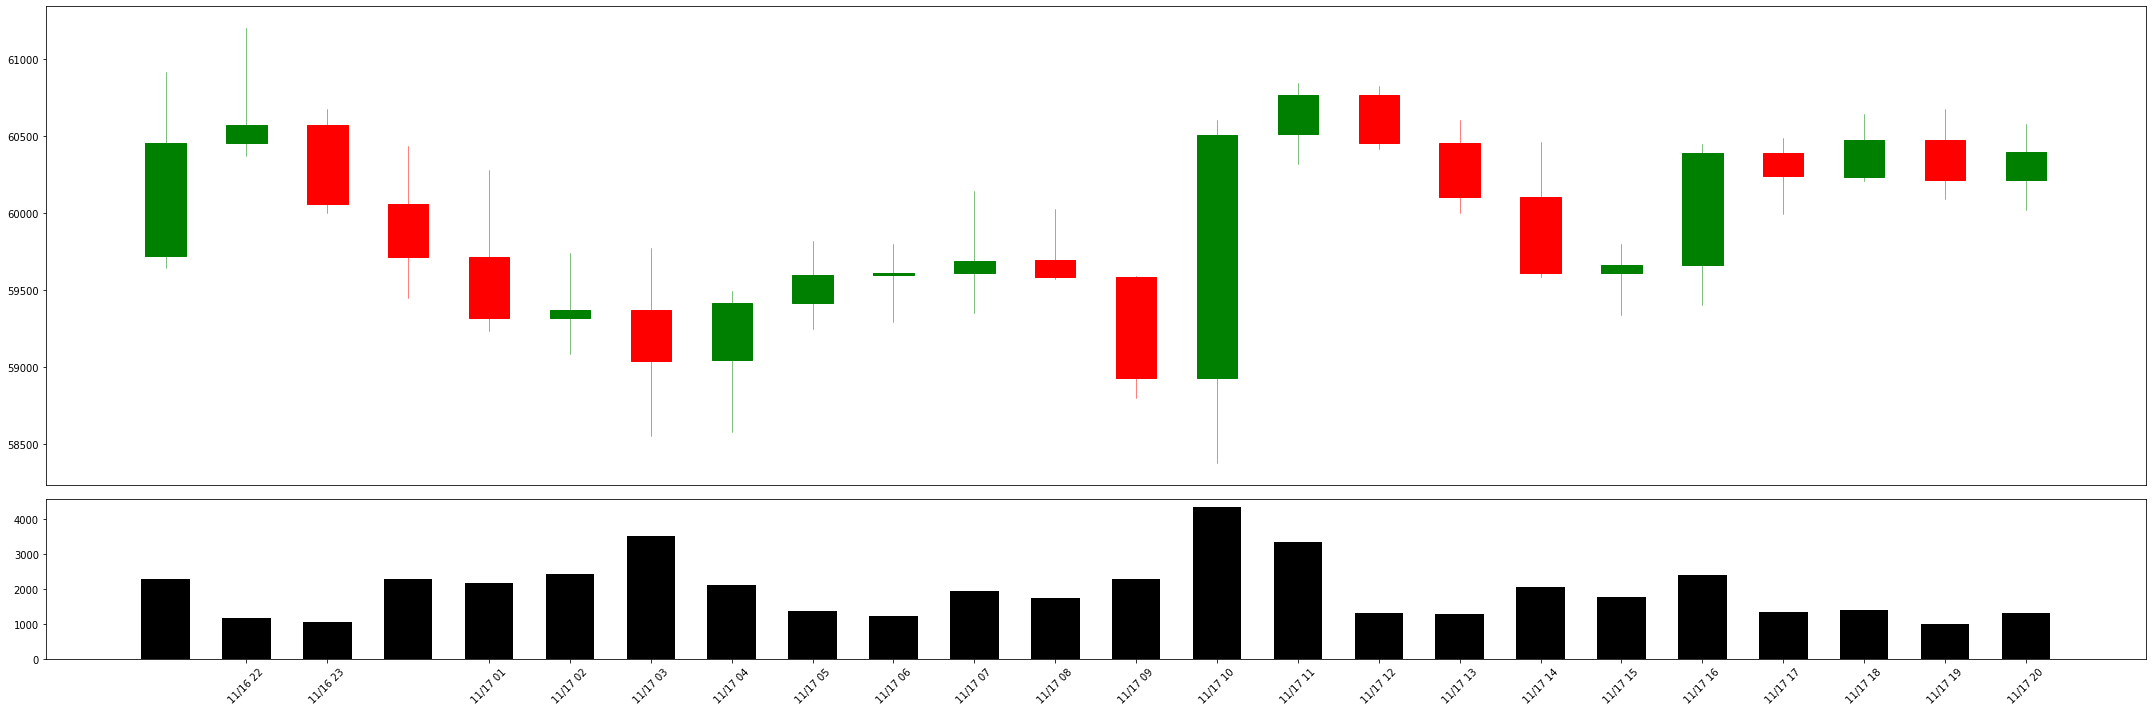

그레이스케일 CEO "메타버스·암호화페 융합 계속된다"
비즈니스인사이더에 따르면, 세계 최대 암호화폐 자산운용사 그레이스케일의 최고경영자 마이클 소넨샤인(Michael Sonnenshein)이 미디어와의 인터뷰에서 "가상현실, 게임, 암호화폐 사이에 지속적인 융합이 이루어지고 있다"면서 "그레이스케일 디센트럴랜드 트러스트가 메타버스 투자 기회를 제공할 것"이라고 말했다. 그레이스케일 디센트럴랜드 트러스트는 메타버스 플랫폼 디센트럴랜드(MANA)에 대한 노출을 제공한다. 소넨샤인은 투자자들이 메타버스에 노출되는 가장 순수한 방법은 해당 애플리케이션의 네이티브 토큰을 보유하는 것이라면서, 디센트럴랜드, 블록토피아, 스타아틀라스 등을 예로 들었다.
뉴스가 올라온 시각 : 2021년 11월 16일 12시 
딥러닝 기반 기사 유사도: 0.7455
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:34.31%, 악재:0.09%, 중립:65.6%


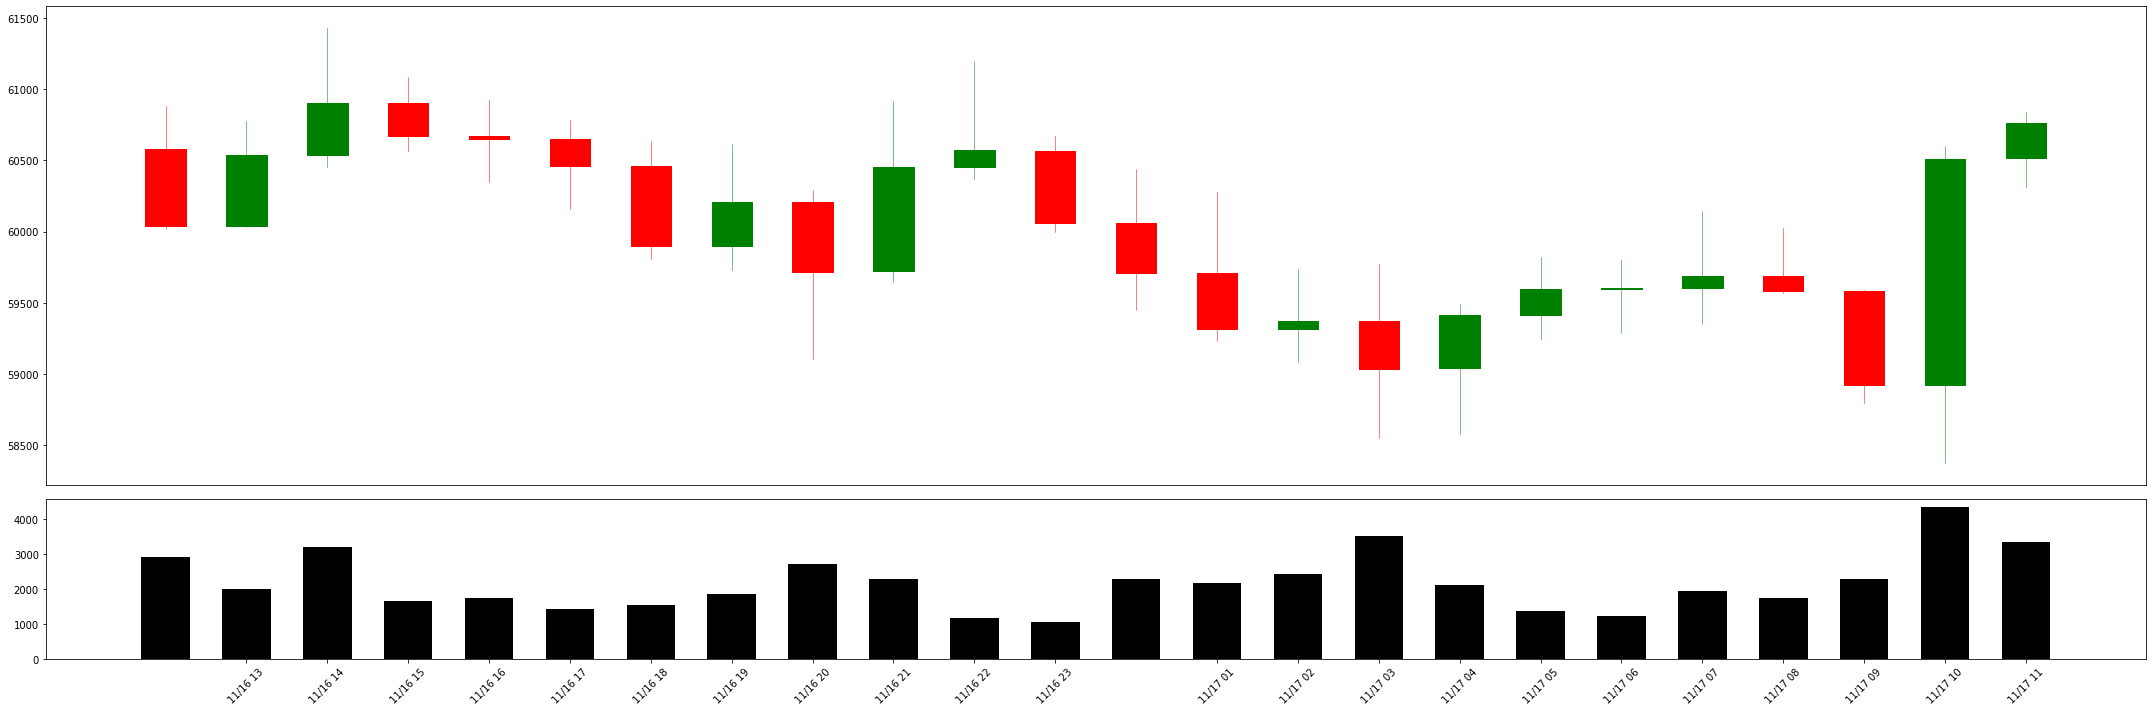

NFT 인기에 투자금 몰린다…'마켓플레이스' 경쟁 심화
대체불가토큰(NFT) 열풍이 불면서 NFT를 발행·거래할 수 있는 마켓플레이스에 대한 관심과 수요가 높아지고 있다. 지배적인 플랫폼이 없는 상황에서 NFT를 통한 새로운 비즈니스 모델과 시장 기회를 찾는 다수의 플레이어들이 새롭게 시장에 뛰어들고 있다.
세계 최대 암호화폐 정보 제공 사이트 크립토위저(Cryptowisser)는 약 30여 개 NFT 마켓플레이스가 NFT 발행·거래 시장을 지원하고 있다고 밝혔다.
2017년 3개, 2018년 11개, 2019년 3개, 2020년 11개의 NFT 마켓플레이스가 등장했다. 2021년 현재까지 4개의 NFT 플랫폼이 출범했다. 크립토위저는 각 마켓플레이스가 지원하는 NFT 카테고리, 수수료, 결제 옵션, 블록체인, 설립 시기, 사용자 평점 등을 제공하고 있다.
오픈씨, 라리블 등 주요 NFT 마켓플레이스는 지원하는 블록체인의 자체 암호화폐로 결제를 받고 있다. 메이커스플레이스처럼 일반 커뮤니티까지 사용자 기반을 넓히기 위해 신용카드, 페이팔 등 일반 결제 방식을 지원하는 마켓플레이스도 늘고 있다.
NFT 지원 상품 다양성, 접근성과 함께 NFT 마켓플레이스의 경쟁력을 결정짓는 발행 및 거래 수수료는 2~15%까지 천차만별이다.

오픈씨(OpenSea), 최대 NFT 마켓플레이스
2018년 출범한 NFT 마켓플레이스 오픈씨는 유틸리티, 수집품, 거래용 카드, 예술품, 도메인, 가상 세계, 스포츠 등 다양한 부문의 NFT 400만 개 이상을 지원하고 있다.
오픈씨는 자율 상장 방식을 지원한다. 이용자는 수수료 없이 NFT를 발행(minting·민팅)할 수 있으며 타 플랫폼에서 발행한 NFT도 거래할 수 있다. 지원 블록체인은 이더리움, 폴리곤(MATIC), 클레이튼(KLAY)이다.
NFT를 구매할 경우에 2.5%의 수수료가 붙는다. 판매 방식은 고정 가격 방식, 가격 하락 방식, 경매 방식을 지원하다.
2021년 3월 한 달 동안 8000만 달러의 거래량을 기록했다.

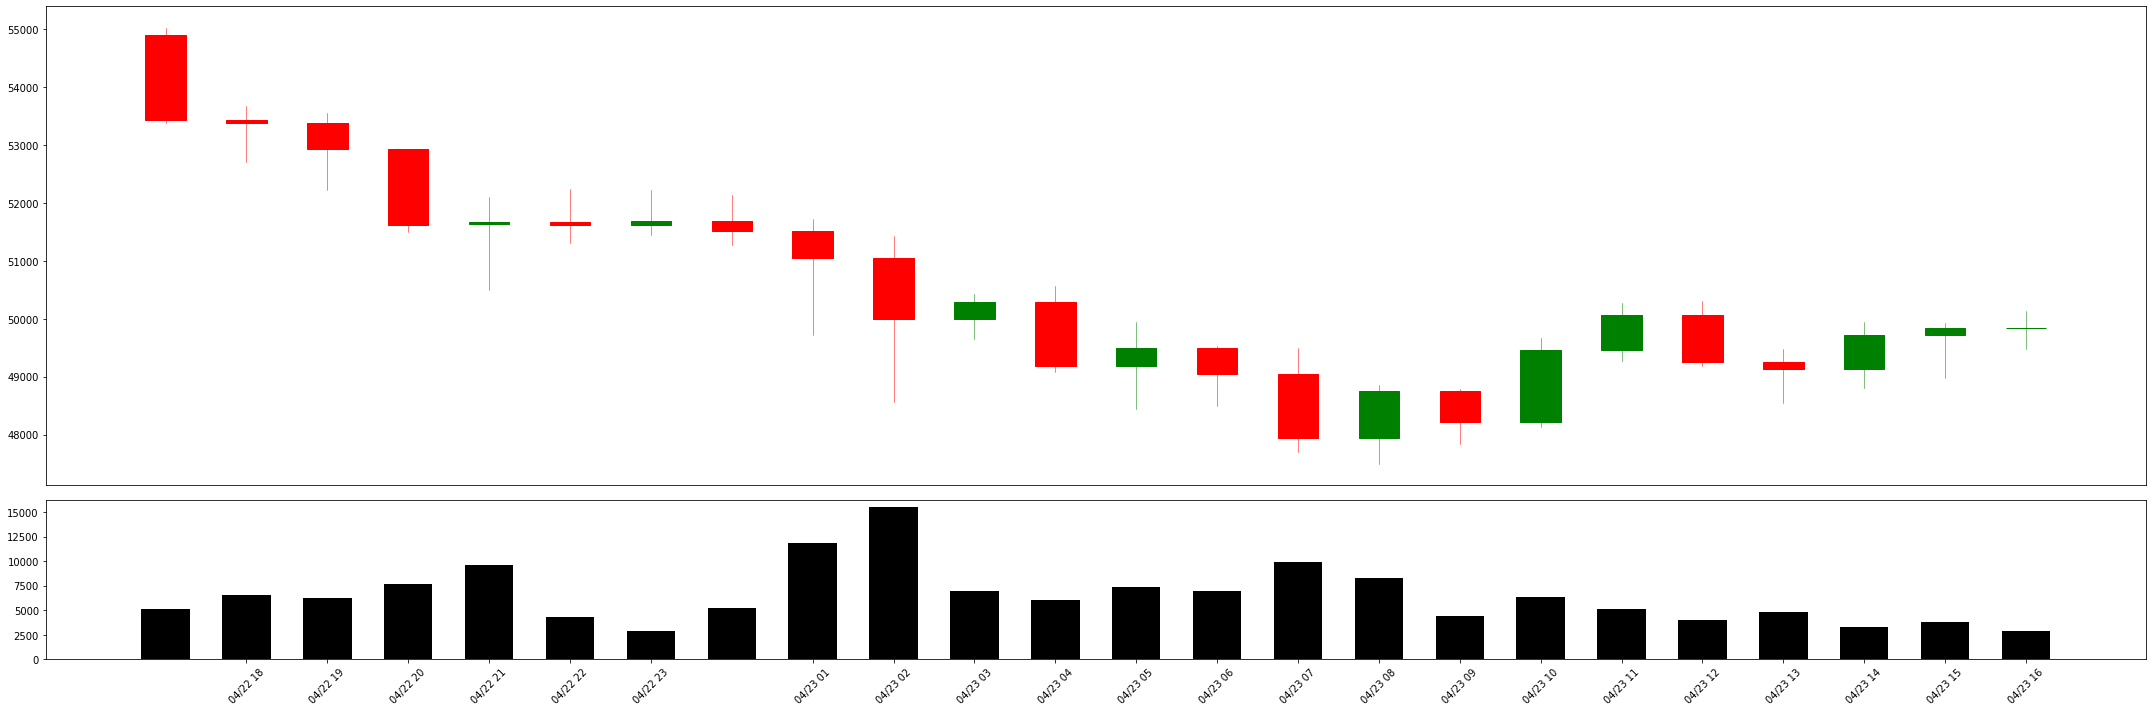

[NFT, 아트, 작가, 만나다③] 김진 작가 “NFT, 디지털 세상 속 ‘신뢰’를 만들다”
대체불가토큰(NFT) 시장의 폭발적인 성장을 이끌어온 것은 예술, 미술품 등 아트 시장이다. 높은 가치와 희소성이 보장된 예술·미술품은 NFT로 제작하기에 안성맞춤이었고, 수십, 수백 년 동안 이어진 아트 시장의 고착화된 유통 구조는 변화가 필요한 시점이었다. 서로의 필요에 의해 NFT와 아트는 만났고, 비상했다. 이것들은 엄청난 시너지를 발휘하며 무섭게 성장했다.
무엇인가 무섭게 성장하면 곧 따라오는 말은 ‘거품(버블)’이다. 아트 NFT도 마찬가지다. 지난 2021년 무서운 성장세를 보였던 만큼 아트 NFT에 대한 본질에 대한 의문이 나오고 있다. 우리는 지금까지 이에 대해 블록체인이라는 기술적인 측면과 ‘암호화폐처럼’ 가치가 오를 것이라는 투자의 시선으로 아트 NFT를 바라봤다. 하지만 이보다 중요한 본질은 따로 있을 것이다. 기술, 투자로만 설명할 수 없는 아트 NFT, 이것에 대해 알아보기 위해 NFT를 발행한 작가(아티스트)를 직접 만나봤다.
토큰포스트가 세 번째로 만나본 작가는 20여 년간 미술계에 몸담은 서양화가이자 대구대학교에서 학생들에게 현대미술을 가르치고 있는 김진 작가이다. 김진 작가는 최근 바른손랩스에서 서비스하는 문화예술 NFT 플랫폼 ‘엔플라넷(nPlanet)’을 통해 아트 NFT를 발행했다. 기존의 미술 시장에 대한 전문적인 견해와 새롭게 떠오르는 아트 NFT에 대한 새로운 인사이트를 제공해 줄 김진 작가의 이야기를 함께 들어보자.

안녕하세요. 작가님이 생각하는 NFT란 무엇인가요?
일단 NFT에 대해 설명하기 전에 기존 아트 시장의 플랫폼을 살펴봐야 할 필요가 있습니다. 기존 아트 시장의 플랫폼은 갤러리를 중심으로 한 유통 시스템이라고 볼 수 있습니다. 이것은 상당히 오랜 시간 만들어져 정착한 시스템인데요. 갤러리를 통해 작가들의 작품을 소개하고 수집가들과 작가들을 연결해 작품의 거래를 중개하는 것이죠. 갤러리는 작가와 수집가의 거래에서

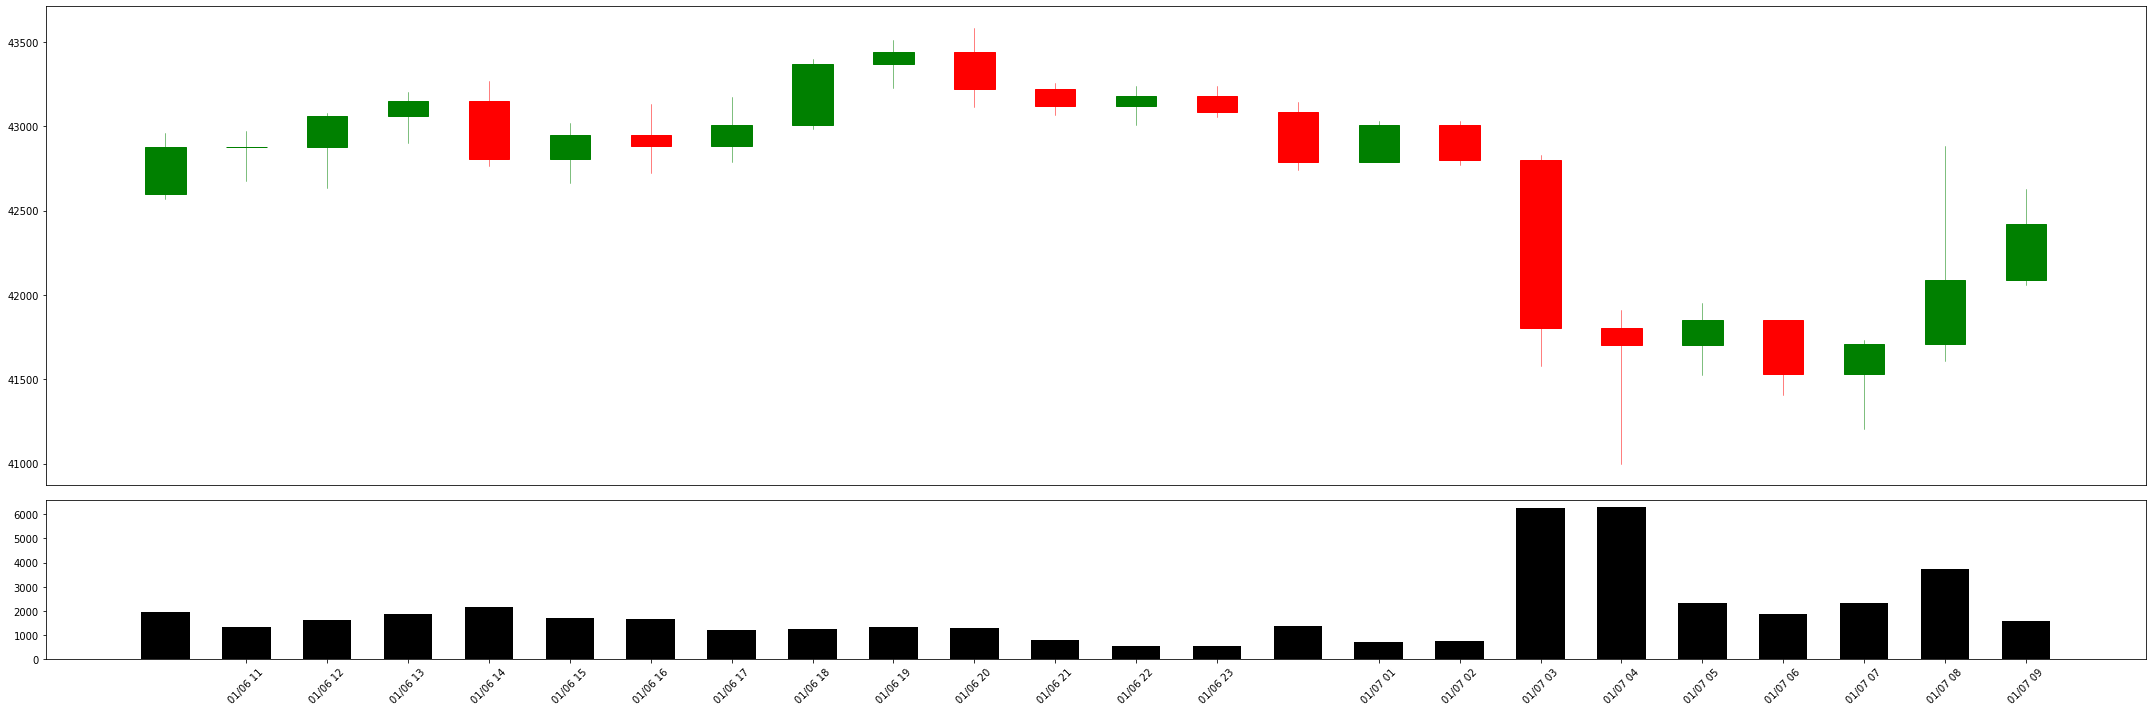

[NFT, 아트, 작가, 만나다①] 오승환 작가 “중요한 것은 원본과의 페어링”
대체불가능토큰(NFT) 시장의 폭발적인 성장을 이끌어온 것은 예술, 미술품 등 아트 시장이다. 높은 가치와 희소성이 보장된 예술·미술품은 NFT로 제작하기에 안성맞춤이었고, 수십, 수백 년 동안 이어진 아트 시장의 고착화된 유통 구조는 변화가 필요한 시점이었다. 서로의 필요에 의해 NFT와 아트는 만났고, 비상했다. 이것들은 엄청난 시너지를 발휘하며 무섭게 성장했다.
무엇인가 무섭게 성장하면 곧 따라오는 말은 ‘거품(버블)’이다. 아트 NFT도 마찬가지다. 지난 2021년 무서운 성장세를 보였던 만큼 아트 NFT에 대한 본질에 대한 의문이 나오고 있다. 우리는 지금까지 이에 대해 블록체인이라는 기술적인 측면과 ‘암호화폐처럼’ 가치가 오를 것이라는 투자의 시선으로 아트 NFT를 바라봤다. 하지만 이보다 중요한 본질은 따로 있을 것이다. 기술, 투자로만 설명할 수 없는 아트 NFT, 이것에 대해 알아보기 위해 NFT를 발행한 작가(아티스트)를 직접 만나봤다.
토큰포스트는 NFT와 아트, 그리고 아트 NFT에 대한 인사이트를 넓히기 위해 NFT 작가들의 견해를 듣는 인터뷰 연재를 진행한다. 첫 번째로 만나볼 작가는 사진가이자 아트디렉터로 활동하고 있는 오승환 작가이다. 오 작가는 25년간 대학교수로 학생들에게 사진 교육을 진행해 왔으며, 수차례에 걸친 개인전을 펼쳐왔다. 특히 블록체인을 비롯해 NFT에 대해서도 넓은 식견을 보유하고 있는 만큼 오 작가를 통해 아트 NFT가 무엇인지 가늠해볼 수 있었다.

안녕하세요. 작가님이 생각하는 아트 NFT란 무엇인가요?
“한 마디로 표현하자면 ‘인증된 레플리카’라고 설명할 수 있을 것 같아요. 블록체인을 활용해 암호화된 데이터를 넣은 레플리카죠. 보통 아트 시장에서 레플리카라고 하면 원작자가 자신의 작품을 동일한 재료, 방법, 기술을 이용해 똑같은 모양과 크기로 재현하는 것을 의미하는데요. 특정 작품을 따라 하는 모사나 인쇄를 통한 복제와는 차이

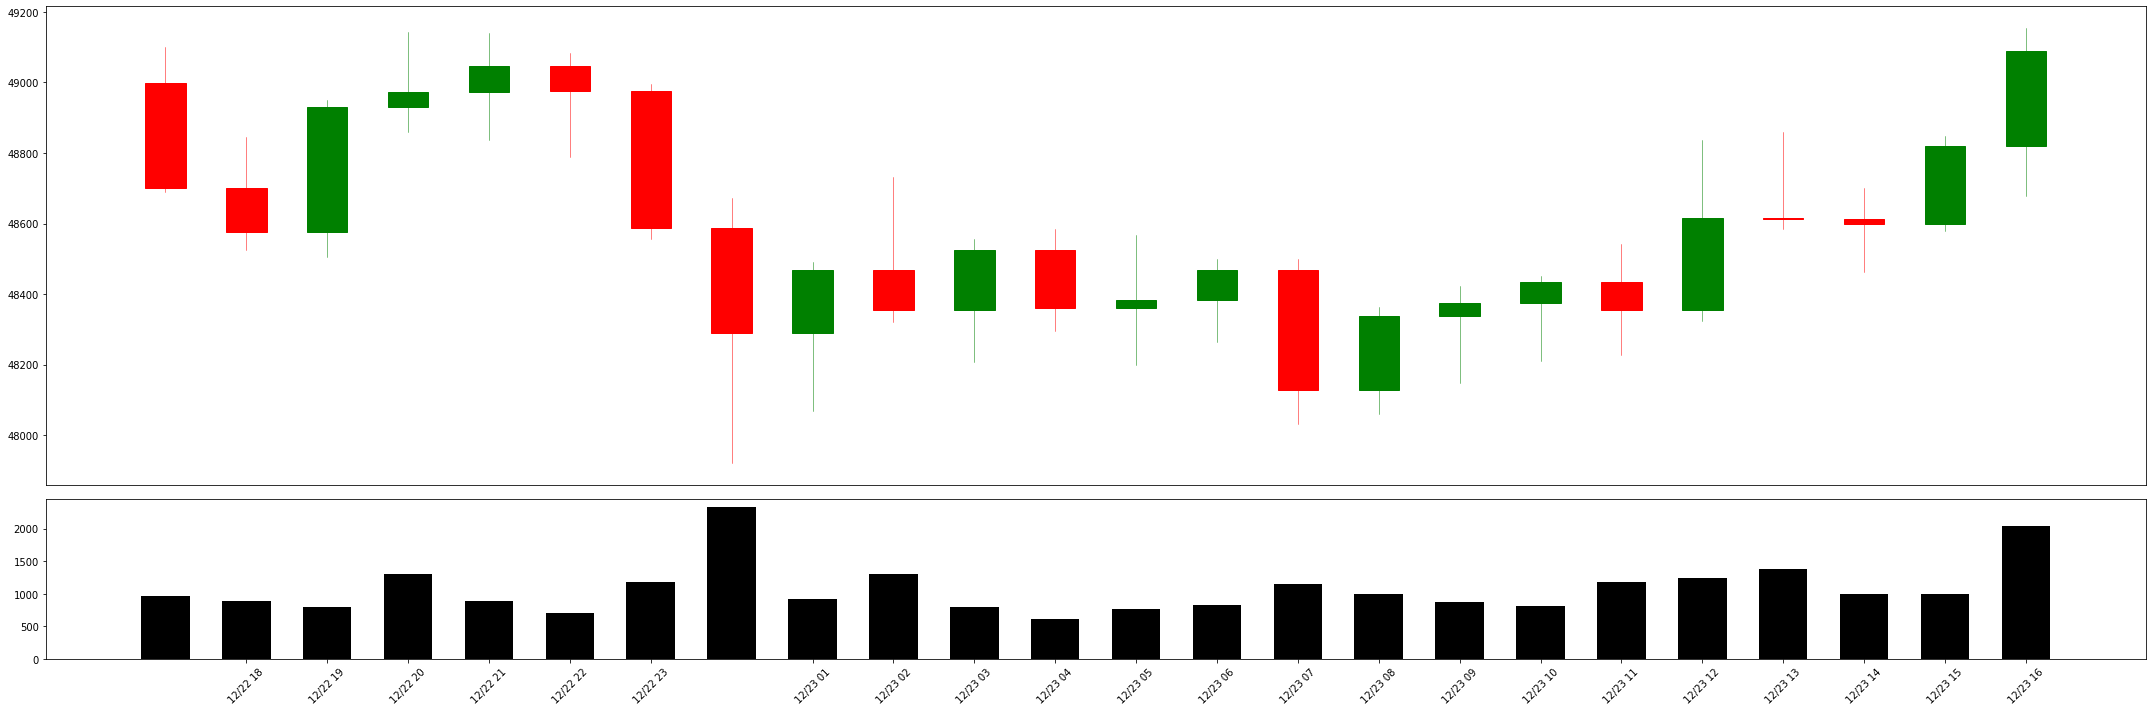

대기업·대학가에 부는 ‘메타버스 열풍’
메타버스(Metaverse, Meta+universe)를 활용하는 기업 및 기관이 빠르게 늘어나고 있다. 코로나19로 인해 비대면 문화가 확산되면서 메타버스에 대한 관심도가 커지고 있다는 것이 전문가들의 분석이다.
2021년 9월 1일 취업포털 잡코리아에 따르면 국내 대기업 인사담당자들 중 상당수가 메타버스를 활용해 채용설명회, 신입사원 교육 등을 진행할 경우 긍정적인 효과가 있을 것이라 응답했다.
잡코리아가 365개 기업을 대상으로 조사한 결과 ‘채용 설명회에 메타버스 기술을 도입하는 것이 도움이 될 것 같다’라고 응답한 인사담당자는 39.2%로 가장 많았다. 이어 ‘모의면접(24.4%)과 인턴십 운영(20.3%)을 진행할 때 메타버스를 활용해 긍정적인 효과를 볼 수 있을 것이라 응답했다.
대기업, 채용설명회·교육 등에도 메타버스
실제로 메타버스를 활용하고 있는 기업도 적지 않다. 국내 최대 게임 회사인 넥슨의 경우 8월 31일 시작한 채용설명회를 자사 메타버스 플랫폼 ‘게더타운’을 통해 개최했다. 자사 게임 ‘바람의 나라’에서 모티브를 따와 ‘채용의 나라’라는 메타버스를 구축했다. 구직자들은 해당 메타버스를 활용해 넥슨 사옥을 미리 만나볼 수 있으며 직무 상담과 인사 상담을 받아 볼 수 있다.
넷마블의 경우 메타버스를 활용한 가상현실 플랫폼을 개발해 가상 아이돌 매니지먼트 등 게임과 연계된 메타버스 콘텐츠를 제작하고 있다. 실제로 넷마블의 개발 자회사 넷마블에프앤시는 ‘메타버스엔터테인먼트’를 설립하기도 했다.
삼성전자와 LG전자 역시 메타버스를 적극 활용하고 있다. 삼성전자의 경우 최근 폴더블 스마트폰 출시 행사인 갤럭시 팬파티 ‘폴더블데이’를 메타버스에서 개최했으며, 지난달에는 제페토에서 라이프스타일 TV 3종을 판매하기도 했다. 삼성전자는 3종류의 라이프스타일 TV를 각가 5000대씩 준비했지만 판매 시작 5분 만에 매진되기도 했다.
보수적이기로 유명한 건설업계에도 메타버스를 활용하는 사례가 등장했다. 롯데건설은 

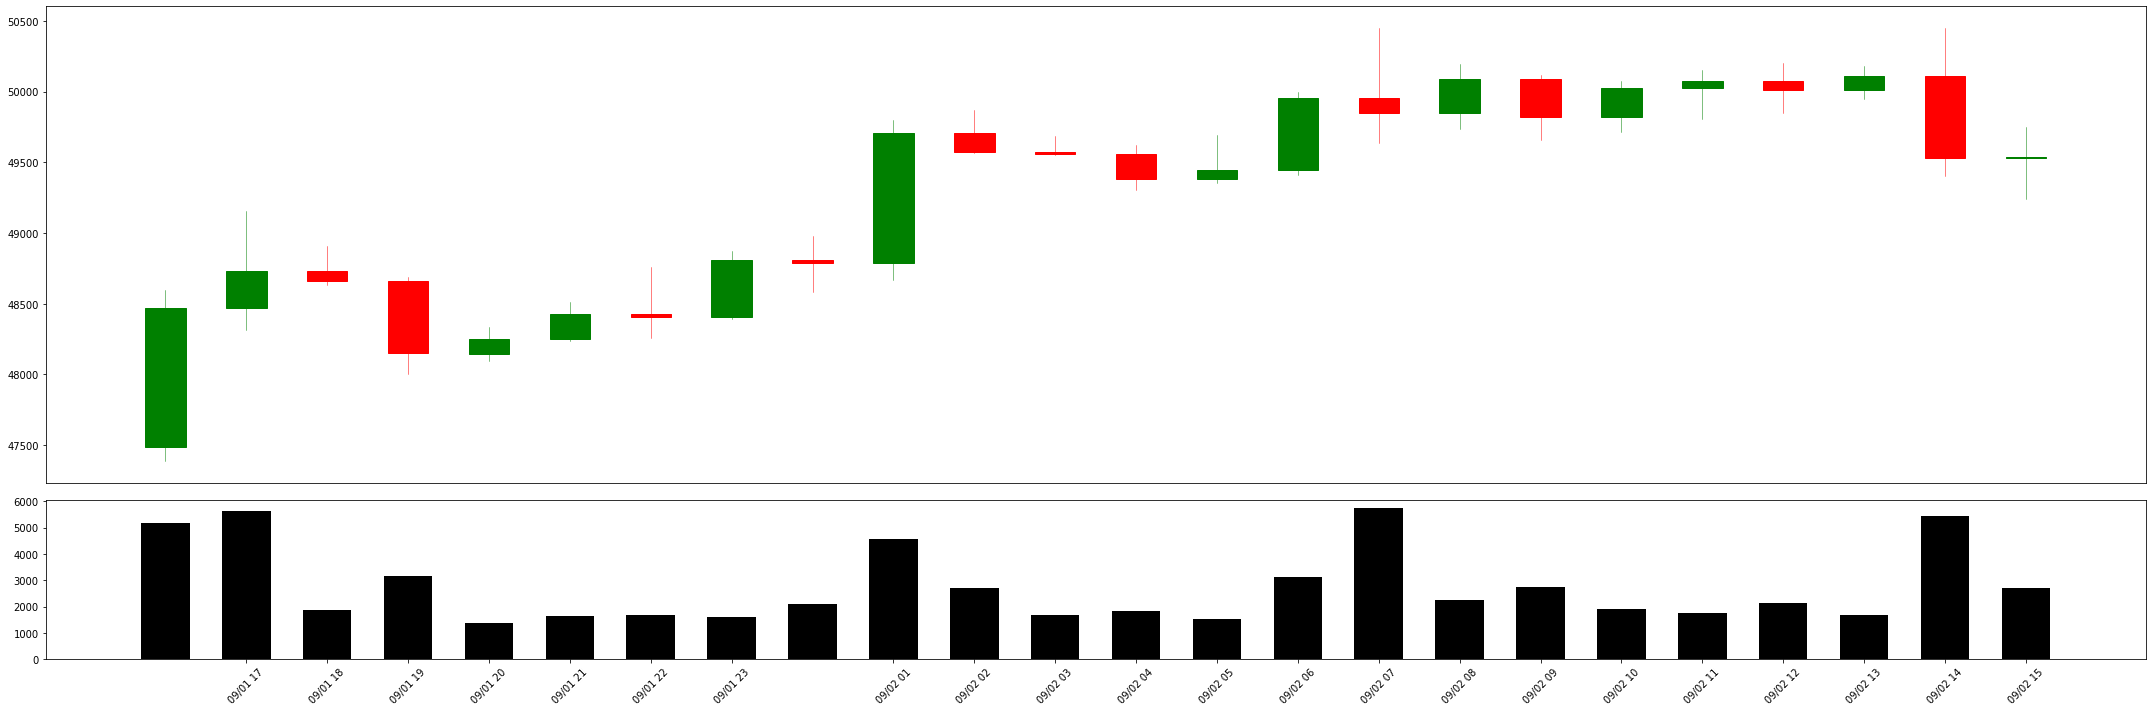

In [22]:
title = str(input("뉴스 제목을 입력하세요: "))
content = str(input("뉴스 기사를 입력하세요: ")) 

get_rank_results(title, content) 

# Example 5

뉴스 제목을 입력하세요:  분석 "BTC, 아직 과매도 구간 진입 안 해...거래량 부족"
뉴스 기사를 입력하세요:  크립토퀀트 기고자 고두시파르(ghoddusifar)가 "와이코프(Wyckoff)의 차트 패턴에 따르면 BTC는 아직 축적(과매도) 구간에 진입하지 않았을 가능성이 높다"고 진단했다. 와이코프 패턴은 1930년대 주식 시장의 권위자로 불렸던 리차드 와이코프(Richard Wyckoff)가 개발한 차트 분석 이론이다. 수요와 공급에 따른 주기 순환을 토대로 가격 상승과 하락을 예측하는 것이 특징이다. 고두시파르는 "이 이론을 토대로 살펴보면, 많은 양의 트랜잭션이 발생할 때만 BTC가 축적 구간에 진입했다고 판단할 수 있다. 하지만 현재 거래소의 거래량이 결코 많지 않은 수준이다. 따라서 거래량을 기준으로 BTC는 아직 본격적인 축적 구간에 진입하지 않았을 가능성이 크다"고 설명했다.


104826 개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.
============================== query ==============================
분석 "BTC, 아직 과매도 구간 진입 안 해...거래량 부족"
크립토퀀트 기고자 고두시파르(ghoddusifar)가 "와이코프(Wyckoff)의 차트 패턴에 따르면 BTC는 아직 축적(과매도) 구간에 진입하지 않았을 가능성이 높다"고 진단했다. 와이코프 패턴은 1930년대 주식 시장의 권위자로 불렸던 리차드 와이코프(Richard Wyckoff)가 개발한 차트 분석 이론이다. 수요와 공급에 따른 주기 순환을 토대로 가격 상승과 하락을 예측하는 것이 특징이다. 고두시파르는 "이 이론을 토대로 살펴보면, 많은 양의 트랜잭션이 발생할 때만 BTC가 축적 구간에 진입했다고 판단할 수 있다. 하지만 현재 거래소의 거래량이 결코 많지 않은 수준이다. 따라서 거래량을 기준으로 BTC는 아직 본격적인 축적 구간에 진입하지 않았을 가능성이 크다"고 설명했다.
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:76.81%, 악재:12.23%, 중립:10.96%





============================== candidates ==============================
분석 "비트코인, 약세장 마무리 및 축적 단계"
코인데스크에 따르면, 비트코인 일일 발행량을 365일 평균가격으로 나눈 '푸엘 멀티플(Puell Multiple)' 지수가 0.5 미만의 '그린존'으로 하락, 신규 발행된 코인이 연평균 대비 저평가 되고 있는 것으로 나타났다. 블록웨어 인텔리전스 애널리스트는 "그린존은 평균적으로 진입하기 좋은 시기이며, 보수적인 투자자는 축적 영역을 지나고 상승장 확인 후 진입할 수 있다"고 말했다. 한편 데일리호들에 따르면 암호화폐 애널리스트 벤자민 코웬(Benjamin Cowen

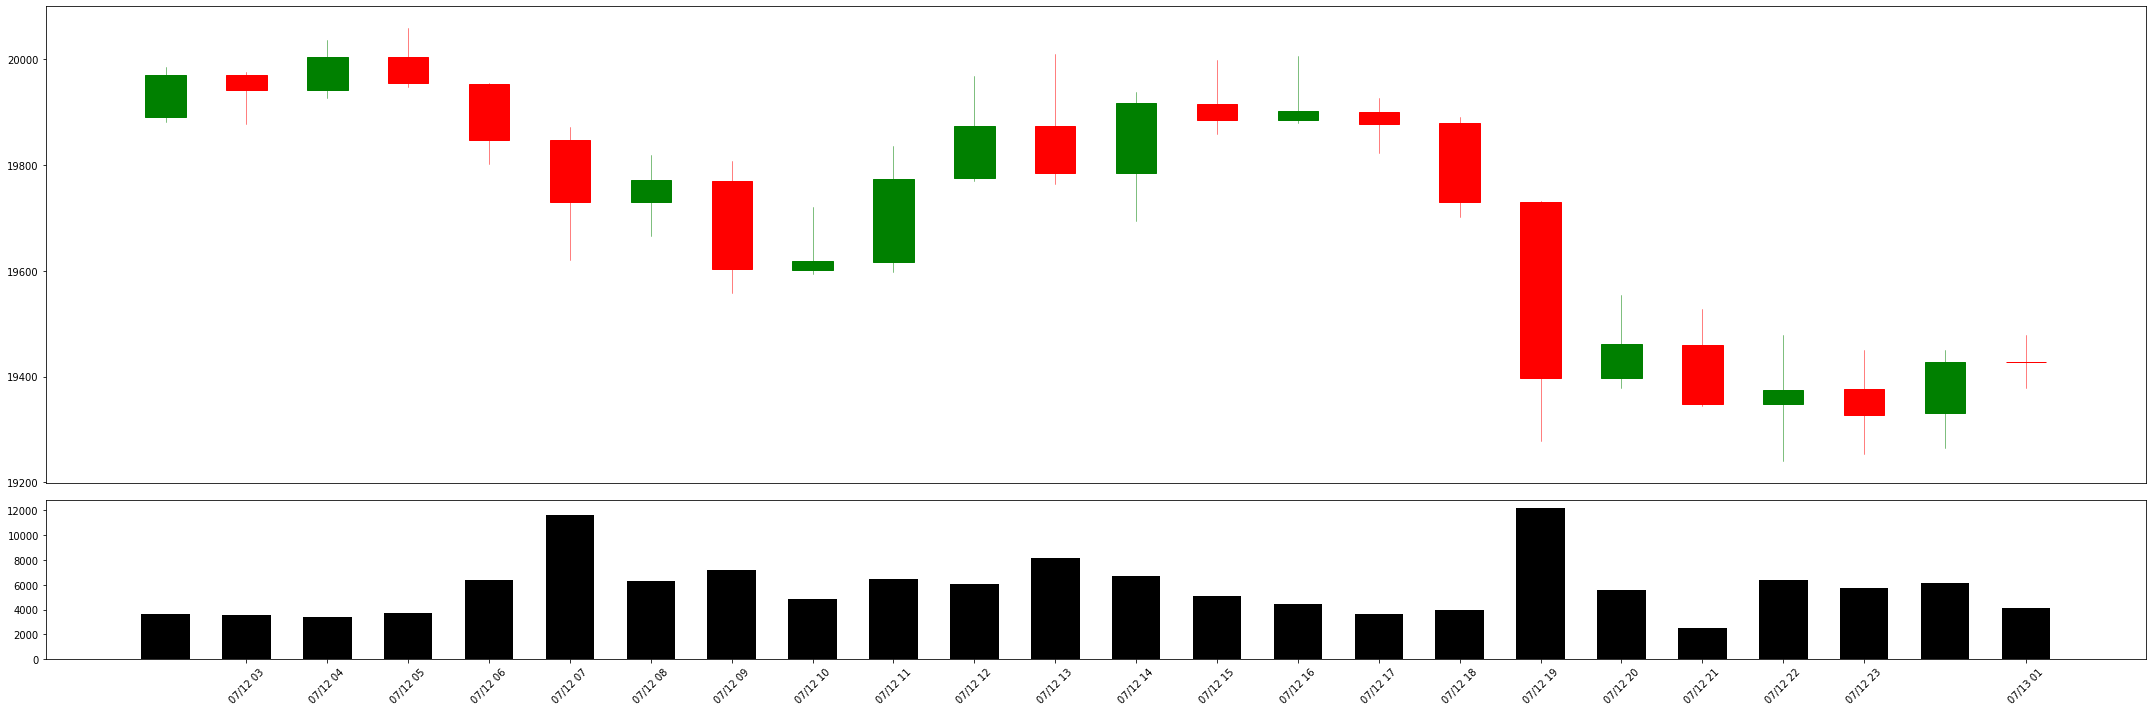

분석 "BTC, 200주 이동평균 터치...거래량 부족에 추가 바닥 테스트 가능성"
코인텔레그래프에 따르면 암호화폐 전문 트레이더 겸 애널리스트 렉트 캐피탈(Rekt Capital)은 "비트스탬프 BTC/USD 차트 기준 200주 이동평균(MA) 22,400달러에 도달했으나 거래량은 이전 약세장에서 확인했던 바닥만큼 많지 않았다"고 분석했다. BTC가 더 낮은 바닥을 확인할 가능성이 열려 있다는 설명이다.
뉴스가 올라온 시각 : 2022년 6월 14일 18시 
딥러닝 기반 기사 유사도: 0.8299
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:88.87%, 악재:4.9%, 중립:6.24%


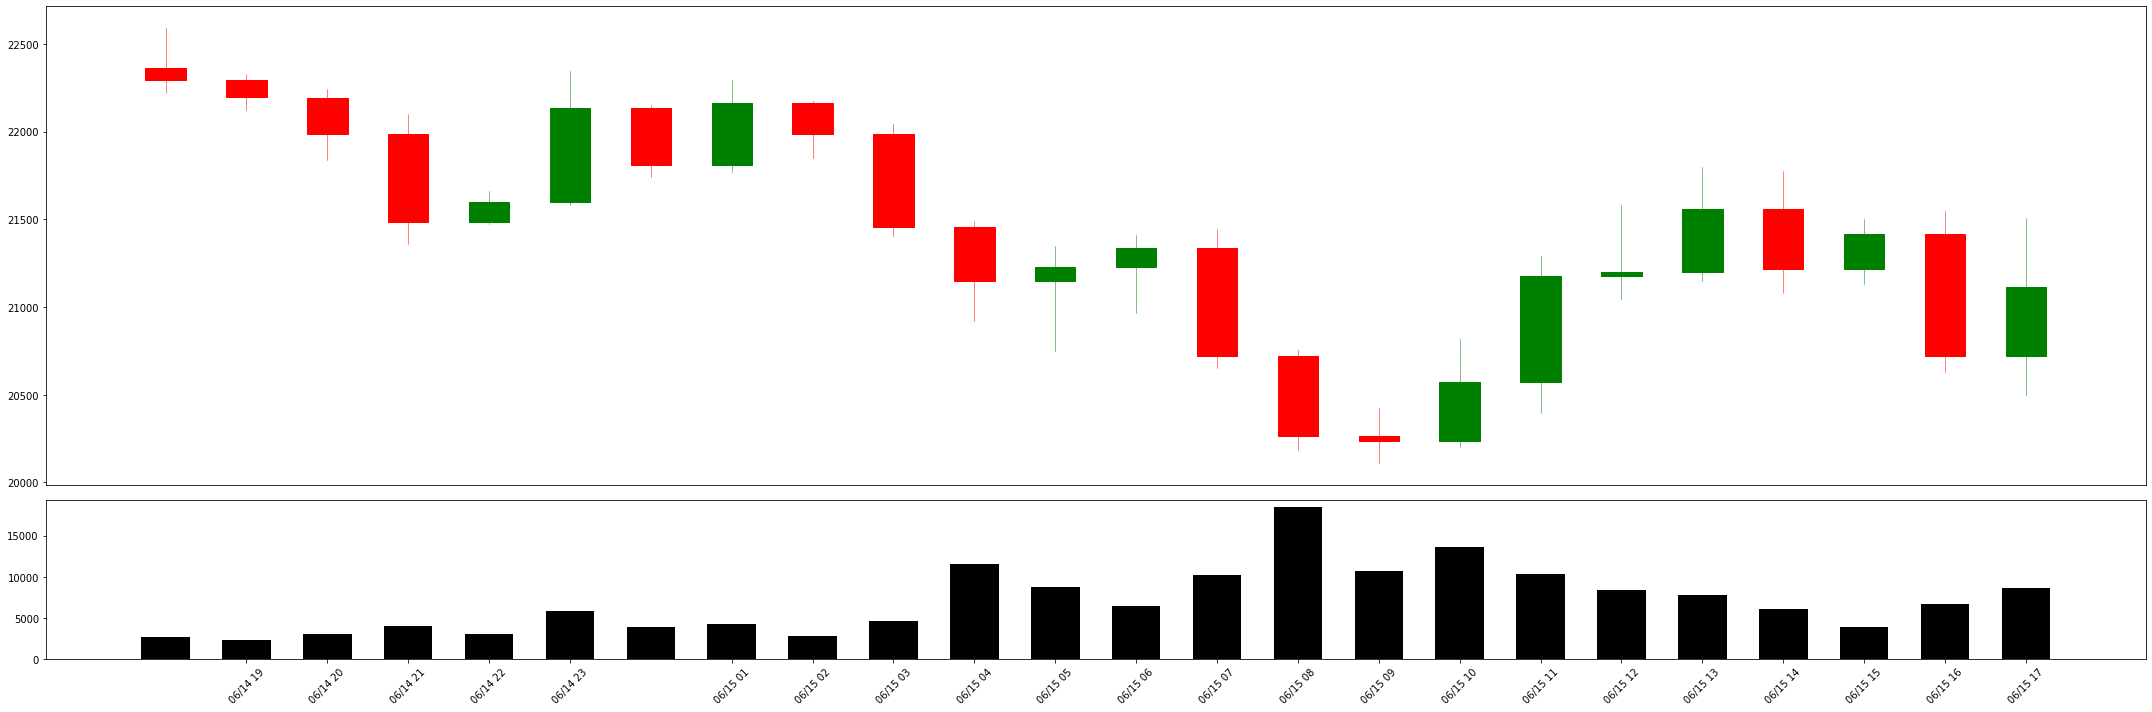

분석 "최근 BTC 하락, 단기적 흐름...추세 반전 지표 주목"
암호화폐 전문 미디어 AMB크립토가 "바이낸스 기준 BTC 일봉을 보면, 최근 BTC에 대한 매도 압력은 추세를 이탈할 만큼 강력했지만, 지표 상으로는 아직 과매도 영역에 있지는 않다. 또 거래량 흐름을 바탕으로 자산 가격 변화를 예측하는 모멘텀 지표인 OBV가 현재 2019년 3월 이후 최저 수준으로 떨어져 있는데, 곧 반전될 것으로 예상된다"고 전망했다. 미디어는 "특히 퍼포스 비트코인 ETF(Purpose Bitcoin ETF)에서는 지난 11일~19일 사이에 3,609 BTC가 유출됐는데, 이 흐름이 점차 둔화되고 있다. 이는 BTC에 대한 매도 압력이 약해지고 있다는 방증이다. 아울러 지난 17일 이후 1,000 BTC 이상을 보유한 ​​주소 수가 크게 증가하고 있다는 점도 이 같은 분석에 설득력을 싣고 있다"고 설명했다. 코인마켓캡 기준 BTC는 현재 0.52% 내린 21,262.15 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 8월 22일 8시 
딥러닝 기반 기사 유사도: 0.8288
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:57.49%, 악재:25.48%, 중립:17.04%


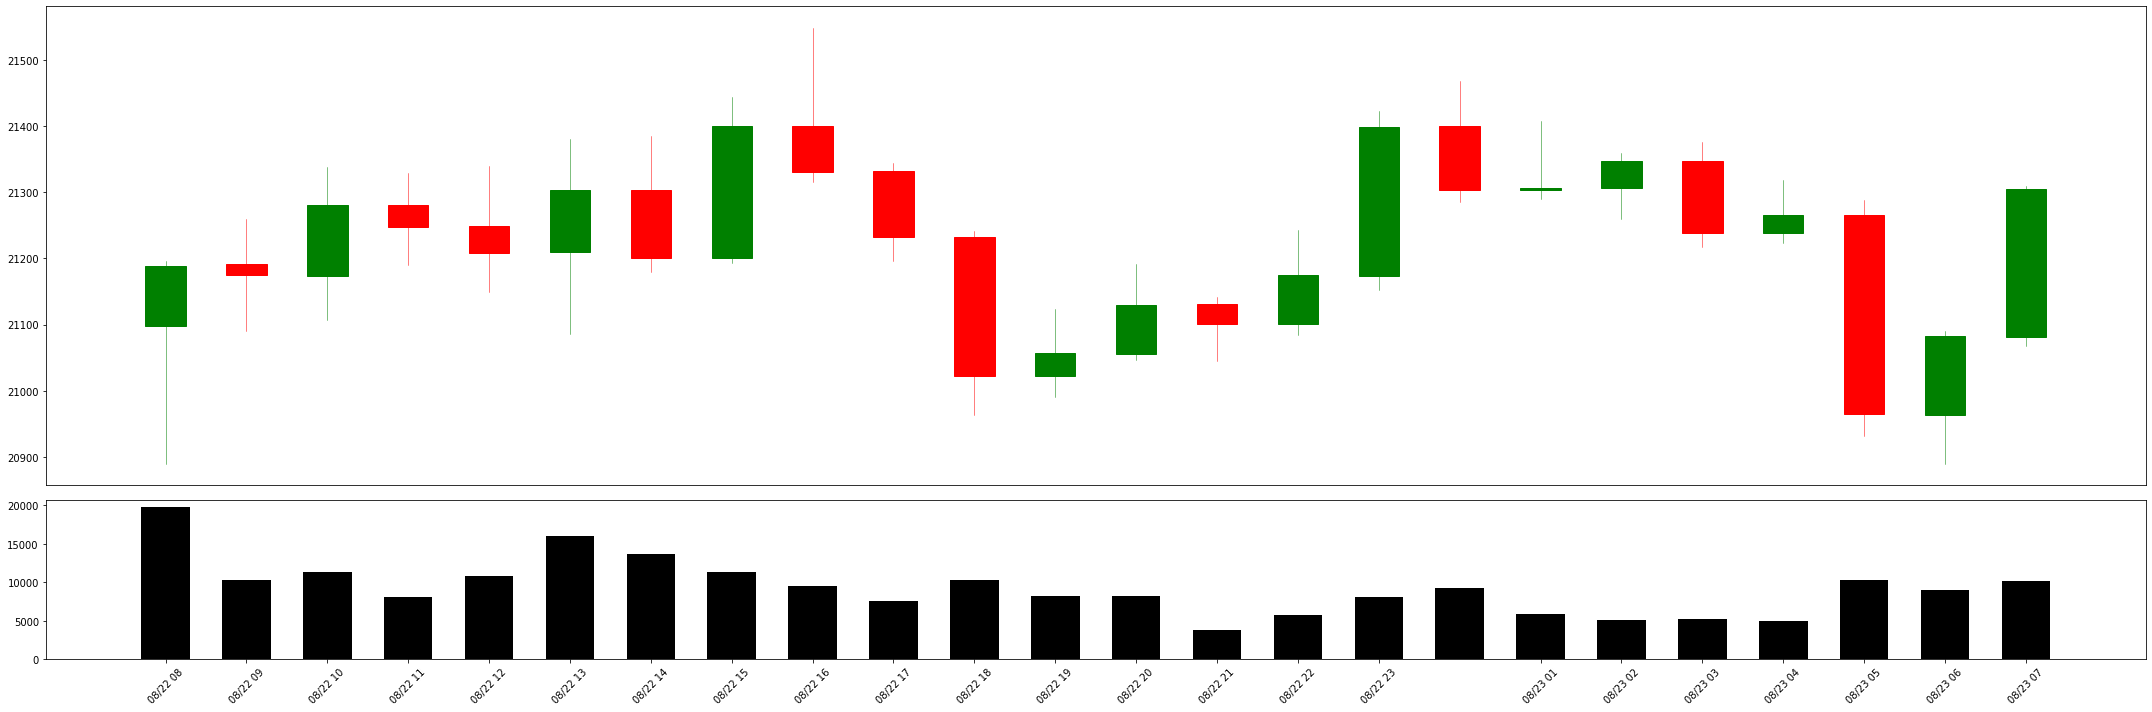

분석 "BTC, 단기적으로 불확실성 커...고래도 공격적 매도 움직임"
AMB크립토가 암호화폐 온체인 분석 업체 글래스노드의 주간 온체인 보고서를 인용해 비트코인이 단기적으로는 매우 불확실한 움직임을 보이고 있으나 장기적으로는 비교적 일관된 추세를 나타내고 있다고 보도했다. 미디어는 "지난해 11월 BTC는 사상 최고 가격을 기록한 이후 축적기를 가졌고 이후부터 느리지만 지속적으로 가격이 하락했다. 지금은 투자자들이 차익 실현을 위해 출구 유동성을 찾고 있는 단계로 접어들었다. 또 10,000 BTC 이상을 보유한 고래들도 공격적으로 코인을 매도해 글로벌 거시 환경의 불확실성 속에서 거의 모든 유동성 출구를 활용했다. 특히 BTC 장기 보유자의 축적 여부 등을 보여주는 활력(Liveliness) 지표 역시 꾸준히 하락 그래프를 그리고 있으며 심지어 지난 2018년 이후 관측됐던 저점을 하향 돌파했다"고 설명했다.
뉴스가 올라온 시각 : 2022년 9월 7일 2시 
딥러닝 기반 기사 유사도: 0.8281
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:65.37%, 악재:15.02%, 중립:19.62%


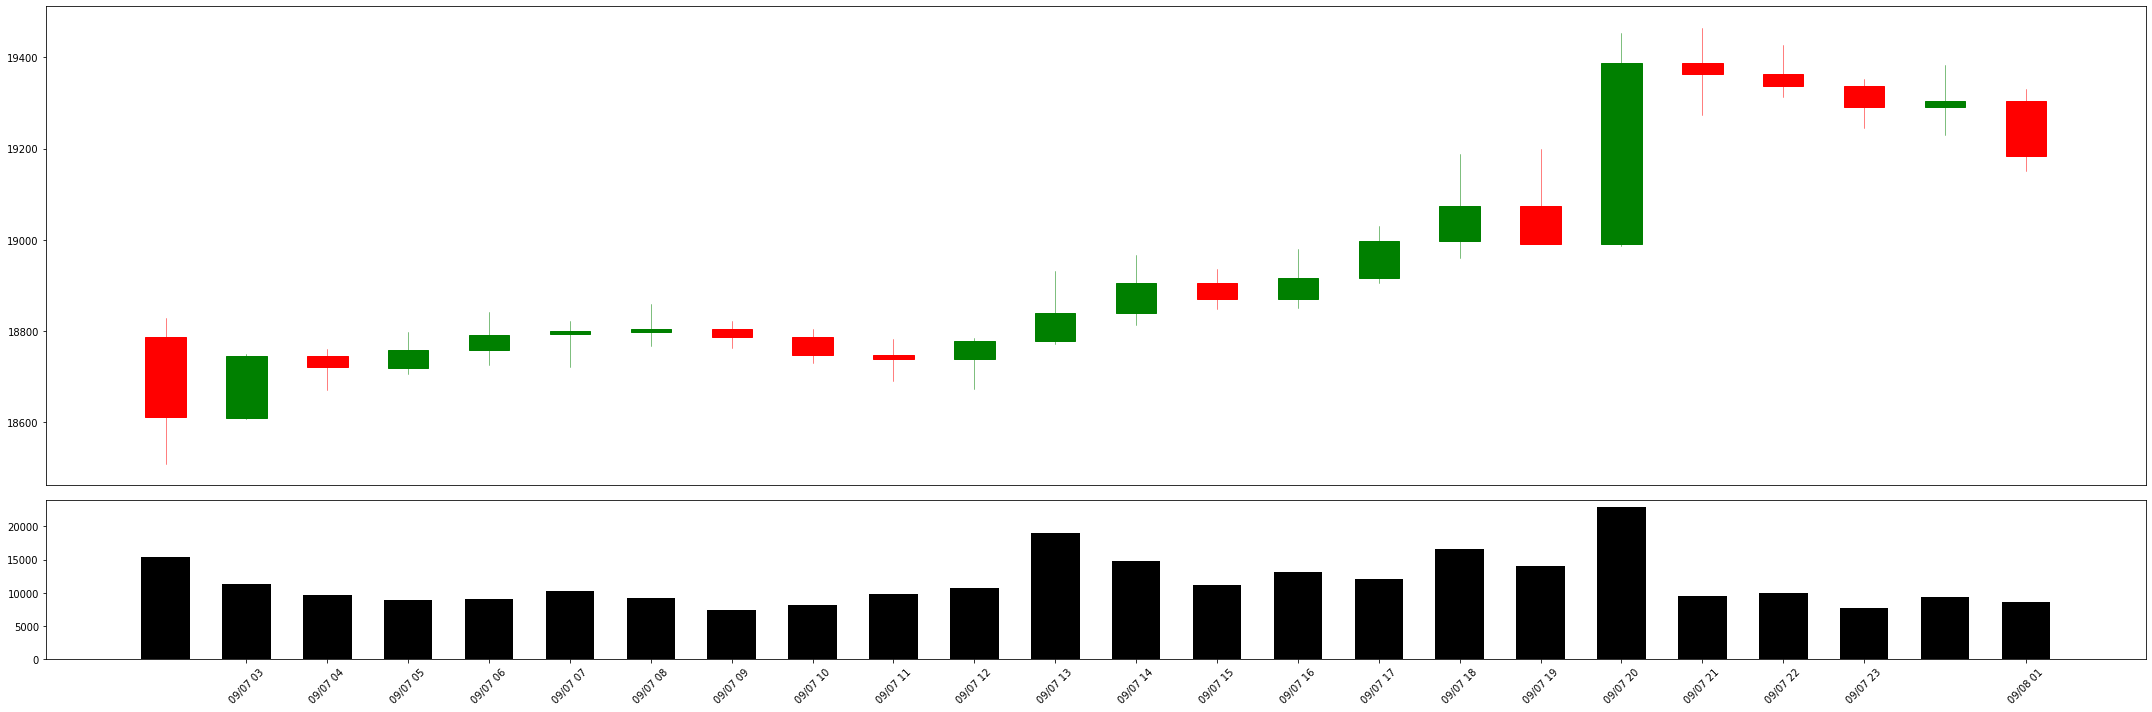

분석 "BTC 70일 연속 200일 MA 하회... 바닥 가까워"
유투데이에 따르면 비스포크 인베스트먼트 그룹 분석가 제이크 고든이 "비트코인이 장기간 200일 이동평균(MA)을 하회하고 있다는 점에서 볼 때 바닥이 가까웠다"고 진단했다. 비스포크 인베스트먼트 그룹은 비트코인이 오랜기간 200일 MA 아래에 머문 후 반등 시 가파르게 상승하는 경향이 있다고 분석했다. 그룹이 집계한 데이터에 따르면 비트코인이 최소 50일 연속 약세를 보인 이후 반등 시 평균 수익률은 약 31%였고, 연평균 수익률은 226%였다. 현재 비트코인은 70일 연속 200일 MA를 밑돌고 있는 상태다. 코인마켓캡 기준 BTC는 현재 1.85% 오른 38,669.84 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 3월 8일 17시 
딥러닝 기반 기사 유사도: 0.8245
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:79.41%, 악재:11.93%, 중립:8.66%


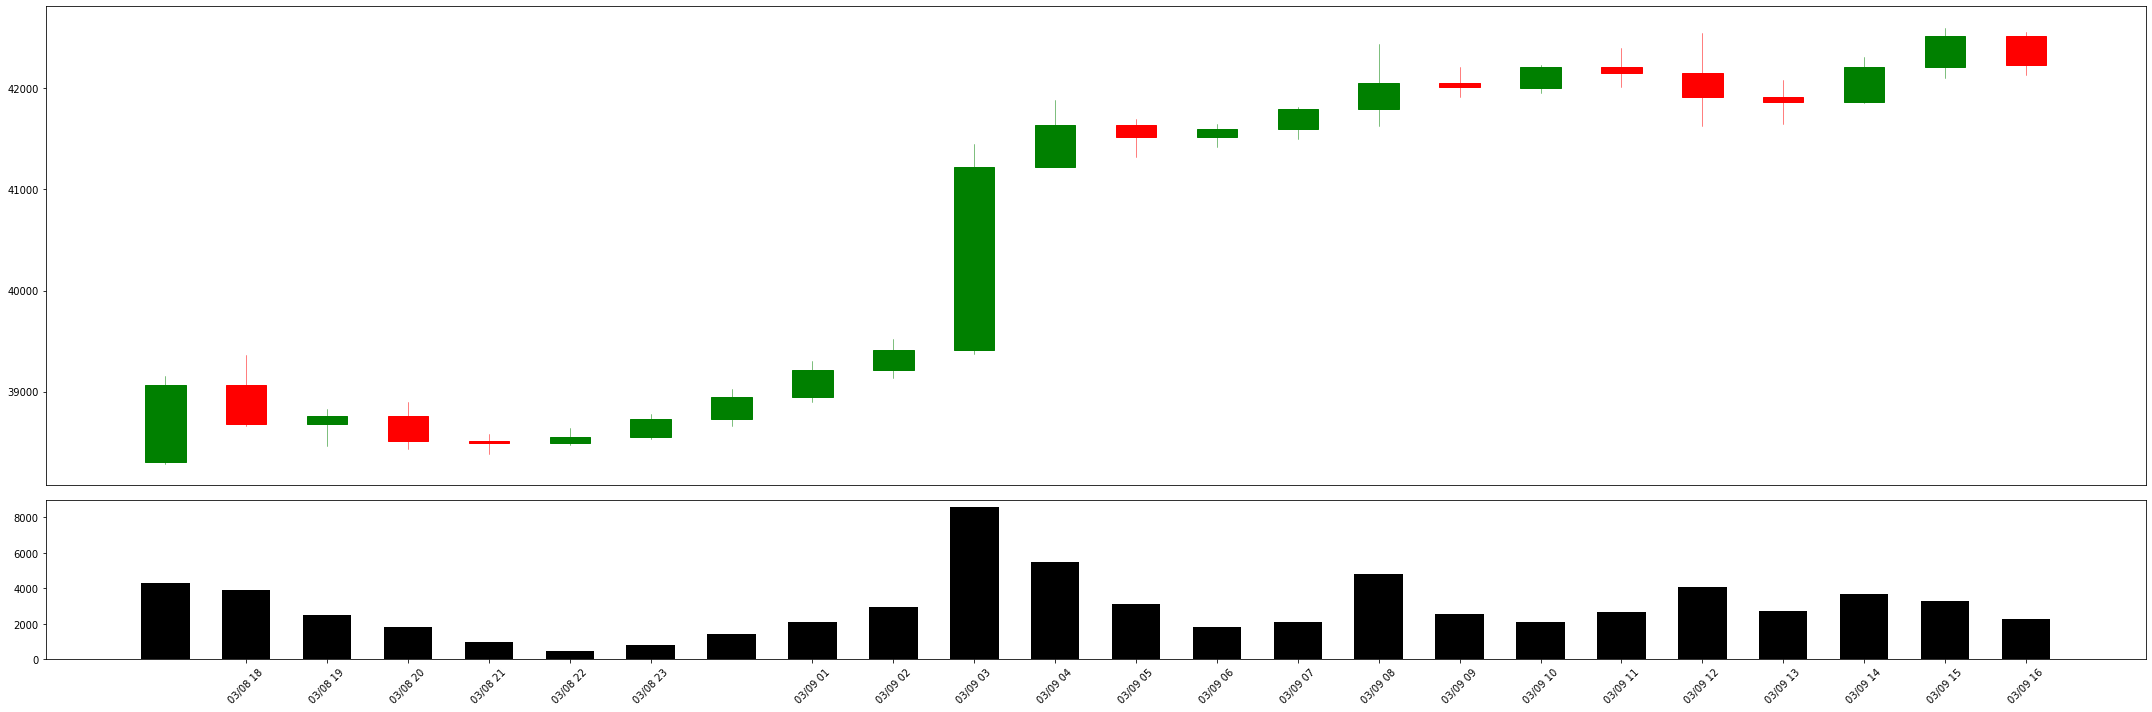

분석 "BTC 70일 연속 200일 MA 하회... 바닥 가까워"
유투데이에 따르면 비스포크 인베스트먼트 그룹 분석가 제이크 고든이 "비트코인이 장기간 200일 이동평균(MA)을 하회하고 있다는 점에서 볼 때 바닥이 가까웠다"고 진단했다. 비스포크 인베스트먼트 그룹은 비트코인이 오랜기간 200일 MA 아래에 머문 후 반등 시 가파르게 상승하는 경향이 있다고 분석했다. 그룹이 집계한 데이터에 따르면 비트코인이 최소 50일 연속 약세를 보인 이후 반등 시 평균 수익률은 약 31%였고, 연평균 수익률은 226%였다. 현재 비트코인은 70일 연속 200일 MA를 밑돌고 있는 상태다. 코인마켓캡 기준 BTC는 현재 1.85% 오른 38,669.84 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 3월 8일 8시 
딥러닝 기반 기사 유사도: 0.8245
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:79.41%, 악재:11.93%, 중립:8.66%


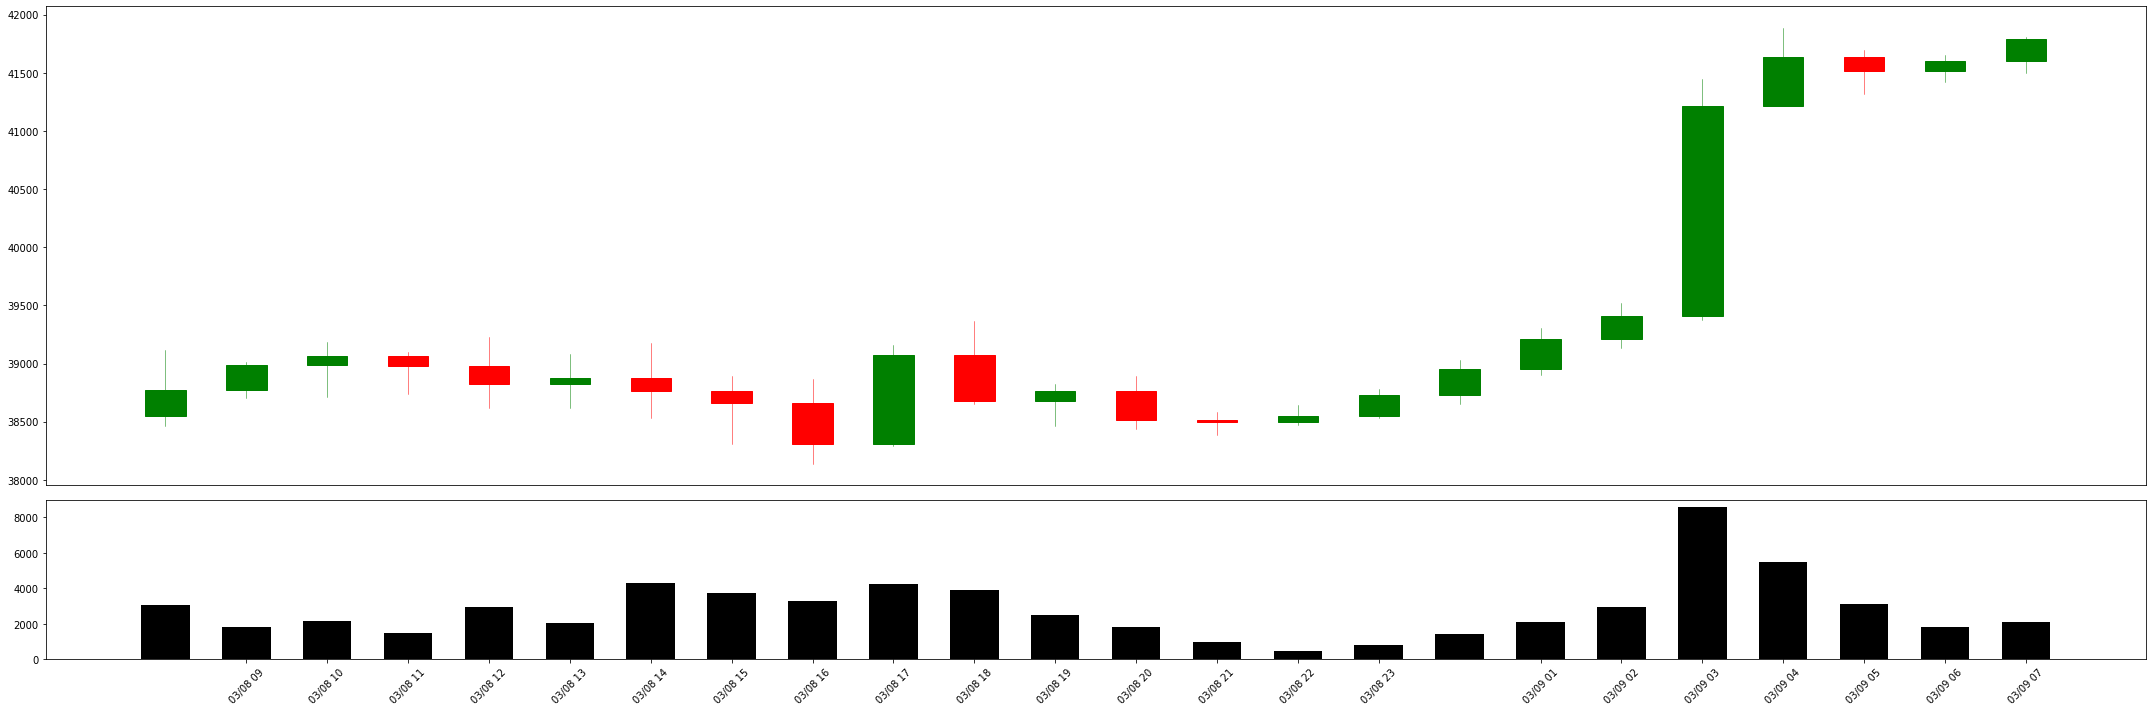

분석 "BTC, 하방 압력 약해졌지만 강세 전환으로 보긴 어려워"
암호화폐 전문 미디어 AMB크립토가 "비트코인 가격이 최근 단기 상승 흐름을 보이며 하방 압력이 약화되고 있지만, 이를 강세 전환으로 보기는 어렵다"고 23일 진단했다. 이와 관련 AMB크립토는 "최근 암호화폐 시장 내 비트코인 시총 점유율(도미넌스)가 완만한 상승세를 보이고 있는 반면, USDT 도미넌스는 지난주 4.87%에서 4.28%까지 하락했다. 이는 시장 참여자들이 암호화폐에 자본을 배치하기 시작했음을 시사한다. 한편 45,800 달러 구간부터는 매물대가 집중된 구간으로, 52,000 달러까지 강력한 저항이 존재할 수 있다. 따라서 장기 하방 압력이 상당 부분 해소된 것은 맞지만 매수세가 주도권을 잡았다고 말할 수는 없다"고 설명했다. 또 AMB크립토는 "최근 비트코인의 횡보는 매수세와 매도세가 그만큼 치열한 접전을 벌였다는 것"이라며 "44,000~45,000 달러와 48,000 달러선의 저항은 견고했고, 38,000 달러선과 35,000~36,400 달러 구간은 반대로 강력한 지지가 될 수 있다"고 부연했다. 코인마켓캡 기준 BTC는 현재 1.79% 내린 42,090.79 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 3월 23일 21시 
딥러닝 기반 기사 유사도: 0.8205
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:51.02%, 악재:30.25%, 중립:18.73%


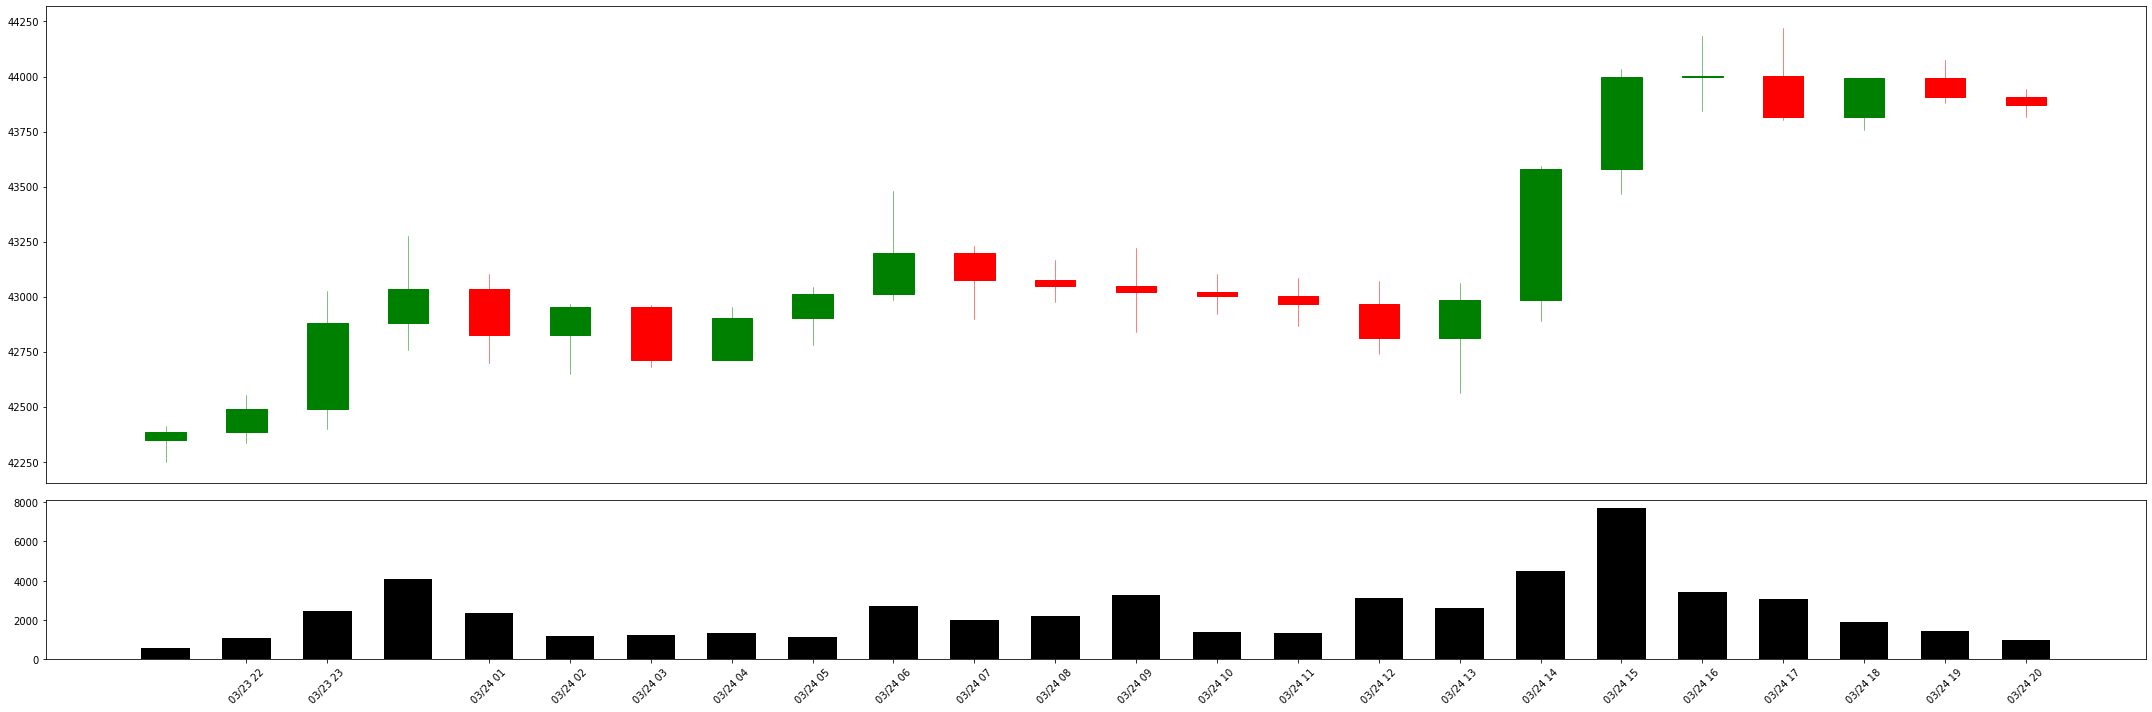

분석 "BTC, 온체인 활성도 저하...매도세로부터 안전하다는 증거"
암호화폐 전문 미디어 유투데이에 따르면 주기영 크립토퀀트 대표가 트위터를 통해 "최근 일주일 동안 눈에 띄는 비트코인 온체인 지표 변화를 보지 못했다. 온체인 활성도가 낮아지고 있다는 것을 통해 미래를 알 수는 없지만, 적어도 잠잠한 BTC 마켓은 매도세로부터 안전하다는 것을 의미한다"고 진단했다. 이와 관련해 유투데이는 "기술적 데이터상 현재 BTC 거래량과 차트 패턴은 비트코인이 장기 횡보 구간에 진입했음을 시사하는데, 이는 온체인 지표가 별다른 변화를 보이지 않는 것과 밀접한 관련이 있다. 단, 암호화폐 트레이더 피터 브랜트(Peter Brandt)와 같은 분석가는 비트코인의 극도로 낮은 변동성은 통상 상승이든, 하락이든 엄청난 가격 급변의 전조 역할을 하기 때문에 지금은 폭풍전야 상태로 보기도 한다"고 설명했다.
뉴스가 올라온 시각 : 2022년 7월 8일 4시 
딥러닝 기반 기사 유사도: 0.8189
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:71.02%, 악재:17.49%, 중립:11.49%


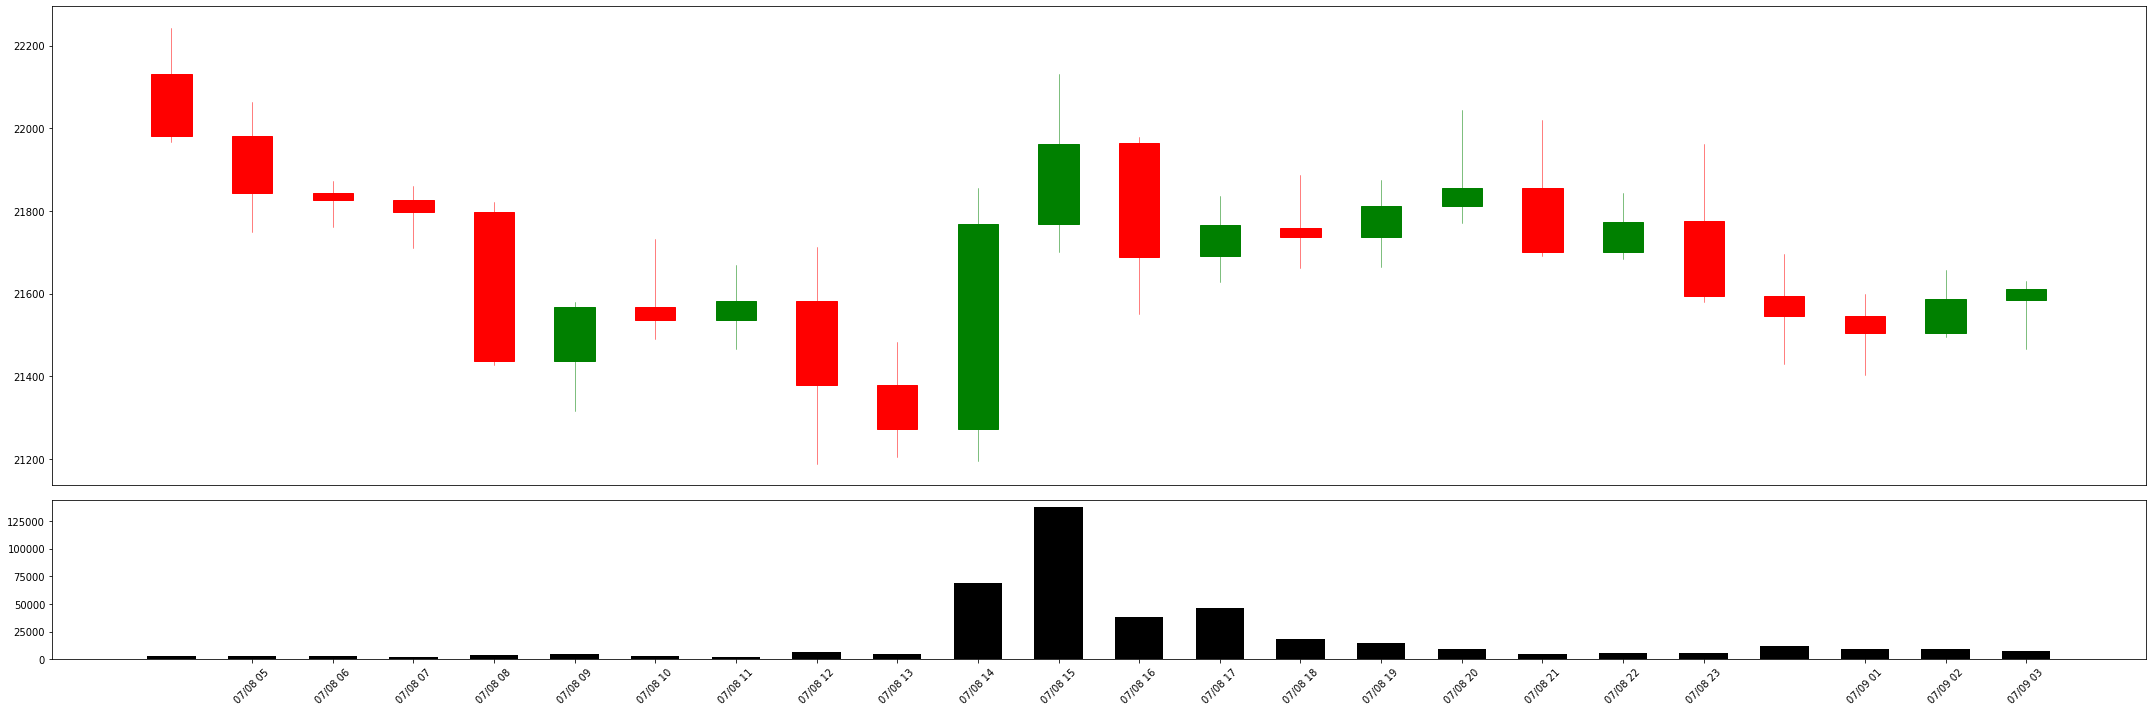

분석 "BTC, 단기 상승 나왔지만 중장기 추세 전환은 시기상조"
암호화폐 전문 분석 업체 에이엠매니지먼트가 1일 주간 보고서를 통해 "지난주부터 BTC에 단기 상승이 나오고는 있지만 중장기 관점에서 (상승)추세 전환 가능성을 보기엔 시기상조"라고 진단했다. 보고서는 "4시간봉 캔들 차트에서 BTC는 현재 상승 채널 내에서 움직이고 있다. 추가 상승을 위해서는 상승 채널 상단 돌파가 필요하며, 돌파에 실패할 경우 20,779 달러까지 조정을 받을 수 있다. 또 상승 채널 하방 이탈 시 19,000 달러까지 추가 하락 가능성이 높아진다"고 덧붙였다. 코인마켓캡 기준 BTC는 현재 2.27% 내린 23,225.07 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 8월 1일 19시 
딥러닝 기반 기사 유사도: 0.8154
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:45.39%, 악재:37.16%, 중립:17.45%


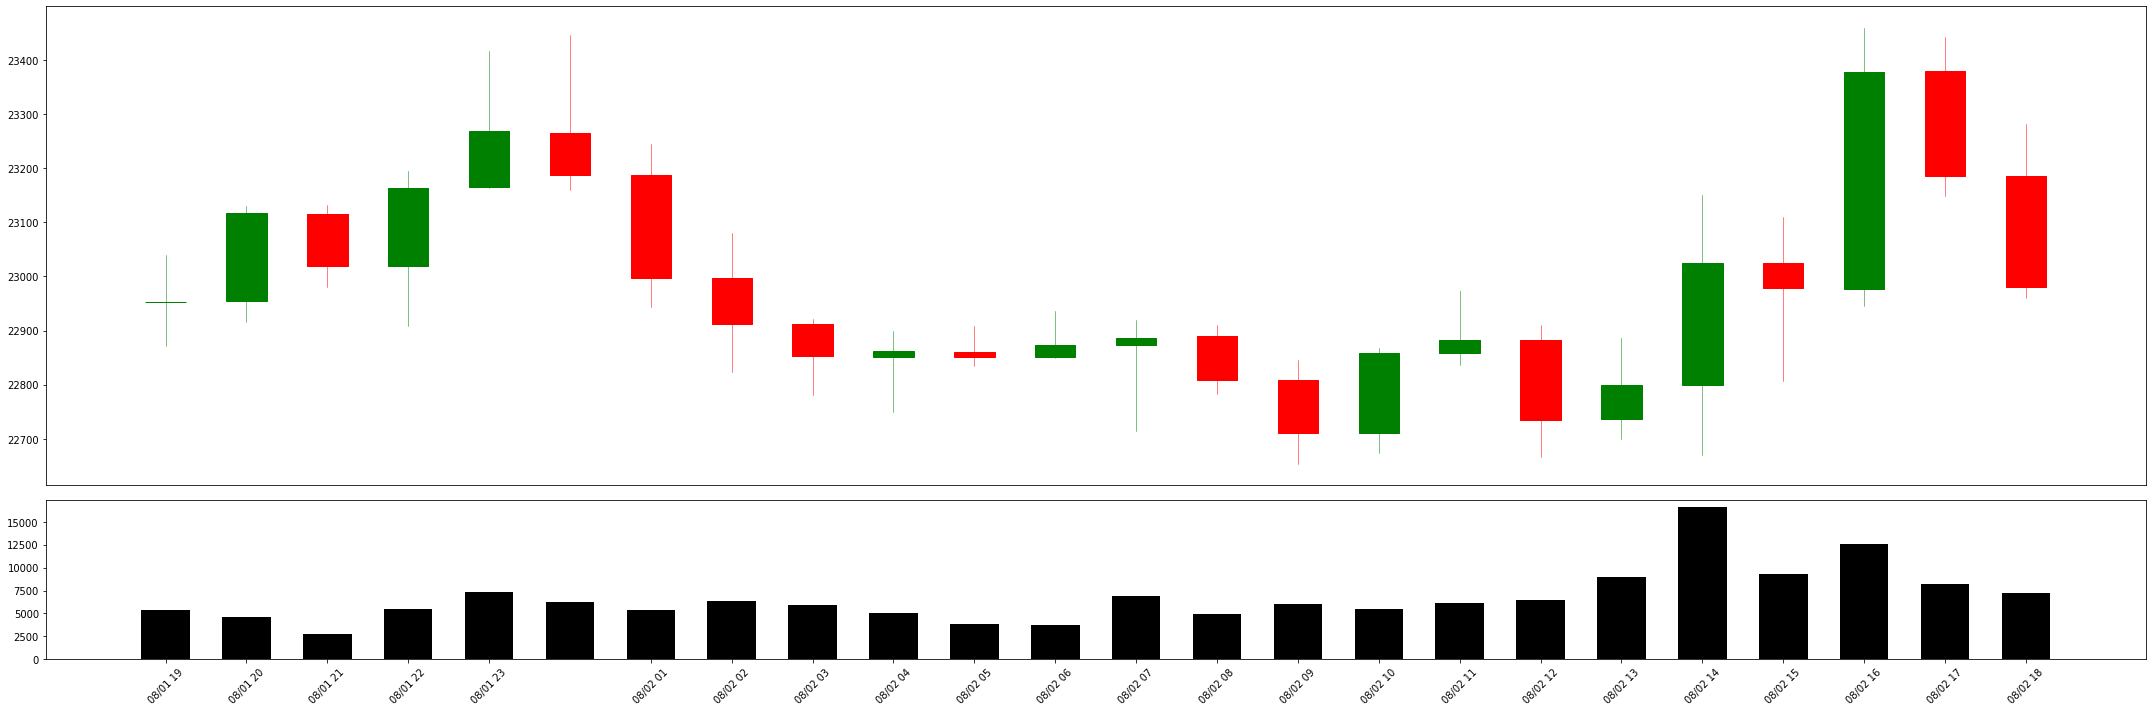

분석 "거래소 고래 입금 BTC 비중, 아직 위험구간...약세장 안 끝났다"
블록체인 분석 플랫폼 크립토퀀트(CryptoQuant) 저자 'BinhDang'이 "72시간 단순이동평균(SMA) 기준 거래소 고래 입금 비중(Exchange Whale Ratio, 거래소에 입금된 BTC 중 트랜잭션 규모 상위 10개 물량이 입금량에서 차지하는 비중)이 여전히 위험 구간에 있기 때문에 약세장이 끝났다고 판단하긴 이르다"고 분석했다. 그는 "해당 지표는 단계 별로 BTC의 약세와 강세를 판단하는데 활용될 수 있다. 시장이 강세일 때 EWR 지표는 0.8~0.85가 일반적이다. 자산 가격이 오르며 현물 거래소에 예치된 BTC 물량이 늘어나면 0.85~0.9 수준에서 오르내리고 시장은 장기 약세장에 접어든다. 이 과정에서 가장 강력한 카피출레이션(모든 희망을 버리고 투매)이 일어날 때까지 데드캣바운스(자산 가격이 급락 후 임시로 소폭 회복된 것을 의미) 현상이 패턴처럼 반복된다. 이후 과열된 지표가 0.85~0.9 수준에서 안정화 되고, 투심이 개선되면 0.8~0.85 범위를 유지하게 된다. 이때 강세장이 다시 시작된다"고 설명했다. 현재 BTC EWR 지표는 0.9 상방에서 등락을 반복 중이다. 코인마켓캡 기준 BTC는 현재 3.62% 내린 21,921.16 달러에 거래되고 있다.
뉴스가 올라온 시각 : 2022년 7월 25일 21시 
딥러닝 기반 기사 유사도: 0.8138
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:37.63%, 악재:27.81%, 중립:34.56%


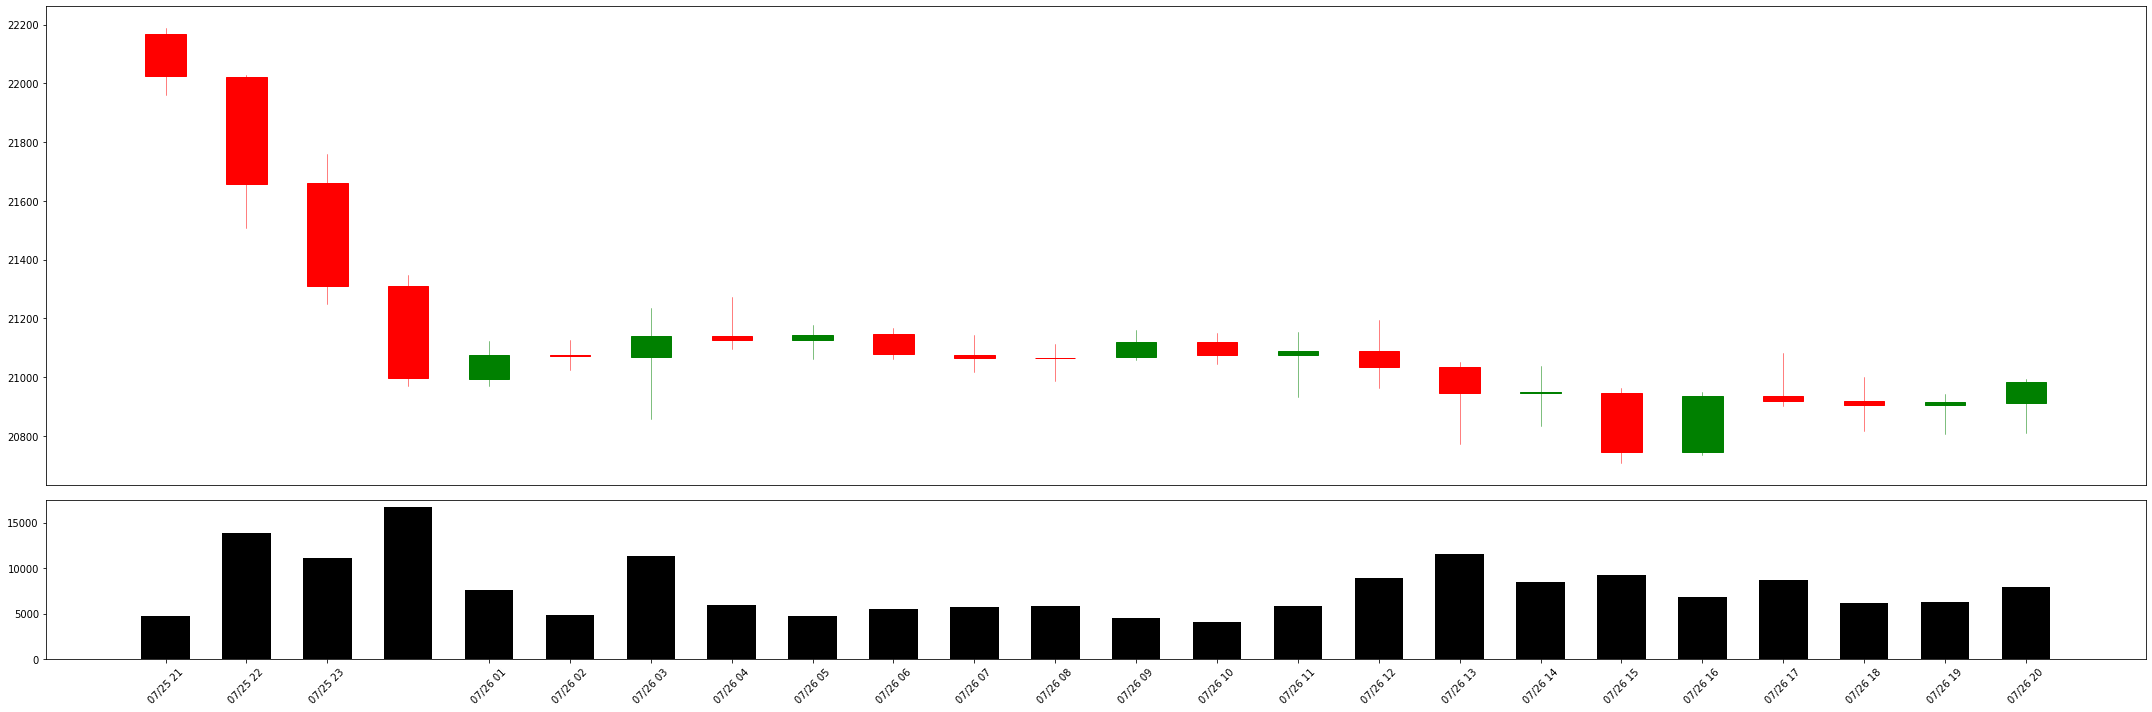

In [23]:
title = str(input("뉴스 제목을 입력하세요: "))
content = str(input("뉴스 기사를 입력하세요: ")) 

get_rank_results(title, content) 